#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
# from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
from sympy import *

In [7]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [8]:
mp = 96 #  (submerged) [kg/m]

In [9]:
node_N=4

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e30*np.array([1, 1, 2]) # [m^4]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [20]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [21]:
rng = np.random.default_rng()

In [22]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [23]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [24]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[-0.02806636,  0.56687905,  0.82332279],
       [-0.78421545, -0.52322875,  0.33352332],
       [ 0.61985354, -0.63630167,  0.45924044]])

In [25]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002302


In [26]:
Ret

array([[[-0.02806636,  0.56687905,  0.82332279],
        [-0.78421545, -0.52322875,  0.33352332],
        [ 0.61985354, -0.63630167,  0.45924044]],

       [[ 0.19497962, -0.01554595, -0.98068408],
        [ 0.1522215 ,  0.98823858,  0.01459898],
        [ 0.96892289, -0.1521277 ,  0.19505281]],

       [[ 0.03029695,  0.68658819,  0.726415  ],
        [-0.56815554,  0.60975523, -0.55262812],
        [-0.82236329, -0.39597376,  0.40856261]],

       [[-0.08209575, -0.12352725,  0.98893949],
        [ 0.65717794, -0.75270163, -0.03946414],
        [ 0.74925126,  0.64666937,  0.14297299]]])

In [27]:
Ret.shape

(4, 3, 3)

In [28]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [29]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [30]:
dx**2

array([3.64443556, 0.76571516, 0.10507303, 0.97569435])

In [31]:
C1(dx,dy,dz,Ret)

array([[ 0.1484533 , -0.41040938, -0.26698328,  3.85208871],
       [ 1.93991473,  1.75994103, -1.48462605,  1.43673705],
       [ 3.12531591,  0.13669331,  0.17286518, -1.61738929]])

In [32]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [33]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000455


In [34]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [35]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([  851.97853701, 11133.23644664, 17936.29408927])

In [36]:
fD(dx,dy,dz,DT,Ret)

array([[  851.97853701, -2355.35337268, -1532.2261166 , 22107.26782608],
       [11133.23644664, 10100.36128165, -8520.31926474,  8245.48268858],
       [17936.29408927,   784.48755332,   992.07910763, -9282.25199839]])

In [37]:
fD(dx,dy,dz,DT,Ret).T

array([[  851.97853701, 11133.23644664, 17936.29408927],
       [-2355.35337268, 10100.36128165,   784.48755332],
       [-1532.2261166 , -8520.31926474,   992.07910763],
       [22107.26782608,  8245.48268858, -9282.25199839]])

In [38]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000429


In [39]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [40]:
I=np.identity(3)

In [41]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000348


In [42]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [43]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [44]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [45]:
DR=np.diag(diag_DR) 

In [46]:
dI= 0.69# Inner diameter of pipe, [m]

In [47]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [52]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [53]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [54]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [55]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [56]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [57]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [58]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [59]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000085


In [61]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [62]:
phi(x,y,z,Ret,None)

array([[-224.79202407,  -53.18179852,  -72.53386946],
       [ -77.62707944,  131.20816652,  180.03843461],
       [  94.66793232,   19.96187703,    9.2416693 ],
       [ 237.97661292,  134.83975794,  -98.11537968]])

In [63]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [64]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000188


In [65]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [66]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [67]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001006


In [68]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [69]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000371


In [70]:
ωe(φ,θ,ψ,None,None)

array([[-1.43588872,  0.01512336, -0.2269405 ],
       [-0.09242094, -1.36799041, -0.05774498],
       [-0.01727574,  2.04072087, -1.30234908],
       [ 2.09654001,  0.84790661,  0.04210457]])

In [71]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [72]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ -13.16605955, -238.71424287,   44.85700123,  -88.87004844],
       [ -53.13614648,   21.12189629, -123.13103524,  215.72272164],
       [  79.76275309, -118.31948681, -193.53567748,   80.91499699]])

In [73]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [74]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [75]:
# d_s(phi,x,y,z,Ret)

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001088


In [77]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [78]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [79]:
# sigma(x,y,z)

In [80]:
ne_(dx,dy,dz,DT,Ret)

array([[  -851.97853701,   2355.35337268,   1532.2261166 ,
        -22107.26782608],
       [-11133.23644664, -10100.36128165,   8520.31926474,
         -8245.48268858],
       [-18064.4586315 ,   -912.65209555,  -1120.24364986,
          9154.08745616]])

In [81]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [82]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001088


In [83]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-1.03490674e+07, -1.43323002e+10,  1.66913781e+10],
       [-9.08262433e+09,  2.04793092e+10, -4.53839912e+09],
       [ 4.11466672e+07, -4.55690552e+10, -3.21683632e+10],
       [-5.98405230e+08,  1.21847479e+11,  1.63869013e+09]])

In [84]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000344


In [85]:
Re_b(Ret).shape

(4, 3, 3)

In [86]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [87]:
Irho_e(Ret)

array([[[7.87720543e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.73768326e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.21803562e+01]],

       [[3.80170523e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.76615486e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.60911976e+00]],

       [[9.17905236e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.71801443e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.33846805e+01]],

       [[6.73971197e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.66559741e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.08825501e+00]]])

In [88]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000169


In [89]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [90]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [91]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [92]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [93]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [94]:
# ωe(φ,θ,ψ,None)

In [95]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [96]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [97]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [98]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.000736


In [99]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [100]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [101]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [102]:
ne_(dx,dy,dz,DT,Ret)

array([[  -851.97853701,   2355.35337268,   1532.2261166 ,
        -22107.26782608],
       [-11133.23644664, -10100.36128165,   8520.31926474,
         -8245.48268858],
       [-18064.4586315 ,   -912.65209555,  -1120.24364986,
          9154.08745616]])

In [103]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [104]:
Re_b(Ret).shape

(4, 3, 3)

In [105]:
ne_(dx,dy,dz,DT, Ret).T

array([[  -851.97853701, -11133.23644664, -18064.4586315 ],
       [  2355.35337268, -10100.36128165,   -912.65209555],
       [  1532.2261166 ,   8520.31926474,  -1120.24364986],
       [-22107.26782608,  -8245.48268858,   9154.08745616]])

In [106]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ -53.45022234,  103.48292344,   73.51028643, -194.33890647]),
 array([-236.1242502 ,  113.16014525,   61.51251162,  215.99528306]),
 array([-1.90904048, -0.87505152,  0.32414971, -0.98777242]),
 numpy.ndarray,
 array([ 0.52346654, -0.15623592,  1.1601413 ,  0.01387254]))

In [107]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[-22012.1458609 , -10664.79064898, -19804.39377018],
       [  3866.64235381, -19736.71638039,   2728.03298745],
       [  6614.83670309,  13464.16397387,  -6211.80267314],
       [-10220.97439942, -16928.76136589, -11433.1242355 ]])

In [108]:
ne_(dx,dy,dz,DT,Ret).T

array([[  -851.97853701, -11133.23644664, -18064.4586315 ],
       [  2355.35337268, -10100.36128165,   -912.65209555],
       [  1532.2261166 ,   8520.31926474,  -1120.24364986],
       [-22107.26782608,  -8245.48268858,   9154.08745616]])

### Vessel

In [109]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [110]:
V=VesselSemisub()

In [111]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [112]:
tau_force = V.tau(η,dη, ddη)

In [113]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [114]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [115]:
V=VesselOtter()

In [116]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [117]:
tau_force = V.tau(η,dη, ddη)

In [118]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [119]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [120]:
V=VesselSemisub()

In [121]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [122]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [123]:
Hs = 2.5 # significant wave height in m

In [124]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [125]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [126]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [127]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [128]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[5828.76914536 7132.08869406    0.            0.            0.
    0.        ]


### Static solution

In [129]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [130]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [131]:
Fx_0=82945396

In [132]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [133]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [134]:
delta_x=horizontal_length/(node_N-1)

In [135]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [136]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

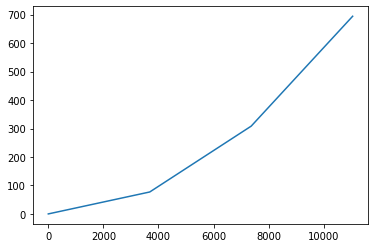

In [137]:
plt.plot(x0, z0)
plt.show()

In [138]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [139]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [140]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
   
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [141]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [142]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [144]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [145]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [146]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [147]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [148]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

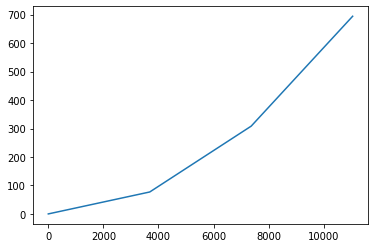

In [149]:
plt.plot(x0_, z0_)
plt.show()

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [151]:
# q0[10*node_N]=q0[8*node_N]=0

In [152]:
q0

array([ 0.00000000e+00,  3.68422828e+03,  7.36845656e+03,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.70680464e+01,  3.08407059e+02,  6.94421895e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.91869842e-01,  4.99204015e-02, -1.65190166e-01, -1.67969390e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.26158775e-02, -2.25711081e-01,  2.96922773e-01, -4.88928601e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

### Dynamics

In [158]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
# #     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
# #     y[-1]+=5*np.cos(t)
# #     z[-1]=z0[-1]+2.5*np.sin(t)
#     z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
#     left=V.eq_left(η,dη)

    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:

    hack =0.0005
#     ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, left.astype(np.float32) 
#                         - tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#                         , rcond=None)[0]
#     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)
    tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret,Z0)
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        + Z0
       )

############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    hack2=1e-6
    for i in range(len(RRRR)):
        a,b,c=np.linalg.lstsq(Ws*RRRR[i]
#                               +hack2*np.identity(3)
                              , Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i]
#                               +hack2*np.identity(3)
                              ,B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    ddφ*=np.exp(-t)
    ddθ*=np.exp(-t)
    ddψ*=np.exp(-t)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

    print(A1111)
    return A1111

In [159]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [160]:
# us=ode15s.integrate(10)

In [161]:
tspan = (0., 5)
# tspan = (0., 10)

In [162]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.98290769e+08 -8.20103714e+08 -3.49338802e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.94170342e+06  5.26000251e+07 -9.86927356e+06
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.18081386e+06 -1.05508223e+08 -2.47899268e+07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.91681802e+10  1.36821068e+12  2.58456390e+11
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.53215594e+10  8.11664836e+11  9.35753410e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.33757428e+09 -4.53022575e+11 -1.12150584e+10]
[ 0.00000000e+00 -4.40316368e-09 -1.82108875e-08 -7.75727448e-09
  0.00000000e+00 -1.98290769e+08 -8.20103714e+08 -3.49338802e+08
  0.00000000e+00 -6.53222623e-11  1.16801463e-09 -2.19153050e-10
  0.00000000e+00 -2.9417

[ 0.00000000e+00 -4.89235517e-03 -2.02341171e-02 -8.61910767e-03
  0.00000000e+00 -1.98290769e+08 -8.20103715e+08 -3.49338802e+08
  0.00000000e+00 -7.25795656e-05  1.29778105e-03 -2.43500956e-04
  0.00000000e+00 -2.94170342e+06  5.26000244e+07 -9.86927372e+06
  0.00000000e+00  2.26514841e-04 -2.60316554e-03 -6.11632740e-04
  0.00000000e+00  9.18081385e+06 -1.05508222e+08 -2.47899268e+07
  0.00000000e+00  1.70656105e+00  3.37573585e+01  6.37679938e+00
  0.00000000e+00  6.91681802e+10  1.36821068e+12  2.58456390e+11
  0.00000000e+00 -3.78023195e-01  2.00259077e+01  2.30874995e-02
  0.00000000e+00 -1.53215594e+10  8.11664837e+11  9.35753413e+08
  0.00000000e+00  3.30014780e-02 -1.11772592e+01 -2.76705009e-01
  0.00000000e+00  1.33757428e+09 -4.53022576e+11 -1.12150584e+10]
[ 0.00000000e+00 -4.89235517e-03 -2.02341171e-02 -8.61910767e-03
  0.00000000e+00 -1.98290769e+08 -8.20103715e+08 -3.49338802e+08
  0.00000000e+00 -7.25795656e-05  1.29778105e-03 -2.43500955e-04
  0.00000000e+00 -2.9417

[ 0.00000000e+00 -8.33188712e+01 -3.24724314e+02 -1.45715024e+02
  0.00000000e+00 -1.98804796e+08 -6.62157406e+08 -3.41924726e+08
  0.00000000e+00 -1.08034136e+00  5.61530969e-01 -1.00110832e+01
  0.00000000e+00 -1.77822911e+06 -9.16741198e+07 -5.36569205e+07
  0.00000000e+00  3.17253707e+00 -5.98864975e+00 -1.20997918e+01
  0.00000000e+00  4.05914348e+06  1.63974686e+08 -3.73169779e+07
  0.00000000e+00  2.93152862e+04  5.39791022e+05  1.08955750e+05
  0.00000000e+00  7.12367729e+10  1.09001302e+12  2.61303826e+11
  0.00000000e+00 -6.49472554e+03  2.75560464e+05  3.45624774e+02
  0.00000000e+00 -1.57824554e+10  3.27420965e+11 -1.14690923e+09
  0.00000000e+00  5.61380667e+02 -1.45538005e+05 -4.72748838e+03
  0.00000000e+00  1.32198340e+09 -1.23870037e+11 -1.16162398e+10]
[ 0.00000000e+00 -9.01638271e+01 -3.45382507e+02 -1.57381914e+02
  0.00000000e+00 -1.98903503e+08 -6.29185889e+08 -3.40271609e+08
  0.00000000e+00 -1.12733904e+00 -4.01507483e+00 -1.23836704e+01
  0.00000000e+00 -1.5397

[ 0.00000000e+00 -2.66377964e+02 -6.19533509e+02 -4.29044923e+02
  0.00000000e+00 -2.01980222e+08 -2.17896299e+08 -2.75892502e+08
  0.00000000e+00  1.67869533e+00 -2.47939027e+02 -2.03045833e+02
  0.00000000e+00  1.00739895e+07 -5.21032413e+08 -4.19876370e+08
  0.00000000e+00 -1.21212519e+01  3.76443271e+02 -8.34311303e+01
  0.00000000e+00 -4.68989790e+07  4.54577985e+08 -1.25783530e+08
  0.00000000e+00  1.01861205e+05  9.29054892e+05  3.51203178e+05
  0.00000000e+00  9.10268118e+10 -8.10413234e+10  2.87414981e+11
  0.00000000e+00 -2.22302423e+04 -7.18446777e+05 -9.47482961e+04
  0.00000000e+00 -1.87467366e+10 -7.87364761e+12 -3.84663881e+11
  0.00000000e+00  9.24098225e+02 -3.79974822e+04 -3.64065734e+04
  0.00000000e+00 -2.07605816e+09 -1.36639907e+12 -1.08456169e+11]
[ 0.00000000e+00 -2.84818738e+02 -6.40664874e+02 -4.54366737e+02
  0.00000000e+00 -2.02247891e+08 -2.06139196e+08 -2.74797652e+08
  0.00000000e+00  2.69653790e+00 -2.96717995e+02 -2.44334095e+02
  0.00000000e+00  1.2082

[ 0.00000000e+00 -3.35501849e+02 -6.89234524e+02 -5.23160113e+02
  0.00000000e+00 -2.02723547e+08 -3.86666208e+08 -2.81338808e+08
  0.00000000e+00  6.48869364e+00 -2.32504461e+02 -3.85903659e+02
  0.00000000e+00  1.85332812e+07  1.10999290e+09 -6.69231850e+08
  0.00000000e+00 -3.38316998e+01  5.22025641e+02 -1.31684724e+02
  0.00000000e+00 -8.18032656e+07  1.18513991e+08 -1.52471314e+08
  0.00000000e+00  1.35132831e+05 -1.64173871e+06  4.69597269e+05
  0.00000000e+00  1.04488144e+11 -2.82605403e+13  4.43292752e+11
  0.00000000e+00 -2.87306119e+04 -6.41197148e+06 -3.65451663e+05
  0.00000000e+00 -1.91062152e+10 -3.95835581e+13 -1.47279350e+12
  0.00000000e+00 -6.32761538e+02 -4.59596969e+06 -1.16595750e+05
  0.00000000e+00 -7.75491038e+09 -3.95816356e+13 -4.52249778e+11]
[ 0.00000000e+00 -3.35929818e+02 -6.90053535e+02 -5.23753866e+02
  0.00000000e+00 -2.02726077e+08 -3.81466569e+08 -2.81464838e+08
  0.00000000e+00  6.52788056e+00 -2.30177456e+02 -3.87317971e+02
  0.00000000e+00  1.8594

[ 0.00000000e+00 -3.55457472e+02 -7.19418055e+02 -5.51104843e+02
  0.00000000e+00 -2.02815307e+08 -3.42118435e+09 -2.85980096e+08
  0.00000000e+00  8.45644036e+00 -1.96649783e+02 -4.56268660e+02
  0.00000000e+00  2.15014988e+07  2.24513019e+09 -7.61851723e+08
  0.00000000e+00 -4.24578796e+01  5.20577362e+02 -1.46762908e+02
  0.00000000e+00 -9.36401642e+07 -1.07412519e+09 -1.53260954e+08
  0.00000000e+00  1.45643777e+05 -2.70953432e+06  5.17796447e+05
  0.00000000e+00  1.09195020e+11 -2.40485494e+14  5.40933556e+11
  0.00000000e+00 -3.06024190e+04 -4.63025714e+07 -5.47316857e+05
  0.00000000e+00 -1.89023097e+10 -1.55831311e+15 -2.28823646e+12
  0.00000000e+00 -1.51805123e+03 -2.10035018e+07 -1.73285726e+05
  0.00000000e+00 -1.03228580e+10 -6.46844122e+14 -7.22750564e+11]
[ 0.00000000e+00 -3.45239615e+02 -7.01346401e+02 -5.36735795e+02
  0.00000000e+00 -2.02774861e+08 -7.71320071e+07 -2.84071857e+08
  0.00000000e+00  7.41230454e+00 -2.01493344e+02 -4.19092477e+02
  0.00000000e+00  1.9948

[ 0.00000000e+00 -3.48382559e+02 -7.01827253e+02 -5.41145378e+02
  0.00000000e+00 -2.02788863e+08 -3.32280256e+06 -2.84843818e+08
  0.00000000e+00  7.72533683e+00 -2.00516583e+02 -4.30274851e+02
  0.00000000e+00  2.04185811e+07  7.68947335e+06 -7.28416139e+08
  0.00000000e+00 -3.92662870e+01  5.24007543e+02 -1.41411075e+02
  0.00000000e+00 -8.93512884e+07 -1.40503274e+07 -1.53471801e+08
  0.00000000e+00  1.41864572e+05 -1.49445646e+06  4.99589765e+05
  0.00000000e+00  1.07476725e+11 -3.63054096e+14  5.03331484e+11
  0.00000000e+00 -2.99412842e+04 -8.37404086e+06 -4.73475210e+05
  0.00000000e+00 -1.89964051e+10  1.12259626e+14 -1.95416990e+12
  0.00000000e+00 -1.17503716e+03 -5.71699710e+06 -1.50079329e+05
  0.00000000e+00 -9.35363648e+09  1.40509548e+14 -6.10940396e+11]
[ 0.00000000e+00 -3.48500217e+02 -7.01828759e+02 -5.41310646e+02
  0.00000000e+00 -2.02789318e+08 -2.20757126e+06 -2.84869695e+08
  0.00000000e+00  7.73718881e+00 -2.00512818e+02 -4.30697628e+02
  0.00000000e+00  2.0436

[ 0.00000000e+00 -3.48934580e+02 -7.01830761e+02 -5.41920837e+02
  0.00000000e+00 -2.02791159e+08  5.46435485e+05 -2.84963194e+08
  0.00000000e+00  7.78103120e+00 -2.00506811e+02 -4.32261072e+02
  0.00000000e+00  2.05018363e+07  4.37395426e+04 -7.31013768e+08
  0.00000000e+00 -3.95099606e+01  5.23968495e+02 -1.41828826e+02
  0.00000000e+00 -8.96822639e+07 -1.47549285e+07 -1.53474733e+08
  0.00000000e+00  1.42157321e+05 -5.11343265e+06  5.00963427e+05
  0.00000000e+00  1.07608848e+11 -3.46313567e+15  5.06161372e+11
  0.00000000e+00 -2.99929837e+04 -8.72724985e+06 -4.78826505e+05
  0.00000000e+00 -1.89899682e+10 -1.75657403e+15 -1.97831567e+12
  0.00000000e+00 -1.20059845e+03 -6.14709870e+06 -1.51753016e+05
  0.00000000e+00 -9.42667065e+09 -2.16134677e+15 -6.18974997e+11]
[ 0.00000000e+00 -3.49015260e+02 -7.01830488e+02 -5.42034213e+02
  0.00000000e+00 -2.02791487e+08  8.12436600e+05 -2.84980328e+08
  0.00000000e+00  7.78919021e+00 -2.00506944e+02 -4.32551980e+02
  0.00000000e+00  2.0514

[ 0.00000000e+00 -3.49057789e+02 -7.01830307e+02 -5.42093980e+02
  0.00000000e+00 -2.02791661e+08  9.20853151e+05 -2.84989395e+08
  0.00000000e+00  7.79349306e+00 -2.00507106e+02 -4.32705387e+02
  0.00000000e+00  2.05204528e+07 -9.94225104e+05 -7.31594197e+08
  0.00000000e+00 -3.95644710e+01  5.23959358e+02 -1.41922072e+02
  0.00000000e+00 -8.97562248e+07 -1.53507998e+07 -1.53474884e+08
  0.00000000e+00  1.42222710e+05 -8.08205941e+06  5.01271146e+05
  0.00000000e+00  1.07638380e+11 -6.06185134e+15  5.06794811e+11
  0.00000000e+00 -3.00045209e+04 -1.19322458e+07 -4.80030104e+05
  0.00000000e+00 -1.89885332e+10 -1.33618294e+16 -1.98374974e+12
  0.00000000e+00 -1.20633068e+03 -1.00981467e+07 -1.52129630e+05
  0.00000000e+00 -9.44321320e+09 -1.64907115e+16 -6.20784400e+11]
[ 0.00000000e+00 -3.49062918e+02 -7.01830283e+02 -5.42101187e+02
  0.00000000e+00 -2.02791689e+08  9.33584895e+05 -2.84990449e+08
  0.00000000e+00  7.79401208e+00 -2.00507134e+02 -4.32723891e+02
  0.00000000e+00  2.0521

[ 0.00000000e+00 -3.49112154e+02 -7.01830044e+02 -5.42170381e+02
  0.00000000e+00 -2.02791868e+08  1.03532567e+06 -2.85000839e+08
  0.00000000e+00  7.79899530e+00 -2.00507430e+02 -4.32901548e+02
  0.00000000e+00  2.05286604e+07 -1.37828920e+06 -7.31850296e+08
  0.00000000e+00 -3.95885372e+01  5.23955209e+02 -1.41963216e+02
  0.00000000e+00 -8.97888607e+07 -1.55468608e+07 -1.53474927e+08
  0.00000000e+00  1.42251567e+05 -7.78832674e+06  5.01407045e+05
  0.00000000e+00  1.07651152e+11  3.00606900e+16  5.07074410e+11
  0.00000000e+00 -3.00096113e+04 -1.95224542e+07 -4.80562238e+05
  0.00000000e+00 -1.89878724e+10 -5.16231176e+16 -1.98615111e+12
  0.00000000e+00 -1.20886317e+03 -1.94753764e+07 -1.52296160e+05
  0.00000000e+00 -9.45047677e+09 -6.38180485e+16 -6.21583235e+11]
[ 0.00000000e+00 -3.49117282e+02 -7.01830017e+02 -5.42177589e+02
  0.00000000e+00 -2.02791897e+08  1.04396343e+06 -2.85001905e+08
  0.00000000e+00  7.79951448e+00 -2.00507465e+02 -4.32920057e+02
  0.00000000e+00  2.0529

[ 0.00000000e+00 -3.49132832e+02 -7.01829936e+02 -5.42199442e+02
  0.00000000e+00 -2.02791961e+08  1.06423039e+06 -2.85005239e+08
  0.00000000e+00  7.80108870e+00 -2.00507574e+02 -4.32976177e+02
  0.00000000e+00  2.05317889e+07 -1.42815492e+06 -7.31947757e+08
  0.00000000e+00 -3.95976934e+01  5.23953629e+02 -1.41978865e+02
  0.00000000e+00 -8.98012777e+07 -1.54298264e+07 -1.53474940e+08
  0.00000000e+00  1.42262544e+05  5.11472069e+05  5.01458755e+05
  0.00000000e+00  1.07656383e+11  2.82250049e+15  5.07182254e+11
  0.00000000e+00 -3.00115474e+04 -1.58708521e+07 -4.80764806e+05
  0.00000000e+00 -1.89876281e+10  2.88609495e+17 -1.98706773e+12
  0.00000000e+00 -1.20982694e+03 -1.49591808e+07 -1.52359556e+05
  0.00000000e+00 -9.45310771e+09  3.56896291e+17 -6.21889072e+11]
[ 0.00000000e+00 -3.49133389e+02 -7.01829934e+02 -5.42200225e+02
  0.00000000e+00 -2.02791976e+08  1.06474285e+06 -2.85005318e+08
  0.00000000e+00  7.80114515e+00 -2.00507578e+02 -4.32978189e+02
  0.00000000e+00  2.0531

[ 0.00000000e+00 -3.49140475e+02 -7.01829896e+02 -5.42210183e+02
  0.00000000e+00 -2.02792003e+08  1.06538647e+06 -2.85006836e+08
  0.00000000e+00  7.80186253e+00 -2.00507628e+02 -4.33003764e+02
  0.00000000e+00  2.05329469e+07 -1.43630230e+06 -7.31983731e+08
  0.00000000e+00 -3.96010779e+01  5.23953047e+02 -1.41984649e+02
  0.00000000e+00 -8.98058750e+07 -1.54218570e+07 -1.53474960e+08
  0.00000000e+00  1.42266602e+05 -8.56433812e+06  5.01477871e+05
  0.00000000e+00  1.07658159e+11 -1.65366099e+17  5.07220388e+11
  0.00000000e+00 -3.00122630e+04 -1.38518488e+07 -4.80839703e+05
  0.00000000e+00 -1.89875172e+10 -6.47050878e+17 -1.98740505e+12
  0.00000000e+00 -1.21018323e+03 -1.24627009e+07 -1.52382997e+05
  0.00000000e+00 -9.45403695e+09 -8.00208317e+17 -6.22001186e+11]
[ 0.00000000e+00 -3.49141063e+02 -7.01829893e+02 -5.42211010e+02
  0.00000000e+00 -2.02792004e+08  1.06515971e+06 -2.85006953e+08
  0.00000000e+00  7.80192210e+00 -2.00507632e+02 -4.33005887e+02
  0.00000000e+00  2.0533

[ 0.00000000e+00 -3.49144453e+02 -7.01829875e+02 -5.42215774e+02
  0.00000000e+00 -2.02792018e+08  1.06594492e+06 -2.85007633e+08
  0.00000000e+00  7.80226535e+00 -2.00507656e+02 -4.33018124e+02
  0.00000000e+00  2.05335427e+07 -1.43747476e+06 -7.32002418e+08
  0.00000000e+00 -3.96028398e+01  5.23952745e+02 -1.41987660e+02
  0.00000000e+00 -8.98082706e+07 -1.54029168e+07 -1.53474982e+08
  0.00000000e+00  1.42268714e+05  1.95435315e+06  5.01487822e+05
  0.00000000e+00  1.07659046e+11 -9.72744793e+17  5.07242534e+11
  0.00000000e+00 -3.00126355e+04 -1.06900260e+07 -4.80878693e+05
  0.00000000e+00 -1.89874824e+10  1.78158659e+18 -1.98758178e+12
  0.00000000e+00 -1.21036870e+03 -8.55163930e+06 -1.52395200e+05
  0.00000000e+00 -9.45449188e+09  2.20340813e+18 -6.22060424e+11]
[ 0.00000000e+00 -3.49144687e+02 -7.01829874e+02 -5.42216103e+02
  0.00000000e+00 -2.02792000e+08  1.06600419e+06 -2.85007683e+08
  0.00000000e+00  7.80228905e+00 -2.00507658e+02 -4.33018969e+02
  0.00000000e+00  2.0533

[ 0.00000000e+00 -3.49145054e+02 -7.01829872e+02 -5.42216619e+02
  0.00000000e+00 -2.02792003e+08  1.06552651e+06 -2.85007784e+08
  0.00000000e+00  7.80232622e+00 -2.00507660e+02 -4.33020294e+02
  0.00000000e+00  2.05336344e+07 -1.43938586e+06 -7.32005303e+08
  0.00000000e+00 -3.96031060e+01  5.23952699e+02 -1.41988115e+02
  0.00000000e+00 -8.98086211e+07 -1.54059953e+07 -1.53474935e+08
  0.00000000e+00  1.42269033e+05  7.14675678e+05  5.01489326e+05
  0.00000000e+00  1.07659178e+11 -5.81453787e+17  5.07244329e+11
  0.00000000e+00 -3.00126918e+04 -1.32134957e+07 -4.80884585e+05
  0.00000000e+00 -1.89874580e+10  1.62802227e+18 -1.98760774e+12
  0.00000000e+00 -1.21039673e+03 -1.16727250e+07 -1.52397043e+05
  0.00000000e+00 -9.45459356e+09  2.01353551e+18 -6.22069043e+11]
[ 0.00000000e+00 -3.49145398e+02 -7.01829870e+02 -5.42217103e+02
  0.00000000e+00 -2.02792020e+08  1.06552918e+06 -2.85007872e+08
  0.00000000e+00  7.80236107e+00 -2.00507663e+02 -4.33021536e+02
  0.00000000e+00  2.0533

[ 0.00000000e+00 -3.49146619e+02 -7.01829864e+02 -5.42218819e+02
  0.00000000e+00 -2.02792011e+08  1.06504511e+06 -2.85008135e+08
  0.00000000e+00  7.80248468e+00 -2.00507671e+02 -4.33025943e+02
  0.00000000e+00  2.05338750e+07 -1.44124225e+06 -7.32012698e+08
  0.00000000e+00 -3.96037991e+01  5.23952580e+02 -1.41989299e+02
  0.00000000e+00 -8.98095562e+07 -1.54084467e+07 -1.53474942e+08
  0.00000000e+00  1.42269864e+05 -8.84697783e+06  5.01493240e+05
  0.00000000e+00  1.07659681e+11 -4.82699002e+17  5.07253270e+11
  0.00000000e+00 -3.00128383e+04 -1.41860179e+07 -4.80899924e+05
  0.00000000e+00 -1.89874700e+10 -2.33409878e+18 -1.98767738e+12
  0.00000000e+00 -1.21046969e+03 -1.28756243e+07 -1.52401844e+05
  0.00000000e+00 -9.45479737e+09 -2.88687349e+18 -6.22091775e+11]
[ 0.00000000e+00 -3.49146694e+02 -7.01829864e+02 -5.42218924e+02
  0.00000000e+00 -2.02792014e+08  1.06499596e+06 -2.85008178e+08
  0.00000000e+00  7.80249227e+00 -2.00507672e+02 -4.33026213e+02
  0.00000000e+00  2.0533

[ 0.00000000e+00 -3.49148342e+02 -7.01829855e+02 -5.42221240e+02
  0.00000000e+00 -2.02792026e+08  1.06472464e+06 -2.85008488e+08
  0.00000000e+00  7.80265914e+00 -2.00507684e+02 -4.33032162e+02
  0.00000000e+00  2.05341361e+07 -1.44144369e+06 -7.32020804e+08
  0.00000000e+00 -3.96045621e+01  5.23952449e+02 -1.41990603e+02
  0.00000000e+00 -8.98105974e+07 -1.54023504e+07 -1.53474978e+08
  0.00000000e+00  1.42270778e+05 -3.08431891e+06  5.01497550e+05
  0.00000000e+00  1.07659924e+11 -1.92946920e+18  5.07261700e+11
  0.00000000e+00 -3.00129996e+04 -1.21250540e+07 -4.80916812e+05
  0.00000000e+00 -1.89874210e+10  6.35833922e+17 -1.98775283e+12
  0.00000000e+00 -1.21055003e+03 -1.03263883e+07 -1.52407130e+05
  0.00000000e+00 -9.45501311e+09  7.86435963e+17 -6.22117505e+11]
[ 0.00000000e+00 -3.49148398e+02 -7.01829855e+02 -5.42221318e+02
  0.00000000e+00 -2.02792029e+08  1.06463351e+06 -2.85008461e+08
  0.00000000e+00  7.80266476e+00 -2.00507684e+02 -4.33032363e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49149266e+02 -7.01829850e+02 -5.42222538e+02
  0.00000000e+00 -2.02792030e+08  1.06436237e+06 -2.85008628e+08
  0.00000000e+00  7.80275267e+00 -2.00507690e+02 -4.33035496e+02
  0.00000000e+00  2.05342712e+07 -1.44209170e+06 -7.32025089e+08
  0.00000000e+00 -3.96049712e+01  5.23952379e+02 -1.41991302e+02
  0.00000000e+00 -8.98111553e+07 -1.54015462e+07 -1.53474951e+08
  0.00000000e+00  1.42271269e+05 -1.98232017e+06  5.01499860e+05
  0.00000000e+00  1.07660127e+11  3.18827104e+18  5.07267214e+11
  0.00000000e+00 -3.00130861e+04 -2.02539938e+07 -4.80925866e+05
  0.00000000e+00 -1.89874167e+10  2.24491223e+18 -1.98779408e+12
  0.00000000e+00 -1.21059309e+03 -2.03809127e+07 -1.52409963e+05
  0.00000000e+00 -9.45511943e+09  2.77668528e+18 -6.22130267e+11]
[ 0.00000000e+00 -3.49149266e+02 -7.01829850e+02 -5.42222538e+02
  0.00000000e+00 -2.02792030e+08  1.06429501e+06 -2.85008628e+08
  0.00000000e+00  7.80275267e+00 -2.00507690e+02 -4.33035496e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49149894e+02 -7.01829847e+02 -5.42223421e+02
  0.00000000e+00 -2.02792019e+08  1.06426033e+06 -2.85008778e+08
  0.00000000e+00  7.80281624e+00 -2.00507695e+02 -4.33037762e+02
  0.00000000e+00  2.05343729e+07 -1.44178125e+06 -7.32028084e+08
  0.00000000e+00 -3.96052492e+01  5.23952332e+02 -1.41991778e+02
  0.00000000e+00 -8.98115254e+07 -1.53989710e+07 -1.53474933e+08
  0.00000000e+00  1.42271602e+05 -3.01928215e+06  5.01501431e+05
  0.00000000e+00  1.07660411e+11 -5.70612346e+18  5.07270091e+11
  0.00000000e+00 -3.00131449e+04 -9.99216850e+06 -4.80932019e+05
  0.00000000e+00 -1.89874011e+10  1.31096750e+18 -1.98782087e+12
  0.00000000e+00 -1.21062236e+03 -7.68814187e+06 -1.52411889e+05
  0.00000000e+00 -9.45527073e+09  1.62151554e+18 -6.22139227e+11]
[ 0.00000000e+00 -3.49149909e+02 -7.01829847e+02 -5.42223443e+02
  0.00000000e+00 -2.02792020e+08  1.06424074e+06 -2.85008851e+08
  0.00000000e+00  7.80281783e+00 -2.00507695e+02 -4.33037819e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49150606e+02 -7.01829843e+02 -5.42224422e+02
  0.00000000e+00 -2.02792054e+08  1.06397197e+06 -2.85008950e+08
  0.00000000e+00  7.80288841e+00 -2.00507700e+02 -4.33040335e+02
  0.00000000e+00  2.05344735e+07 -1.44200732e+06 -7.32031463e+08
  0.00000000e+00 -3.96055648e+01  5.23952278e+02 -1.41992317e+02
  0.00000000e+00 -8.98119653e+07 -1.53977030e+07 -1.53474967e+08
  0.00000000e+00  1.42271980e+05  1.04051950e+06  5.01503214e+05
  0.00000000e+00  1.07660419e+11 -3.24597463e+18  5.07273509e+11
  0.00000000e+00 -3.00132116e+04 -1.36490509e+07 -4.80939006e+05
  0.00000000e+00 -1.89873799e+10  1.15039722e+19 -1.98785366e+12
  0.00000000e+00 -1.21065559e+03 -1.22112490e+07 -1.52414076e+05
  0.00000000e+00 -9.45533280e+09  1.42292570e+19 -6.22150139e+11]
[ 0.00000000e+00 -3.49150423e+02 -7.01829844e+02 -5.42224165e+02
  0.00000000e+00 -2.02792046e+08  1.06396156e+06 -2.85008887e+08
  0.00000000e+00  7.80286990e+00 -2.00507698e+02 -4.33039675e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49150852e+02 -7.01829842e+02 -5.42224767e+02
  0.00000000e+00 -2.02792039e+08  1.06386599e+06 -2.85009049e+08
  0.00000000e+00  7.80291325e+00 -2.00507701e+02 -4.33041221e+02
  0.00000000e+00  2.05345175e+07 -1.44221478e+06 -7.32032669e+08
  0.00000000e+00 -3.96056735e+01  5.23952259e+02 -1.41992503e+02
  0.00000000e+00 -8.98121033e+07 -1.53980444e+07 -1.53474961e+08
  0.00000000e+00  1.42272111e+05 -8.54170942e+06  5.01503827e+05
  0.00000000e+00  1.07660620e+11 -4.51182062e+18  5.07275040e+11
  0.00000000e+00 -3.00132346e+04 -1.30642228e+07 -4.80941410e+05
  0.00000000e+00 -1.89873990e+10 -1.21873620e+19 -1.98786405e+12
  0.00000000e+00 -1.21066703e+03 -1.14878824e+07 -1.52414828e+05
  0.00000000e+00 -9.45538142e+09 -1.50745903e+19 -6.22154419e+11]
[ 0.00000000e+00 -3.49150922e+02 -7.01829841e+02 -5.42224867e+02
  0.00000000e+00 -2.02792040e+08  1.06381563e+06 -2.85009012e+08
  0.00000000e+00  7.80292041e+00 -2.00507702e+02 -4.33041476e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49151238e+02 -7.01829840e+02 -5.42225310e+02
  0.00000000e+00 -2.02792043e+08  1.06373166e+06 -2.85009097e+08
  0.00000000e+00  7.80295235e+00 -2.00507704e+02 -4.33042615e+02
  0.00000000e+00  2.05345727e+07 -1.44209551e+06 -7.32034469e+08
  0.00000000e+00 -3.96058445e+01  5.23952230e+02 -1.41992795e+02
  0.00000000e+00 -8.98123361e+07 -1.53965477e+07 -1.53474954e+08
  0.00000000e+00  1.42272316e+05 -1.07357584e+06  5.01504793e+05
  0.00000000e+00  1.07660703e+11 -8.98429750e+18  5.07276687e+11
  0.00000000e+00 -3.00132708e+04 -1.16841427e+07 -4.80945196e+05
  0.00000000e+00 -1.89873923e+10  9.68086551e+18 -1.98788059e+12
  0.00000000e+00 -1.21068503e+03 -9.78081448e+06 -1.52416013e+05
  0.00000000e+00 -9.45543636e+09  1.19743615e+19 -6.22159096e+11]
[ 0.00000000e+00 -3.49151238e+02 -7.01829840e+02 -5.42225310e+02
  0.00000000e+00 -2.02792043e+08  1.06373758e+06 -2.85009097e+08
  0.00000000e+00  7.80295235e+00 -2.00507704e+02 -4.33042615e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45544267e+09  2.29736904e+19 -6.22164856e+11]
[ 0.00000000e+00 -3.49151562e+02 -7.01829838e+02 -5.42225766e+02
  0.00000000e+00 -2.02792029e+08  1.06357008e+06 -2.85009154e+08
  0.00000000e+00  7.80298522e+00 -2.00507706e+02 -4.33043787e+02
  0.00000000e+00  2.05346214e+07 -1.44224392e+06 -7.32035958e+08
  0.00000000e+00 -3.96059883e+01  5.23952205e+02 -1.41993041e+02
  0.00000000e+00 -8.98125275e+07 -1.53962371e+07 -1.53474984e+08
  0.00000000e+00  1.42272488e+05  7.81108646e+05  5.01505605e+05
  0.00000000e+00  1.07660775e+11  9.00618970e+18  5.07277848e+11
  0.00000000e+00 -3.00133012e+04 -1.92269376e+07 -4.80948378e+05
  0.00000000e+00 -1.89873823e+10  2.07495772e+19 -1.98789556e+12
  0.00000000e+00 -1.21070017e+03 -1.91105953e+07 -1.52417009e+05
  0.00000000e+00 -9.45548865e+09  2.56655173e+19 -6.22165002e+11]
[ 0.00000000e+00 -3.49151612e+02 -7.01829838e+02 -5.42225836e+02
  0.00000000e+00 -2.02792032e+08  1.06356754e+06 -2.85009174e+08
  0.00000000e+00  7.802

[ 0.00000000e+00 -3.49151731e+02 -7.01829837e+02 -5.42226003e+02
  0.00000000e+00 -2.02792038e+08  1.06351973e+06 -2.85009230e+08
  0.00000000e+00  7.80300232e+00 -2.00507708e+02 -4.33044396e+02
  0.00000000e+00  2.05346445e+07 -1.44222860e+06 -7.32036802e+08
  0.00000000e+00 -3.96060631e+01  5.23952192e+02 -1.41993168e+02
  0.00000000e+00 -8.98126342e+07 -1.53959558e+07 -1.53474963e+08
  0.00000000e+00  1.42272578e+05 -8.40565147e+06  5.01506028e+05
  0.00000000e+00  1.07660667e+11 -1.16785870e+19  5.07280250e+11
  0.00000000e+00 -3.00133170e+04 -1.20779017e+07 -4.80950033e+05
  0.00000000e+00 -1.89873576e+10 -2.27130513e+19 -1.98790386e+12
  0.00000000e+00 -1.21070804e+03 -1.02678315e+07 -1.52417527e+05
  0.00000000e+00 -9.45549496e+09 -2.80942054e+19 -6.22167155e+11]
[ 0.00000000e+00 -3.49151738e+02 -7.01829837e+02 -5.42226014e+02
  0.00000000e+00 -2.02792038e+08  1.06351289e+06 -2.85009176e+08
  0.00000000e+00  7.80300305e+00 -2.00507708e+02 -4.33044422e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49151994e+02 -7.01829836e+02 -5.42226372e+02
  0.00000000e+00 -2.02792038e+08  1.06340795e+06 -2.85009201e+08
  0.00000000e+00  7.80302891e+00 -2.00507710e+02 -4.33045344e+02
  0.00000000e+00  2.05346860e+07 -1.44220894e+06 -7.32037926e+08
  0.00000000e+00 -3.96061794e+01  5.23952172e+02 -1.41993367e+02
  0.00000000e+00 -8.98127934e+07 -1.53952603e+07 -1.53474964e+08
  0.00000000e+00  1.42272717e+05 -4.99694089e+06  5.01506684e+05
  0.00000000e+00  1.07660871e+11 -1.16387802e+19  5.07280625e+11
  0.00000000e+00 -3.00133416e+04 -1.29546637e+07 -4.80952608e+05
  0.00000000e+00 -1.89873787e+10 -7.35466155e+18 -1.98791426e+12
  0.00000000e+00 -1.21072029e+03 -1.13522929e+07 -1.52418333e+05
  0.00000000e+00 -9.45554363e+09 -9.09715629e+18 -6.22170629e+11]
[ 0.00000000e+00 -3.49152000e+02 -7.01829836e+02 -5.42226381e+02
  0.00000000e+00 -2.02792038e+08  1.06340343e+06 -2.85009255e+08
  0.00000000e+00  7.80302950e+00 -2.00507710e+02 -4.33045365e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49152184e+02 -7.01829835e+02 -5.42226640e+02
  0.00000000e+00 -2.02792032e+08  1.06333345e+06 -2.85009302e+08
  0.00000000e+00  7.80304821e+00 -2.00507711e+02 -4.33046032e+02
  0.00000000e+00  2.05347151e+07 -1.44215251e+06 -7.32038916e+08
  0.00000000e+00 -3.96062638e+01  5.23952158e+02 -1.41993511e+02
  0.00000000e+00 -8.98129055e+07 -1.53946406e+07 -1.53474915e+08
  0.00000000e+00  1.42272818e+05 -1.08633614e+06  5.01507161e+05
  0.00000000e+00  1.07660767e+11 -2.81273471e+19  5.07281843e+11
  0.00000000e+00 -3.00133594e+04 -1.00911534e+07 -4.80954476e+05
  0.00000000e+00 -1.89873547e+10  2.19270645e+19 -1.98792351e+12
  0.00000000e+00 -1.21072917e+03 -7.81033066e+06 -1.52418918e+05
  0.00000000e+00 -9.45555003e+09  2.71221765e+19 -6.22174205e+11]
[ 0.00000000e+00 -3.49152193e+02 -7.01829835e+02 -5.42226652e+02
  0.00000000e+00 -2.02792032e+08  1.06333122e+06 -2.85009260e+08
  0.00000000e+00  7.80304903e+00 -2.00507711e+02 -4.33046061e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49152370e+02 -7.01829834e+02 -5.42226901e+02
  0.00000000e+00 -2.02792026e+08  1.06324721e+06 -2.85009273e+08
  0.00000000e+00  7.80306699e+00 -2.00507712e+02 -4.33046701e+02
  0.00000000e+00  2.05347430e+07 -1.44217222e+06 -7.32039658e+08
  0.00000000e+00 -3.96063459e+01  5.23952144e+02 -1.41993652e+02
  0.00000000e+00 -8.98130114e+07 -1.53943191e+07 -1.53474951e+08
  0.00000000e+00  1.42272917e+05 -1.45022178e+06  5.01507625e+05
  0.00000000e+00  1.07660793e+11 -2.54587780e+19  5.07282858e+11
  0.00000000e+00 -3.00133768e+04 -1.16431373e+07 -4.80956293e+05
  0.00000000e+00 -1.89873638e+10  2.34842687e+19 -1.98793089e+12
  0.00000000e+00 -1.21073782e+03 -9.73000235e+06 -1.52419486e+05
  0.00000000e+00 -9.45555181e+09  2.90484066e+19 -6.22176087e+11]
[ 0.00000000e+00 -3.49152370e+02 -7.01829834e+02 -5.42226901e+02
  0.00000000e+00 -2.02792026e+08  1.06324988e+06 -2.85009273e+08
  0.00000000e+00  7.80306699e+00 -2.00507712e+02 -4.33046701e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49152529e+02 -7.01829833e+02 -5.42227124e+02
  0.00000000e+00 -2.02792021e+08  1.06317901e+06 -2.85009356e+08
  0.00000000e+00  7.80308307e+00 -2.00507713e+02 -4.33047275e+02
  0.00000000e+00  2.05347696e+07 -1.44215717e+06 -7.32040559e+08
  0.00000000e+00 -3.96064162e+01  5.23952132e+02 -1.41993772e+02
  0.00000000e+00 -8.98131035e+07 -1.53939532e+07 -1.53474969e+08
  0.00000000e+00  1.42273001e+05 -2.12098927e+06  5.01508022e+05
  0.00000000e+00  1.07660976e+11 -4.90397833e+19  5.07282949e+11
  0.00000000e+00 -3.00133916e+04 -9.16011882e+06 -4.80957851e+05
  0.00000000e+00 -1.89873797e+10  2.06563122e+19 -1.98793789e+12
  0.00000000e+00 -1.21074523e+03 -6.65866731e+06 -1.52419974e+05
  0.00000000e+00 -9.45559947e+09  2.55504748e+19 -6.22178170e+11]
[ 0.00000000e+00 -3.49152531e+02 -7.01829833e+02 -5.42227128e+02
  0.00000000e+00 -2.02792020e+08  1.06317752e+06 -2.85009324e+08
  0.00000000e+00  7.80308335e+00 -2.00507713e+02 -4.33047285e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49152646e+02 -7.01829832e+02 -5.42227289e+02
  0.00000000e+00 -2.02792054e+08  1.06312246e+06 -2.85009377e+08
  0.00000000e+00  7.80309495e+00 -2.00507714e+02 -4.33047698e+02
  0.00000000e+00  2.05347809e+07 -1.44216172e+06 -7.32041080e+08
  0.00000000e+00 -3.96064682e+01  5.23952123e+02 -1.41993861e+02
  0.00000000e+00 -8.98131852e+07 -1.53937206e+07 -1.53474938e+08
  0.00000000e+00  1.42273063e+05 -1.46800886e+05  5.01508316e+05
  0.00000000e+00  1.07660863e+11 -3.68689618e+19  5.07283488e+11
  0.00000000e+00 -3.00134026e+04 -1.16186304e+07 -4.80959000e+05
  0.00000000e+00 -1.89873530e+10  5.21311322e+19 -1.98794278e+12
  0.00000000e+00 -1.21075070e+03 -9.69967189e+06 -1.52420334e+05
  0.00000000e+00 -9.45560532e+09  6.44828393e+19 -6.22180253e+11]
[ 0.00000000e+00 -3.49152648e+02 -7.01829832e+02 -5.42227291e+02
  0.00000000e+00 -2.02792054e+08  1.06312050e+06 -2.85009348e+08
  0.00000000e+00  7.80309512e+00 -2.00507714e+02 -4.33047704e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49152746e+02 -7.01829832e+02 -5.42227429e+02
  0.00000000e+00 -2.02792043e+08  1.06307404e+06 -2.85009371e+08
  0.00000000e+00  7.80310503e+00 -2.00507715e+02 -4.33048058e+02
  0.00000000e+00  2.05347974e+07 -1.44216526e+06 -7.32041527e+08
  0.00000000e+00 -3.96065123e+01  5.23952115e+02 -1.41993936e+02
  0.00000000e+00 -8.98132375e+07 -1.53935289e+07 -1.53474992e+08
  0.00000000e+00  1.42273116e+05  1.42533374e+06  5.01508565e+05
  0.00000000e+00  1.07660883e+11 -1.79387682e+19  5.07284478e+11
  0.00000000e+00 -3.00134119e+04 -1.41270090e+07 -4.80959977e+05
  0.00000000e+00 -1.89873583e+10  8.63433304e+19 -1.98794828e+12
  0.00000000e+00 -1.21075534e+03 -1.28023712e+07 -1.52420639e+05
  0.00000000e+00 -9.45560813e+09  1.06801269e+20 -6.22182487e+11]
[ 0.00000000e+00 -3.49152754e+02 -7.01829832e+02 -5.42227441e+02
  0.00000000e+00 -2.02792045e+08  1.06307240e+06 -2.85009422e+08
  0.00000000e+00  7.80310589e+00 -2.00507715e+02 -4.33048088e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49152823e+02 -7.01829831e+02 -5.42227538e+02
  0.00000000e+00 -2.02792034e+08  1.06303114e+06 -2.85009385e+08
  0.00000000e+00  7.80311288e+00 -2.00507715e+02 -4.33048338e+02
  0.00000000e+00  2.05348152e+07 -1.44219798e+06 -7.32041869e+08
  0.00000000e+00 -3.96065466e+01  5.23952109e+02 -1.41993995e+02
  0.00000000e+00 -8.98132829e+07 -1.53934849e+07 -1.53474964e+08
  0.00000000e+00  1.42273157e+05 -3.75443538e+05  5.01508759e+05
  0.00000000e+00  1.07661049e+11  6.30902558e+19  5.07284731e+11
  0.00000000e+00 -3.00134192e+04 -2.15568044e+07 -4.80960737e+05
  0.00000000e+00 -1.89873682e+10  6.41547714e+19 -1.98795091e+12
  0.00000000e+00 -1.21075896e+03 -2.19925717e+07 -1.52420877e+05
  0.00000000e+00 -9.45565452e+09  7.93555374e+19 -6.22183481e+11]
[ 0.00000000e+00 -3.49152825e+02 -7.01829831e+02 -5.42227540e+02
  0.00000000e+00 -2.02792034e+08  1.06303119e+06 -2.85009448e+08
  0.00000000e+00  7.80311303e+00 -2.00507715e+02 -4.33048343e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49152899e+02 -7.01829831e+02 -5.42227645e+02
  0.00000000e+00 -2.02792039e+08  1.06299677e+06 -2.85009403e+08
  0.00000000e+00  7.80312061e+00 -2.00507716e+02 -4.33048613e+02
  0.00000000e+00  2.05348258e+07 -1.44219445e+06 -7.32042221e+08
  0.00000000e+00 -3.96065804e+01  5.23952103e+02 -1.41994052e+02
  0.00000000e+00 -8.98133298e+07 -1.53933361e+07 -1.53474954e+08
  0.00000000e+00  1.42273198e+05 -3.33137894e+06  5.01508950e+05
  0.00000000e+00  1.07661065e+11  6.23984707e+19  5.07285888e+11
  0.00000000e+00 -3.00134263e+04 -2.08448955e+07 -4.80961485e+05
  0.00000000e+00 -1.89873740e+10  1.09810148e+19 -1.98795457e+12
  0.00000000e+00 -1.21076251e+03 -2.11119905e+07 -1.52421111e+05
  0.00000000e+00 -9.45565561e+09  1.35828587e+19 -6.22184562e+11]
[ 0.00000000e+00 -3.49152901e+02 -7.01829831e+02 -5.42227648e+02
  0.00000000e+00 -2.02792039e+08  1.06300017e+06 -2.85009475e+08
  0.00000000e+00  7.80312079e+00 -2.00507716e+02 -4.33048619e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49152942e+02 -7.01829831e+02 -5.42227705e+02
  0.00000000e+00 -2.02792041e+08  1.06298357e+06 -2.85009463e+08
  0.00000000e+00  7.80312489e+00 -2.00507716e+02 -4.33048766e+02
  0.00000000e+00  2.05348308e+07 -1.44216444e+06 -7.32042524e+08
  0.00000000e+00 -3.96065991e+01  5.23952100e+02 -1.41994084e+02
  0.00000000e+00 -8.98133563e+07 -1.53931678e+07 -1.53474940e+08
  0.00000000e+00  1.42273220e+05 -5.09625082e+06  5.01509055e+05
  0.00000000e+00  1.07661075e+11 -4.51200556e+19  5.07285952e+11
  0.00000000e+00 -3.00134303e+04 -1.26295940e+07 -4.80961899e+05
  0.00000000e+00 -1.89873763e+10 -2.78065013e+19 -1.98795671e+12
  0.00000000e+00 -1.21076448e+03 -1.09501530e+07 -1.52421241e+05
  0.00000000e+00 -9.45565633e+09 -3.43949906e+19 -6.22185029e+11]
[ 0.00000000e+00 -3.49152943e+02 -7.01829831e+02 -5.42227707e+02
  0.00000000e+00 -2.02792041e+08  1.06298218e+06 -2.85009456e+08
  0.00000000e+00  7.80312505e+00 -2.00507716e+02 -4.33048771e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153002e+02 -7.01829831e+02 -5.42227789e+02
  0.00000000e+00 -2.02792044e+08  1.06295814e+06 -2.85009455e+08
  0.00000000e+00  7.80313101e+00 -2.00507717e+02 -4.33048984e+02
  0.00000000e+00  2.05348392e+07 -1.44214181e+06 -7.32042736e+08
  0.00000000e+00 -3.96066259e+01  5.23952096e+02 -1.41994130e+02
  0.00000000e+00 -8.98133963e+07 -1.53929741e+07 -1.53474975e+08
  0.00000000e+00  1.42273252e+05 -2.77765184e+06  5.01509207e+05
  0.00000000e+00  1.07660943e+11 -1.07549259e+20  5.07286858e+11
  0.00000000e+00 -3.00134360e+04 -8.93406112e+06 -4.80962491e+05
  0.00000000e+00 -1.89873452e+10  2.72783323e+19 -1.98795902e+12
  0.00000000e+00 -1.21076730e+03 -6.37899039e+06 -1.52421426e+05
  0.00000000e+00 -9.45566031e+09  3.37417017e+19 -6.22185579e+11]
[ 0.00000000e+00 -3.49153008e+02 -7.01829830e+02 -5.42227798e+02
  0.00000000e+00 -2.02792042e+08  1.06295378e+06 -2.85009442e+08
  0.00000000e+00  7.80313166e+00 -2.00507717e+02 -4.33049007e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153049e+02 -7.01829830e+02 -5.42227855e+02
  0.00000000e+00 -2.02792045e+08  1.06293094e+06 -2.85009413e+08
  0.00000000e+00  7.80313571e+00 -2.00507717e+02 -4.33049151e+02
  0.00000000e+00  2.05348440e+07 -1.44215761e+06 -7.32042903e+08
  0.00000000e+00 -3.96066465e+01  5.23952092e+02 -1.41994165e+02
  0.00000000e+00 -8.98134231e+07 -1.53929270e+07 -1.53474966e+08
  0.00000000e+00  1.42273277e+05  4.49027444e+04  5.01509323e+05
  0.00000000e+00  1.07660951e+11  2.71921211e+19  5.07286607e+11
  0.00000000e+00 -3.00134403e+04 -1.75395492e+07 -4.80962947e+05
  0.00000000e+00 -1.89873475e+10  1.08493130e+20 -1.98796083e+12
  0.00000000e+00 -1.21076947e+03 -1.70234791e+07 -1.52421569e+05
  0.00000000e+00 -9.45566108e+09  1.34199777e+20 -6.22185988e+11]
[ 0.00000000e+00 -3.49153050e+02 -7.01829830e+02 -5.42227856e+02
  0.00000000e+00 -2.02792045e+08  1.06293112e+06 -2.85009417e+08
  0.00000000e+00  7.80313582e+00 -2.00507717e+02 -4.33049155e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153107e+02 -7.01829830e+02 -5.42227937e+02
  0.00000000e+00 -2.02792048e+08  1.06290474e+06 -2.85009473e+08
  0.00000000e+00  7.80314165e+00 -2.00507717e+02 -4.33049363e+02
  0.00000000e+00  2.05348510e+07 -1.44214522e+06 -7.32043278e+08
  0.00000000e+00 -3.96066724e+01  5.23952088e+02 -1.41994210e+02
  0.00000000e+00 -8.98134566e+07 -1.53927784e+07 -1.53474912e+08
  0.00000000e+00  1.42273308e+05 -2.82706198e+05  5.01509469e+05
  0.00000000e+00  1.07660964e+11 -1.68966477e+19  5.07286318e+11
  0.00000000e+00 -3.00134458e+04 -1.50483441e+07 -4.80963521e+05
  0.00000000e+00 -1.89873509e+10  1.12255030e+20 -1.98796325e+12
  0.00000000e+00 -1.21077220e+03 -1.39419989e+07 -1.52421749e+05
  0.00000000e+00 -9.45566168e+09  1.38853134e+20 -6.22186716e+11]
[ 0.00000000e+00 -3.49153108e+02 -7.01829830e+02 -5.42227939e+02
  0.00000000e+00 -2.02792050e+08  1.06290455e+06 -2.85009449e+08
  0.00000000e+00  7.80314177e+00 -2.00507717e+02 -4.33049367e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153159e+02 -7.01829830e+02 -5.42228010e+02
  0.00000000e+00 -2.02792051e+08  1.06288180e+06 -2.85009481e+08
  0.00000000e+00  7.80314689e+00 -2.00507718e+02 -4.33049550e+02
  0.00000000e+00  2.05348586e+07 -1.44213826e+06 -7.32043500e+08
  0.00000000e+00 -3.96066953e+01  5.23952084e+02 -1.41994249e+02
  0.00000000e+00 -8.98134902e+07 -1.53926688e+07 -1.53474976e+08
  0.00000000e+00  1.42273335e+05 -4.38071980e+06  5.01509599e+05
  0.00000000e+00  1.07660974e+11 -1.07920509e+20  5.07286068e+11
  0.00000000e+00 -3.00134506e+04 -1.08676873e+07 -4.80964028e+05
  0.00000000e+00 -1.89873533e+10 -1.82822240e+19 -1.98796553e+12
  0.00000000e+00 -1.21077461e+03 -8.77075134e+06 -1.52421907e+05
  0.00000000e+00 -9.45566226e+09 -2.26140924e+19 -6.22187378e+11]
[ 0.00000000e+00 -3.49153159e+02 -7.01829830e+02 -5.42228010e+02
  0.00000000e+00 -2.02792051e+08  1.06288163e+06 -2.85009481e+08
  0.00000000e+00  7.80314689e+00 -2.00507718e+02 -4.33049550e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153192e+02 -7.01829830e+02 -5.42228057e+02
  0.00000000e+00 -2.02792054e+08  1.06286099e+06 -2.85009499e+08
  0.00000000e+00  7.80315025e+00 -2.00507718e+02 -4.33049670e+02
  0.00000000e+00  2.05348642e+07 -1.44215378e+06 -7.32043673e+08
  0.00000000e+00 -3.96067101e+01  5.23952081e+02 -1.41994274e+02
  0.00000000e+00 -8.98135103e+07 -1.53926478e+07 -1.53474990e+08
  0.00000000e+00  1.42273353e+05 -1.62485540e+06  5.01509682e+05
  0.00000000e+00  1.07660982e+11  1.54282042e+20  5.07286816e+11
  0.00000000e+00 -3.00134537e+04 -2.26114685e+07 -4.80964354e+05
  0.00000000e+00 -1.89873555e+10  8.47922336e+19 -1.98796742e+12
  0.00000000e+00 -1.21077616e+03 -2.32971675e+07 -1.52422009e+05
  0.00000000e+00 -9.45566350e+09  1.04883343e+20 -6.22188117e+11]
[ 0.00000000e+00 -3.49153194e+02 -7.01829830e+02 -5.42228060e+02
  0.00000000e+00 -2.02792054e+08  1.06286053e+06 -2.85009491e+08
  0.00000000e+00  7.80315047e+00 -2.00507718e+02 -4.33049677e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153222e+02 -7.01829829e+02 -5.42228099e+02
  0.00000000e+00 -2.02792054e+08  1.06284907e+06 -2.85009484e+08
  0.00000000e+00  7.80315331e+00 -2.00507718e+02 -4.33049779e+02
  0.00000000e+00  2.05348668e+07 -1.44214381e+06 -7.32043760e+08
  0.00000000e+00 -3.96067235e+01  5.23952079e+02 -1.41994297e+02
  0.00000000e+00 -8.98135302e+07 -1.53925689e+07 -1.53474946e+08
  0.00000000e+00  1.42273369e+05 -6.11336929e+06  5.01509758e+05
  0.00000000e+00  1.07660987e+11  1.98933747e+19  5.07286581e+11
  0.00000000e+00 -3.00134566e+04 -1.67383238e+07 -4.80964651e+05
  0.00000000e+00 -1.89873571e+10 -9.15630440e+19 -1.98796897e+12
  0.00000000e+00 -1.21077757e+03 -1.60324134e+07 -1.52422102e+05
  0.00000000e+00 -9.45566418e+09 -1.13258496e+20 -6.22188652e+11]
[ 0.00000000e+00 -3.49153223e+02 -7.01829829e+02 -5.42228100e+02
  0.00000000e+00 -2.02792054e+08  1.06284792e+06 -2.85009479e+08
  0.00000000e+00  7.80315341e+00 -2.00507718e+02 -4.33049782e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153261e+02 -7.01829829e+02 -5.42228154e+02
  0.00000000e+00 -2.02792042e+08  1.06282991e+06 -2.85009493e+08
  0.00000000e+00  7.80315726e+00 -2.00507719e+02 -4.33049920e+02
  0.00000000e+00  2.05348779e+07 -1.44214140e+06 -7.32043937e+08
  0.00000000e+00 -3.96067407e+01  5.23952076e+02 -1.41994326e+02
  0.00000000e+00 -8.98135490e+07 -1.53924871e+07 -1.53474944e+08
  0.00000000e+00  1.42273390e+05 -6.02040238e+06  5.01509855e+05
  0.00000000e+00  1.07661144e+11  6.74766719e+19  5.07287449e+11
  0.00000000e+00 -3.00134602e+04 -1.84073157e+07 -4.80965033e+05
  0.00000000e+00 -1.89873645e+10 -9.68815519e+19 -1.98797095e+12
  0.00000000e+00 -1.21077939e+03 -1.80968639e+07 -1.52422222e+05
  0.00000000e+00 -9.45571028e+09 -1.19837268e+20 -6.22189416e+11]
[ 0.00000000e+00 -3.49153261e+02 -7.01829829e+02 -5.42228154e+02
  0.00000000e+00 -2.02792042e+08  1.06282951e+06 -2.85009493e+08
  0.00000000e+00  7.80315726e+00 -2.00507719e+02 -4.33049920e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153290e+02 -7.01829829e+02 -5.42228195e+02
  0.00000000e+00 -2.02792044e+08  1.06281849e+06 -2.85009524e+08
  0.00000000e+00  7.80316020e+00 -2.00507719e+02 -4.33050024e+02
  0.00000000e+00  2.05348822e+07 -1.44212886e+06 -7.32044117e+08
  0.00000000e+00 -3.96067536e+01  5.23952074e+02 -1.41994348e+02
  0.00000000e+00 -8.98135688e+07 -1.53923979e+07 -1.53474995e+08
  0.00000000e+00  1.42273405e+05 -8.54956253e+06  5.01509928e+05
  0.00000000e+00  1.07661152e+11 -1.36190282e+20  5.07287369e+11
  0.00000000e+00 -3.00134629e+04 -1.12953345e+07 -4.80965317e+05
  0.00000000e+00 -1.89873663e+10 -2.26279287e+20 -1.98797194e+12
  0.00000000e+00 -1.21078074e+03 -9.29972486e+06 -1.52422311e+05
  0.00000000e+00 -9.45571081e+09 -2.79895388e+20 -6.22189863e+11]
[ 0.00000000e+00 -3.49153291e+02 -7.01829829e+02 -5.42228196e+02
  0.00000000e+00 -2.02792044e+08  1.06281780e+06 -2.85009522e+08
  0.00000000e+00  7.80316027e+00 -2.00507719e+02 -4.33050027e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153316e+02 -7.01829829e+02 -5.42228231e+02
  0.00000000e+00 -2.02792045e+08  1.06280726e+06 -2.85009537e+08
  0.00000000e+00  7.80316282e+00 -2.00507719e+02 -4.33050118e+02
  0.00000000e+00  2.05348852e+07 -1.44211387e+06 -7.32044255e+08
  0.00000000e+00 -3.96067650e+01  5.23952072e+02 -1.41994368e+02
  0.00000000e+00 -8.98135824e+07 -1.53922951e+07 -1.53474931e+08
  0.00000000e+00  1.42273419e+05 -1.85321809e+06  5.01509992e+05
  0.00000000e+00  1.07661156e+11 -2.27175592e+20  5.07287236e+11
  0.00000000e+00 -3.00134654e+04 -8.78169308e+06 -4.80965571e+05
  0.00000000e+00 -1.89873674e+10  1.04677796e+20 -1.98797354e+12
  0.00000000e+00 -1.21078195e+03 -6.19048167e+06 -1.52422390e+05
  0.00000000e+00 -9.45571081e+09  1.29480886e+20 -6.22190416e+11]
[ 0.00000000e+00 -3.49153317e+02 -7.01829829e+02 -5.42228232e+02
  0.00000000e+00 -2.02792045e+08  1.06280688e+06 -2.85009542e+08
  0.00000000e+00  7.80316288e+00 -2.00507719e+02 -4.33050120e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45571116e+09  1.42469555e+20 -6.22190823e+11]
[ 0.00000000e+00 -3.49153347e+02 -7.01829829e+02 -5.42228274e+02
  0.00000000e+00 -2.02792048e+08  1.06279240e+06 -2.85009535e+08
  0.00000000e+00  7.80316592e+00 -2.00507719e+02 -4.33050228e+02
  0.00000000e+00  2.05348910e+07 -1.44211129e+06 -7.32044376e+08
  0.00000000e+00 -3.96067786e+01  5.23952069e+02 -1.41994391e+02
  0.00000000e+00 -8.98136024e+07 -1.53922318e+07 -1.53474964e+08
  0.00000000e+00  1.42273435e+05 -2.64953180e+06  5.01510069e+05
  0.00000000e+00  1.07661164e+11 -2.51668050e+20  5.07287268e+11
  0.00000000e+00 -3.00134682e+04 -8.66399304e+06 -4.80965871e+05
  0.00000000e+00 -1.89873694e+10  6.87973016e+19 -1.98797432e+12
  0.00000000e+00 -1.21078338e+03 -6.04488894e+06 -1.52422484e+05
  0.00000000e+00 -9.45571116e+09  8.50986598e+19 -6.22190868e+11]
[ 0.00000000e+00 -3.49153350e+02 -7.01829829e+02 -5.42228278e+02
  0.00000000e+00 -2.02792046e+08  1.06279045e+06 -2.85009516e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153374e+02 -7.01829829e+02 -5.42228313e+02
  0.00000000e+00 -2.02792049e+08  1.06277896e+06 -2.85009489e+08
  0.00000000e+00  7.80316871e+00 -2.00507719e+02 -4.33050328e+02
  0.00000000e+00  2.05348954e+07 -1.44210836e+06 -7.32044447e+08
  0.00000000e+00 -3.96067908e+01  5.23952067e+02 -1.41994412e+02
  0.00000000e+00 -8.98136226e+07 -1.53921717e+07 -1.53474962e+08
  0.00000000e+00  1.42273450e+05 -2.63241128e+06  5.01510138e+05
  0.00000000e+00  1.07661169e+11 -2.74339048e+20  5.07287190e+11
  0.00000000e+00 -3.00134708e+04 -8.63132770e+06 -4.80966141e+05
  0.00000000e+00 -1.89873724e+10  7.57202070e+19 -1.98797452e+12
  0.00000000e+00 -1.21078466e+03 -6.00448095e+06 -1.52422568e+05
  0.00000000e+00 -9.45571192e+09  9.36619652e+19 -6.22191140e+11]
[ 0.00000000e+00 -3.49153377e+02 -7.01829829e+02 -5.42228316e+02
  0.00000000e+00 -2.02792049e+08  1.06277724e+06 -2.85009477e+08
  0.00000000e+00  7.80316897e+00 -2.00507719e+02 -4.33050337e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153396e+02 -7.01829828e+02 -5.42228343e+02
  0.00000000e+00 -2.02792051e+08  1.06276770e+06 -2.85009529e+08
  0.00000000e+00  7.80317090e+00 -2.00507719e+02 -4.33050406e+02
  0.00000000e+00  2.05348986e+07 -1.44210989e+06 -7.32044624e+08
  0.00000000e+00 -3.96068004e+01  5.23952066e+02 -1.41994428e+02
  0.00000000e+00 -8.98136357e+07 -1.53921381e+07 -1.53475001e+08
  0.00000000e+00  1.42273461e+05 -3.96584158e+06  5.01510192e+05
  0.00000000e+00  1.07661176e+11 -1.97413663e+20  5.07287183e+11
  0.00000000e+00 -3.00134728e+04 -1.10114333e+07 -4.80966353e+05
  0.00000000e+00 -1.89873737e+10 -7.01957173e+18 -1.98797637e+12
  0.00000000e+00 -1.21078567e+03 -8.94853638e+06 -1.52422635e+05
  0.00000000e+00 -9.45571215e+09 -8.68284862e+18 -6.22191847e+11]
[ 0.00000000e+00 -3.49153396e+02 -7.01829828e+02 -5.42228343e+02
  0.00000000e+00 -2.02792051e+08  1.06276745e+06 -2.85009529e+08
  0.00000000e+00  7.80317090e+00 -2.00507719e+02 -4.33050406e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153419e+02 -7.01829828e+02 -5.42228376e+02
  0.00000000e+00 -2.02792035e+08  1.06275585e+06 -2.85009558e+08
  0.00000000e+00  7.80317325e+00 -2.00507720e+02 -4.33050489e+02
  0.00000000e+00  2.05349029e+07 -1.44210979e+06 -7.32044714e+08
  0.00000000e+00 -3.96068106e+01  5.23952064e+02 -1.41994446e+02
  0.00000000e+00 -8.98136409e+07 -1.53920960e+07 -1.53474949e+08
  0.00000000e+00  1.42273474e+05 -4.29450232e+06  5.01510250e+05
  0.00000000e+00  1.07661034e+11 -1.03240345e+20  5.07287379e+11
  0.00000000e+00 -3.00134750e+04 -1.35426298e+07 -4.80966580e+05
  0.00000000e+00 -1.89873404e+10 -3.08535189e+19 -1.98797730e+12
  0.00000000e+00 -1.21078675e+03 -1.20795078e+07 -1.52422706e+05
  0.00000000e+00 -9.45571599e+09 -3.81642261e+19 -6.22192142e+11]
[ 0.00000000e+00 -3.49153420e+02 -7.01829828e+02 -5.42228377e+02
  0.00000000e+00 -2.02792035e+08  1.06275610e+06 -2.85009556e+08
  0.00000000e+00  7.80317331e+00 -2.00507720e+02 -4.33050492e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153442e+02 -7.01829828e+02 -5.42228408e+02
  0.00000000e+00 -2.02792036e+08  1.06274535e+06 -2.85009603e+08
  0.00000000e+00  7.80317555e+00 -2.00507720e+02 -4.33050571e+02
  0.00000000e+00  2.05349061e+07 -1.44210397e+06 -7.32044916e+08
  0.00000000e+00 -3.96068207e+01  5.23952062e+02 -1.41994463e+02
  0.00000000e+00 -8.98136545e+07 -1.53920373e+07 -1.53474888e+08
  0.00000000e+00  1.42273486e+05 -3.86778492e+06  5.01510307e+05
  0.00000000e+00  1.07661038e+11 -2.27935472e+20  5.07287366e+11
  0.00000000e+00 -3.00134771e+04 -1.10386525e+07 -4.80966803e+05
  0.00000000e+00 -1.89873415e+10 -6.36555520e+17 -1.98797886e+12
  0.00000000e+00 -1.21078781e+03 -8.98220346e+06 -1.52422776e+05
  0.00000000e+00 -9.45571617e+09 -7.87386898e+17 -6.22192622e+11]
[ 0.00000000e+00 -3.49153442e+02 -7.01829828e+02 -5.42228408e+02
  0.00000000e+00 -2.02792036e+08  1.06274512e+06 -2.85009603e+08
  0.00000000e+00  7.80317555e+00 -2.00507720e+02 -4.33050571e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153452e+02 -7.01829828e+02 -5.42228422e+02
  0.00000000e+00 -2.02792036e+08  1.06273863e+06 -2.85009513e+08
  0.00000000e+00  7.80317661e+00 -2.00507720e+02 -4.33050609e+02
  0.00000000e+00  2.05349069e+07 -1.44211111e+06 -7.32044820e+08
  0.00000000e+00 -3.96068254e+01  5.23952061e+02 -1.41994471e+02
  0.00000000e+00 -8.98136611e+07 -1.53920418e+07 -1.53474987e+08
  0.00000000e+00  1.42273491e+05 -6.33718171e+06  5.01510333e+05
  0.00000000e+00  1.07661040e+11  1.11661453e+20  5.07288319e+11
  0.00000000e+00 -3.00134781e+04 -1.82542753e+07 -4.80966906e+05
  0.00000000e+00 -1.89873419e+10 -1.95997936e+20 -1.98797981e+12
  0.00000000e+00 -1.21078830e+03 -1.79075672e+07 -1.52422808e+05
  0.00000000e+00 -9.45571640e+09 -2.42439533e+20 -6.22193063e+11]
[ 0.00000000e+00 -3.49153452e+02 -7.01829828e+02 -5.42228422e+02
  0.00000000e+00 -2.02792036e+08  1.06273841e+06 -2.85009513e+08
  0.00000000e+00  7.80317661e+00 -2.00507720e+02 -4.33050609e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45571711e+09 -5.30931876e+20 -6.22193335e+11]
[ 0.00000000e+00 -3.49153471e+02 -7.01829828e+02 -5.42228449e+02
  0.00000000e+00 -2.02792038e+08  1.06272976e+06 -2.85009562e+08
  0.00000000e+00  7.80317854e+00 -2.00507720e+02 -4.33050678e+02
  0.00000000e+00  2.05349103e+07 -1.44210776e+06 -7.32045009e+08
  0.00000000e+00 -3.96068338e+01  5.23952060e+02 -1.41994485e+02
  0.00000000e+00 -8.98136743e+07 -1.53919980e+07 -1.53474922e+08
  0.00000000e+00  1.42273501e+05 -8.78126762e+06  5.01510381e+05
  0.00000000e+00  1.07661046e+11  1.73396725e+19  5.07288427e+11
  0.00000000e+00 -3.00134799e+04 -1.62728303e+07 -4.80967093e+05
  0.00000000e+00 -1.89873434e+10 -4.15259619e+20 -1.98798049e+12
  0.00000000e+00 -1.21078919e+03 -1.54566220e+07 -1.52422866e+05
  0.00000000e+00 -9.45571710e+09 -5.13655304e+20 -6.22193318e+11]
[ 0.00000000e+00 -3.49153472e+02 -7.01829828e+02 -5.42228450e+02
  0.00000000e+00 -2.02792038e+08  1.06272954e+06 -2.85009523e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153490e+02 -7.01829828e+02 -5.42228475e+02
  0.00000000e+00 -2.02792039e+08  1.06272056e+06 -2.85009525e+08
  0.00000000e+00  7.80318042e+00 -2.00507720e+02 -4.33050745e+02
  0.00000000e+00  2.05349124e+07 -1.44210470e+06 -7.32044996e+08
  0.00000000e+00 -3.96068420e+01  5.23952059e+02 -1.41994499e+02
  0.00000000e+00 -8.98136816e+07 -1.53919552e+07 -1.53474989e+08
  0.00000000e+00  1.42273511e+05 -8.81395338e+06  5.01510427e+05
  0.00000000e+00  1.07661047e+11  1.69941322e+19  5.07288375e+11
  0.00000000e+00 -3.00134816e+04 -1.62446848e+07 -4.80967275e+05
  0.00000000e+00 -1.89873441e+10 -4.47113103e+20 -1.98798055e+12
  0.00000000e+00 -1.21079005e+03 -1.54218072e+07 -1.52422923e+05
  0.00000000e+00 -9.45571752e+09 -5.53056597e+20 -6.22193409e+11]
[ 0.00000000e+00 -3.49153490e+02 -7.01829828e+02 -5.42228476e+02
  0.00000000e+00 -2.02792039e+08  1.06272045e+06 -2.85009615e+08
  0.00000000e+00  7.80318046e+00 -2.00507720e+02 -4.33050746e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153504e+02 -7.01829828e+02 -5.42228495e+02
  0.00000000e+00 -2.02792039e+08  1.06271445e+06 -2.85009587e+08
  0.00000000e+00  7.80318186e+00 -2.00507720e+02 -4.33050797e+02
  0.00000000e+00  2.05349144e+07 -1.44209695e+06 -7.32045122e+08
  0.00000000e+00 -3.96068483e+01  5.23952058e+02 -1.41994510e+02
  0.00000000e+00 -8.98136944e+07 -1.53919022e+07 -1.53474904e+08
  0.00000000e+00  1.42273519e+05 -5.07850282e+06  5.01510463e+05
  0.00000000e+00  1.07661052e+11 -2.15927410e+20  5.07288509e+11
  0.00000000e+00 -3.00134830e+04 -1.22189948e+07 -4.80967415e+05
  0.00000000e+00 -1.89873452e+10 -1.16355313e+20 -1.98798122e+12
  0.00000000e+00 -1.21079072e+03 -1.04422293e+07 -1.52422967e+05
  0.00000000e+00 -9.45571768e+09 -1.43925735e+20 -6.22193527e+11]
[ 0.00000000e+00 -3.49153505e+02 -7.01829828e+02 -5.42228496e+02
  0.00000000e+00 -2.02792039e+08  1.06271411e+06 -2.85009555e+08
  0.00000000e+00  7.80318190e+00 -2.00507720e+02 -4.33050798e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45571789e+09  5.20659695e+20 -6.22193942e+11]
[ 0.00000000e+00 -3.49153518e+02 -7.01829828e+02 -5.42228514e+02
  0.00000000e+00 -2.02792041e+08  1.06270797e+06 -2.85009572e+08
  0.00000000e+00  7.80318322e+00 -2.00507720e+02 -4.33050845e+02
  0.00000000e+00  2.05349167e+07 -1.44209270e+06 -7.32045206e+08
  0.00000000e+00 -3.96068543e+01  5.23952056e+02 -1.41994520e+02
  0.00000000e+00 -8.98137014e+07 -1.53918628e+07 -1.53474960e+08
  0.00000000e+00  1.42273526e+05 -8.26040732e+05  5.01510496e+05
  0.00000000e+00  1.07661054e+11 -2.08670356e+20  5.07289558e+11
  0.00000000e+00 -3.00134842e+04 -1.25347583e+07 -4.80967546e+05
  0.00000000e+00 -1.89873458e+10  3.05865381e+20 -1.98798257e+12
  0.00000000e+00 -1.21079134e+03 -1.08328047e+07 -1.52423008e+05
  0.00000000e+00 -9.45571790e+09  3.78340382e+20 -6.22193954e+11]
[ 0.00000000e+00 -3.49153518e+02 -7.01829828e+02 -5.42228515e+02
  0.00000000e+00 -2.02792041e+08  1.06270801e+06 -2.85009571e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153533e+02 -7.01829828e+02 -5.42228536e+02
  0.00000000e+00 -2.02792042e+08  1.06270058e+06 -2.85009573e+08
  0.00000000e+00  7.80318479e+00 -2.00507720e+02 -4.33050901e+02
  0.00000000e+00  2.05349203e+07 -1.44208911e+06 -7.32045278e+08
  0.00000000e+00 -3.96068611e+01  5.23952055e+02 -1.41994532e+02
  0.00000000e+00 -8.98137145e+07 -1.53918233e+07 -1.53474922e+08
  0.00000000e+00  1.42273534e+05  3.40135072e+05  5.01510535e+05
  0.00000000e+00  1.07661060e+11 -2.89063536e+20  5.07288544e+11
  0.00000000e+00 -3.00134857e+04 -1.15063687e+07 -4.80967697e+05
  0.00000000e+00 -1.89873470e+10  4.50375518e+20 -1.98798278e+12
  0.00000000e+00 -1.21079206e+03 -9.56074581e+06 -1.52423056e+05
  0.00000000e+00 -9.45571805e+09  5.57092370e+20 -6.22194056e+11]
[ 0.00000000e+00 -3.49153533e+02 -7.01829828e+02 -5.42228536e+02
  0.00000000e+00 -2.02792042e+08  1.06270024e+06 -2.85009573e+08
  0.00000000e+00  7.80318481e+00 -2.00507720e+02 -4.33050902e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153548e+02 -7.01829828e+02 -5.42228557e+02
  0.00000000e+00 -2.02792042e+08  1.06269336e+06 -2.85009565e+08
  0.00000000e+00  7.80318629e+00 -2.00507721e+02 -4.33050954e+02
  0.00000000e+00  2.05349209e+07 -1.44208679e+06 -7.32045316e+08
  0.00000000e+00 -3.96068677e+01  5.23952054e+02 -1.41994543e+02
  0.00000000e+00 -8.98137212e+07 -1.53917891e+07 -1.53474968e+08
  0.00000000e+00  1.42273542e+05  3.64775341e+05  5.01510572e+05
  0.00000000e+00  1.07661062e+11 -3.07238959e+20  5.07288559e+11
  0.00000000e+00 -3.00134871e+04 -1.15016011e+07 -4.80967843e+05
  0.00000000e+00 -1.89873478e+10  4.80979822e+20 -1.98798422e+12
  0.00000000e+00 -1.21079275e+03 -9.55484597e+06 -1.52423101e+05
  0.00000000e+00 -9.45571825e+09  5.94948548e+20 -6.22194463e+11]
[ 0.00000000e+00 -3.49153548e+02 -7.01829828e+02 -5.42228557e+02
  0.00000000e+00 -2.02792042e+08  1.06269301e+06 -2.85009560e+08
  0.00000000e+00  7.80318631e+00 -2.00507721e+02 -4.33050955e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153562e+02 -7.01829828e+02 -5.42228576e+02
  0.00000000e+00 -2.02792042e+08  1.06268650e+06 -2.85009595e+08
  0.00000000e+00  7.80318770e+00 -2.00507721e+02 -4.33051005e+02
  0.00000000e+00  2.05349216e+07 -1.44208477e+06 -7.32045453e+08
  0.00000000e+00 -3.96068738e+01  5.23952053e+02 -1.41994554e+02
  0.00000000e+00 -8.98137282e+07 -1.53917591e+07 -1.53474928e+08
  0.00000000e+00  1.42273549e+05  3.89409334e+05  5.01510607e+05
  0.00000000e+00  1.07661062e+11 -3.25990369e+20  5.07288670e+11
  0.00000000e+00 -3.00134884e+04 -1.14968146e+07 -4.80967979e+05
  0.00000000e+00 -1.89873478e+10  5.12752373e+20 -1.98798365e+12
  0.00000000e+00 -1.21079341e+03 -9.54892465e+06 -1.52423144e+05
  0.00000000e+00 -9.45571854e+09  6.34249741e+20 -6.22194289e+11]
[ 0.00000000e+00 -3.49153562e+02 -7.01829828e+02 -5.42228577e+02
  0.00000000e+00 -2.02792042e+08  1.06268622e+06 -2.85009595e+08
  0.00000000e+00  7.80318772e+00 -2.00507721e+02 -4.33051005e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153576e+02 -7.01829828e+02 -5.42228597e+02
  0.00000000e+00 -2.02792044e+08  1.06267970e+06 -2.85009532e+08
  0.00000000e+00  7.80318916e+00 -2.00507721e+02 -4.33051057e+02
  0.00000000e+00  2.05349253e+07 -1.44208263e+06 -7.32045348e+08
  0.00000000e+00 -3.96068802e+01  5.23952052e+02 -1.41994565e+02
  0.00000000e+00 -8.98137413e+07 -1.53917270e+07 -1.53474972e+08
  0.00000000e+00  1.42273557e+05 -2.44328798e+06  5.01510643e+05
  0.00000000e+00  1.07661067e+11 -5.97031891e+20  5.07288512e+11
  0.00000000e+00 -3.00134897e+04 -8.27772857e+06 -4.80968120e+05
  0.00000000e+00 -1.89873491e+10  1.81466804e+20 -1.98798433e+12
  0.00000000e+00 -1.21079408e+03 -5.56706879e+06 -1.52423188e+05
  0.00000000e+00 -9.45571843e+09  2.24465643e+20 -6.22194510e+11]
[ 0.00000000e+00 -3.49153578e+02 -7.01829828e+02 -5.42228598e+02
  0.00000000e+00 -2.02792044e+08  1.06267891e+06 -2.85009520e+08
  0.00000000e+00  7.80318928e+00 -2.00507721e+02 -4.33051061e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153590e+02 -7.01829827e+02 -5.42228616e+02
  0.00000000e+00 -2.02792045e+08  1.06267282e+06 -2.85009510e+08
  0.00000000e+00  7.80319053e+00 -2.00507721e+02 -4.33051106e+02
  0.00000000e+00  2.05349276e+07 -1.44208244e+06 -7.32045422e+08
  0.00000000e+00 -3.96068862e+01  5.23952051e+02 -1.41994575e+02
  0.00000000e+00 -8.98137482e+07 -1.53917043e+07 -1.53475002e+08
  0.00000000e+00  1.42273564e+05 -5.51290548e+06  5.01510677e+05
  0.00000000e+00  1.07661070e+11 -5.29722580e+20  5.07289597e+11
  0.00000000e+00 -3.00134910e+04 -9.52442218e+06 -4.80968254e+05
  0.00000000e+00 -1.89873497e+10 -2.24389964e+20 -1.98798569e+12
  0.00000000e+00 -1.21079471e+03 -7.10916747e+06 -1.52423230e+05
  0.00000000e+00 -9.45571865e+09 -2.77559560e+20 -6.22194910e+11]
[ 0.00000000e+00 -3.49153590e+02 -7.01829827e+02 -5.42228616e+02
  0.00000000e+00 -2.02792045e+08  1.06267231e+06 -2.85009510e+08
  0.00000000e+00  7.80319055e+00 -2.00507721e+02 -4.33051106e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153600e+02 -7.01829827e+02 -5.42228630e+02
  0.00000000e+00 -2.02792045e+08  1.06266776e+06 -2.85009561e+08
  0.00000000e+00  7.80319160e+00 -2.00507721e+02 -4.33051144e+02
  0.00000000e+00  2.05349284e+07 -1.44207925e+06 -7.32045520e+08
  0.00000000e+00 -3.96068909e+01  5.23952050e+02 -1.41994583e+02
  0.00000000e+00 -8.98137549e+07 -1.53916745e+07 -1.53474990e+08
  0.00000000e+00  1.42273570e+05 -2.40920029e+06  5.01510703e+05
  0.00000000e+00  1.07661072e+11 -6.70848959e+20  5.07289755e+11
  0.00000000e+00 -3.00134920e+04 -8.21391753e+06 -4.80968357e+05
  0.00000000e+00 -1.89873501e+10  2.07092293e+20 -1.98798528e+12
  0.00000000e+00 -1.21079520e+03 -5.48813522e+06 -1.52423262e+05
  0.00000000e+00 -9.45571887e+09  2.56163207e+20 -6.22194805e+11]
[ 0.00000000e+00 -3.49153602e+02 -7.01829827e+02 -5.42228632e+02
  0.00000000e+00 -2.02792045e+08  1.06266707e+06 -2.85009549e+08
  0.00000000e+00  7.80319171e+00 -2.00507721e+02 -4.33051148e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153609e+02 -7.01829827e+02 -5.42228643e+02
  0.00000000e+00 -2.02792047e+08  1.06266263e+06 -2.85009598e+08
  0.00000000e+00  7.80319250e+00 -2.00507721e+02 -4.33051176e+02
  0.00000000e+00  2.05349309e+07 -1.44207953e+06 -7.32045640e+08
  0.00000000e+00 -3.96068949e+01  5.23952050e+02 -1.41994590e+02
  0.00000000e+00 -8.98137614e+07 -1.53916573e+07 -1.53474938e+08
  0.00000000e+00  1.42273575e+05  2.49698035e+06  5.01510726e+05
  0.00000000e+00  1.07661076e+11 -3.41682881e+19  5.07288707e+11
  0.00000000e+00 -3.00134928e+04 -1.55599447e+07 -4.80968445e+05
  0.00000000e+00 -1.89873511e+10  9.48987618e+20 -1.98798546e+12
  0.00000000e+00 -1.21079562e+03 -1.45748180e+07 -1.52423290e+05
  0.00000000e+00 -9.45571888e+09  1.17385241e+21 -6.22194709e+11]
[ 0.00000000e+00 -3.49153610e+02 -7.01829827e+02 -5.42228643e+02
  0.00000000e+00 -2.02792047e+08  1.06266268e+06 -2.85009576e+08
  0.00000000e+00  7.80319252e+00 -2.00507721e+02 -4.33051177e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153620e+02 -7.01829827e+02 -5.42228658e+02
  0.00000000e+00 -2.02792047e+08  1.06265735e+06 -2.85009612e+08
  0.00000000e+00  7.80319361e+00 -2.00507721e+02 -4.33051215e+02
  0.00000000e+00  2.05349317e+07 -1.44207764e+06 -7.32045718e+08
  0.00000000e+00 -3.96068997e+01  5.23952049e+02 -1.41994598e+02
  0.00000000e+00 -8.98137680e+07 -1.53916327e+07 -1.53474937e+08
  0.00000000e+00  1.42273580e+05  2.30166428e+06  5.01510753e+05
  0.00000000e+00  1.07661078e+11 -1.26563891e+20  5.07289746e+11
  0.00000000e+00 -3.00134938e+04 -1.46131459e+07 -4.80968551e+05
  0.00000000e+00 -1.89873516e+10  9.68571192e+20 -1.98798697e+12
  0.00000000e+00 -1.21079613e+03 -1.34036733e+07 -1.52423323e+05
  0.00000000e+00 -9.45571901e+09  1.19807651e+21 -6.22195111e+11]
[ 0.00000000e+00 -3.49153621e+02 -7.01829827e+02 -5.42228660e+02
  0.00000000e+00 -2.02792047e+08  1.06265724e+06 -2.85009589e+08
  0.00000000e+00  7.80319370e+00 -2.00507721e+02 -4.33051219e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153630e+02 -7.01829827e+02 -5.42228673e+02
  0.00000000e+00 -2.02792047e+08  1.06265231e+06 -2.85009629e+08
  0.00000000e+00  7.80319463e+00 -2.00507721e+02 -4.33051252e+02
  0.00000000e+00  2.05349326e+07 -1.44207632e+06 -7.32045796e+08
  0.00000000e+00 -3.96069042e+01  5.23952048e+02 -1.41994606e+02
  0.00000000e+00 -8.98137747e+07 -1.53916102e+07 -1.53474938e+08
  0.00000000e+00  1.42273586e+05  2.33246862e+06  5.01510778e+05
  0.00000000e+00  1.07661080e+11 -1.31317208e+20  5.07289762e+11
  0.00000000e+00 -3.00134948e+04 -1.46299410e+07 -4.80968651e+05
  0.00000000e+00 -1.89873519e+10  1.02290940e+21 -1.98798718e+12
  0.00000000e+00 -1.21079660e+03 -1.34244470e+07 -1.52423354e+05
  0.00000000e+00 -9.45571897e+09  1.26529031e+21 -6.22195093e+11]
[ 0.00000000e+00 -3.49153631e+02 -7.01829827e+02 -5.42228674e+02
  0.00000000e+00 -2.02792047e+08  1.06265230e+06 -2.85009623e+08
  0.00000000e+00  7.80319472e+00 -2.00507721e+02 -4.33051255e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153640e+02 -7.01829827e+02 -5.42228686e+02
  0.00000000e+00 -2.02792048e+08  1.06264763e+06 -2.85009559e+08
  0.00000000e+00  7.80319558e+00 -2.00507721e+02 -4.33051286e+02
  0.00000000e+00  2.05349352e+07 -1.44207544e+06 -7.32045742e+08
  0.00000000e+00 -3.96069083e+01  5.23952047e+02 -1.41994613e+02
  0.00000000e+00 -8.98137815e+07 -1.53915920e+07 -1.53474983e+08
  0.00000000e+00  1.42273591e+05  3.95772726e+05  5.01510802e+05
  0.00000000e+00  1.07661081e+11  2.97257877e+19  5.07289649e+11
  0.00000000e+00 -3.00134957e+04 -1.62187591e+07 -4.80968743e+05
  0.00000000e+00 -1.89873527e+10  7.35800908e+20 -1.98798793e+12
  0.00000000e+00 -1.21079704e+03 -1.53897416e+07 -1.52423383e+05
  0.00000000e+00 -9.45571921e+09  9.10150868e+20 -6.22195466e+11]
[ 0.00000000e+00 -3.49153640e+02 -7.01829827e+02 -5.42228686e+02
  0.00000000e+00 -2.02792048e+08  1.06264765e+06 -2.85009558e+08
  0.00000000e+00  7.80319560e+00 -2.00507721e+02 -4.33051286e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153648e+02 -7.01829827e+02 -5.42228697e+02
  0.00000000e+00 -2.02792033e+08  1.06264296e+06 -2.85009608e+08
  0.00000000e+00  7.80319638e+00 -2.00507721e+02 -4.33051314e+02
  0.00000000e+00  2.05349390e+07 -1.44207813e+06 -7.32045816e+08
  0.00000000e+00 -3.96069118e+01  5.23952047e+02 -1.41994619e+02
  0.00000000e+00 -8.98137737e+07 -1.53915863e+07 -1.53474938e+08
  0.00000000e+00  1.42273595e+05 -3.41360053e+05  5.01510822e+05
  0.00000000e+00  1.07661230e+11  7.87030875e+20  5.07289761e+11
  0.00000000e+00 -3.00134964e+04 -2.31240975e+07 -4.80968820e+05
  0.00000000e+00 -1.89873582e+10  6.33085526e+20 -1.98798754e+12
  0.00000000e+00 -1.21079740e+03 -2.39313201e+07 -1.52423407e+05
  0.00000000e+00 -9.45576522e+09  7.83096966e+20 -6.22195208e+11]
[ 0.00000000e+00 -3.49153648e+02 -7.01829827e+02 -5.42228697e+02
  0.00000000e+00 -2.02792033e+08  1.06264297e+06 -2.85009603e+08
  0.00000000e+00  7.80319640e+00 -2.00507721e+02 -4.33051315e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153655e+02 -7.01829827e+02 -5.42228707e+02
  0.00000000e+00 -2.02792033e+08  1.06263961e+06 -2.85009635e+08
  0.00000000e+00  7.80319709e+00 -2.00507721e+02 -4.33051339e+02
  0.00000000e+00  2.05349401e+07 -1.44207861e+06 -7.32045902e+08
  0.00000000e+00 -3.96069149e+01  5.23952046e+02 -1.41994624e+02
  0.00000000e+00 -8.98137803e+07 -1.53915786e+07 -1.53474973e+08
  0.00000000e+00  1.42273599e+05 -8.39966478e+06  5.01510839e+05
  0.00000000e+00  1.07661231e+11  6.45712561e+20  5.07289821e+11
  0.00000000e+00 -3.00134971e+04 -2.16503899e+07 -4.80968888e+05
  0.00000000e+00 -1.89873585e+10 -8.42873327e+20 -1.98798796e+12
  0.00000000e+00 -1.21079773e+03 -2.21084139e+07 -1.52423428e+05
  0.00000000e+00 -9.45576520e+09 -1.04259467e+21 -6.22195332e+11]
[ 0.00000000e+00 -3.49153656e+02 -7.01829827e+02 -5.42228708e+02
  0.00000000e+00 -2.02792033e+08  1.06263914e+06 -2.85009633e+08
  0.00000000e+00  7.80319719e+00 -2.00507721e+02 -4.33051343e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45576560e+09 -7.62581606e+20 -6.22195453e+11]
[ 0.00000000e+00 -3.49153663e+02 -7.01829827e+02 -5.42228718e+02
  0.00000000e+00 -2.02792033e+08  1.06263605e+06 -2.85009579e+08
  0.00000000e+00  7.80319789e+00 -2.00507721e+02 -4.33051368e+02
  0.00000000e+00  2.05349411e+07 -1.44207520e+06 -7.32045880e+08
  0.00000000e+00 -3.96069184e+01  5.23952045e+02 -1.41994630e+02
  0.00000000e+00 -8.98137869e+07 -1.53915542e+07 -1.53474939e+08
  0.00000000e+00  1.42273603e+05 -6.97526305e+06  5.01510859e+05
  0.00000000e+00  1.07661232e+11  2.42669115e+20  5.07289625e+11
  0.00000000e+00 -3.00134978e+04 -1.79928643e+07 -4.80968966e+05
  0.00000000e+00 -1.89873591e+10 -6.03979764e+20 -1.98798850e+12
  0.00000000e+00 -1.21079810e+03 -1.75842261e+07 -1.52423453e+05
  0.00000000e+00 -9.45576560e+09 -7.47094660e+20 -6.22195450e+11]
[ 0.00000000e+00 -3.49153663e+02 -7.01829827e+02 -5.42228718e+02
  0.00000000e+00 -2.02792033e+08  1.06263602e+06 -2.85009579e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153670e+02 -7.01829827e+02 -5.42228728e+02
  0.00000000e+00 -2.02792034e+08  1.06263311e+06 -2.85009633e+08
  0.00000000e+00  7.80319861e+00 -2.00507721e+02 -4.33051394e+02
  0.00000000e+00  2.05349423e+07 -1.44207193e+06 -7.32045962e+08
  0.00000000e+00 -3.96069216e+01  5.23952045e+02 -1.41994635e+02
  0.00000000e+00 -8.98137873e+07 -1.53915319e+07 -1.53474910e+08
  0.00000000e+00  1.42273607e+05 -9.30360711e+06  5.01510877e+05
  0.00000000e+00  1.07661234e+11 -5.27994932e+20  5.07289674e+11
  0.00000000e+00 -3.00134985e+04 -1.16255413e+07 -4.80969036e+05
  0.00000000e+00 -1.89873593e+10 -1.09543280e+21 -1.98798904e+12
  0.00000000e+00 -1.21079843e+03 -9.70814616e+06 -1.52423474e+05
  0.00000000e+00 -9.45576557e+09 -1.35499922e+21 -6.22195542e+11]
[ 0.00000000e+00 -3.49153670e+02 -7.01829827e+02 -5.42228729e+02
  0.00000000e+00 -2.02792034e+08  1.06263233e+06 -2.85009627e+08
  0.00000000e+00  7.80319869e+00 -2.00507721e+02 -4.33051397e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153678e+02 -7.01829827e+02 -5.42228740e+02
  0.00000000e+00 -2.02792034e+08  1.06262839e+06 -2.85009547e+08
  0.00000000e+00  7.80319949e+00 -2.00507722e+02 -4.33051425e+02
  0.00000000e+00  2.05349432e+07 -1.44207239e+06 -7.32045864e+08
  0.00000000e+00 -3.96069254e+01  5.23952044e+02 -1.41994642e+02
  0.00000000e+00 -8.98137939e+07 -1.53915178e+07 -1.53475014e+08
  0.00000000e+00  1.42273611e+05 -9.30077100e+06  5.01510898e+05
  0.00000000e+00  1.07661235e+11  1.74748998e+19  5.07289537e+11
  0.00000000e+00 -3.00134993e+04 -1.60724978e+07 -4.80969121e+05
  0.00000000e+00 -1.89873596e+10 -1.14904636e+21 -1.98798855e+12
  0.00000000e+00 -1.21079883e+03 -1.52088230e+07 -1.52423501e+05
  0.00000000e+00 -9.45576547e+09 -1.42131677e+21 -6.22195524e+11]
[ 0.00000000e+00 -3.49153679e+02 -7.01829827e+02 -5.42228740e+02
  0.00000000e+00 -2.02792034e+08  1.06262836e+06 -2.85009547e+08
  0.00000000e+00  7.80319950e+00 -2.00507722e+02 -4.33051425e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153686e+02 -7.01829827e+02 -5.42228751e+02
  0.00000000e+00 -2.02792035e+08  1.06262466e+06 -2.85009569e+08
  0.00000000e+00  7.80320025e+00 -2.00507722e+02 -4.33051452e+02
  0.00000000e+00  2.05349442e+07 -1.44207107e+06 -7.32045939e+08
  0.00000000e+00 -3.96069288e+01  5.23952044e+02 -1.41994648e+02
  0.00000000e+00 -8.98138002e+07 -1.53914997e+07 -1.53475022e+08
  0.00000000e+00  1.42273615e+05 -9.32226049e+06  5.01510917e+05
  0.00000000e+00  1.07661239e+11  2.91045823e+19  5.07290520e+11
  0.00000000e+00 -3.00135000e+04 -1.61535111e+07 -4.80969195e+05
  0.00000000e+00 -1.89873603e+10 -1.20417750e+21 -1.98798992e+12
  0.00000000e+00 -1.21079919e+03 -1.53090333e+07 -1.52423524e+05
  0.00000000e+00 -9.45576539e+09 -1.48951151e+21 -6.22195839e+11]
[ 0.00000000e+00 -3.49153686e+02 -7.01829827e+02 -5.42228751e+02
  0.00000000e+00 -2.02792035e+08  1.06262459e+06 -2.85009565e+08
  0.00000000e+00  7.80320027e+00 -2.00507722e+02 -4.33051453e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45576543e+09 -5.41167535e+20 -6.22195631e+11]
[ 0.00000000e+00 -3.49153692e+02 -7.01829827e+02 -5.42228759e+02
  0.00000000e+00 -2.02792034e+08  1.06262205e+06 -2.85009618e+08
  0.00000000e+00  7.80320085e+00 -2.00507722e+02 -4.33051474e+02
  0.00000000e+00  2.05349439e+07 -1.44206771e+06 -7.32046010e+08
  0.00000000e+00 -3.96069314e+01  5.23952043e+02 -1.41994652e+02
  0.00000000e+00 -8.98138006e+07 -1.53914785e+07 -1.53474970e+08
  0.00000000e+00  1.42273618e+05 -5.22246505e+06  5.01510932e+05
  0.00000000e+00  1.07661238e+11 -5.28140033e+20  5.07289654e+11
  0.00000000e+00 -3.00135005e+04 -1.21421249e+07 -4.80969253e+05
  0.00000000e+00 -1.89873604e+10 -3.11512450e+20 -1.98798954e+12
  0.00000000e+00 -1.21079946e+03 -1.03471311e+07 -1.52423543e+05
  0.00000000e+00 -9.45576543e+09 -3.85326432e+20 -6.22195628e+11]
[ 0.00000000e+00 -3.49153692e+02 -7.01829827e+02 -5.42228759e+02
  0.00000000e+00 -2.02792034e+08  1.06262194e+06 -2.85009618e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153698e+02 -7.01829827e+02 -5.42228767e+02
  0.00000000e+00 -2.02792036e+08  1.06261948e+06 -2.85009595e+08
  0.00000000e+00  7.80320144e+00 -2.00507722e+02 -4.33051494e+02
  0.00000000e+00  2.05349466e+07 -1.44206441e+06 -7.32046053e+08
  0.00000000e+00 -3.96069339e+01  5.23952043e+02 -1.41994657e+02
  0.00000000e+00 -8.98138071e+07 -1.53914563e+07 -1.53474948e+08
  0.00000000e+00  1.42273622e+05 -3.06085563e+05  5.01510946e+05
  0.00000000e+00  1.07661241e+11 -1.00564317e+21  5.07289591e+11
  0.00000000e+00 -3.00135011e+04 -8.97106333e+06 -4.80969310e+05
  0.00000000e+00 -1.89873612e+10  8.43143455e+20 -1.98798936e+12
  0.00000000e+00 -1.21079973e+03 -6.42467632e+06 -1.52423560e+05
  0.00000000e+00 -9.45576678e+09  1.04292946e+21 -6.22195635e+11]
[ 0.00000000e+00 -3.49153698e+02 -7.01829827e+02 -5.42228767e+02
  0.00000000e+00 -2.02792036e+08  1.06261946e+06 -2.85009595e+08
  0.00000000e+00  7.80320147e+00 -2.00507722e+02 -4.33051495e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153704e+02 -7.01829827e+02 -5.42228777e+02
  0.00000000e+00 -2.02792036e+08  1.06261616e+06 -2.85009628e+08
  0.00000000e+00  7.80320212e+00 -2.00507722e+02 -4.33051519e+02
  0.00000000e+00  2.05349477e+07 -1.44206311e+06 -7.32046080e+08
  0.00000000e+00 -3.96069369e+01  5.23952042e+02 -1.41994662e+02
  0.00000000e+00 -8.98138137e+07 -1.53914413e+07 -1.53474951e+08
  0.00000000e+00  1.42273625e+05 -3.45058766e+05  5.01510963e+05
  0.00000000e+00  1.07661242e+11 -1.05862775e+21  5.07290592e+11
  0.00000000e+00 -3.00135017e+04 -8.89522926e+06 -4.80969376e+05
  0.00000000e+00 -1.89873616e+10  8.68380271e+20 -1.98799069e+12
  0.00000000e+00 -1.21080005e+03 -6.33087221e+06 -1.52423581e+05
  0.00000000e+00 -9.45576676e+09  1.07414628e+21 -6.22195995e+11]
[ 0.00000000e+00 -3.49153705e+02 -7.01829827e+02 -5.42228777e+02
  0.00000000e+00 -2.02792036e+08  1.06261605e+06 -2.85009628e+08
  0.00000000e+00  7.80320215e+00 -2.00507722e+02 -4.33051520e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153710e+02 -7.01829827e+02 -5.42228784e+02
  0.00000000e+00 -2.02792036e+08  1.06261291e+06 -2.85009587e+08
  0.00000000e+00  7.80320265e+00 -2.00507722e+02 -4.33051538e+02
  0.00000000e+00  2.05349473e+07 -1.44206519e+06 -7.32046078e+08
  0.00000000e+00 -3.96069392e+01  5.23952042e+02 -1.41994666e+02
  0.00000000e+00 -8.98138137e+07 -1.53914378e+07 -1.53474976e+08
  0.00000000e+00  1.42273628e+05  1.82360152e+05  5.01510976e+05
  0.00000000e+00  1.07661244e+11  3.12073258e+20  5.07290519e+11
  0.00000000e+00 -3.00135022e+04 -1.79468986e+07 -4.80969427e+05
  0.00000000e+00 -1.89873618e+10  1.03125170e+21 -1.98799047e+12
  0.00000000e+00 -1.21080029e+03 -1.75273660e+07 -1.52423597e+05
  0.00000000e+00 -9.45576700e+09  1.27561092e+21 -6.22195897e+11]
[ 0.00000000e+00 -3.49153710e+02 -7.01829827e+02 -5.42228784e+02
  0.00000000e+00 -2.02792036e+08  1.06261302e+06 -2.85009586e+08
  0.00000000e+00  7.80320267e+00 -2.00507722e+02 -4.33051538e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153715e+02 -7.01829827e+02 -5.42228792e+02
  0.00000000e+00 -2.02792036e+08  1.06260982e+06 -2.85009560e+08
  0.00000000e+00  7.80320321e+00 -2.00507722e+02 -4.33051558e+02
  0.00000000e+00  2.05349485e+07 -1.44206594e+06 -7.32046039e+08
  0.00000000e+00 -3.96069417e+01  5.23952042e+02 -1.41994670e+02
  0.00000000e+00 -8.98138203e+07 -1.53914313e+07 -1.53475018e+08
  0.00000000e+00  1.42273631e+05 -2.86806406e+05  5.01510990e+05
  0.00000000e+00  1.07661244e+11  1.17647013e+21  5.07290481e+11
  0.00000000e+00 -3.00135027e+04 -2.32606203e+07 -4.80969481e+05
  0.00000000e+00 -1.89873619e+10  9.43229897e+20 -1.98799062e+12
  0.00000000e+00 -1.21080055e+03 -2.41001983e+07 -1.52423614e+05
  0.00000000e+00 -9.45576699e+09  1.16673201e+21 -6.22196026e+11]
[ 0.00000000e+00 -3.49153715e+02 -7.01829827e+02 -5.42228792e+02
  0.00000000e+00 -2.02792036e+08  1.06260982e+06 -2.85009560e+08
  0.00000000e+00  7.80320322e+00 -2.00507722e+02 -4.33051558e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153722e+02 -7.01829827e+02 -5.42228802e+02
  0.00000000e+00 -2.02792038e+08  1.06260687e+06 -2.85009593e+08
  0.00000000e+00  7.80320396e+00 -2.00507722e+02 -4.33051584e+02
  0.00000000e+00  2.05349497e+07 -1.44206219e+06 -7.32046147e+08
  0.00000000e+00 -3.96069450e+01  5.23952041e+02 -1.41994675e+02
  0.00000000e+00 -8.98138206e+07 -1.53914070e+07 -1.53474944e+08
  0.00000000e+00  1.42273635e+05 -3.47698800e+06  5.01511009e+05
  0.00000000e+00  1.07661246e+11 -8.11912208e+20  5.07289363e+11
  0.00000000e+00 -3.00135034e+04 -1.11046989e+07 -4.80969553e+05
  0.00000000e+00 -1.89873622e+10  1.05864848e+20 -1.98799088e+12
  0.00000000e+00 -1.21080089e+03 -9.06387592e+06 -1.52423637e+05
  0.00000000e+00 -9.45576713e+09  1.30949963e+20 -6.22195997e+11]
[ 0.00000000e+00 -3.49153722e+02 -7.01829827e+02 -5.42228802e+02
  0.00000000e+00 -2.02792038e+08  1.06260691e+06 -2.85009593e+08
  0.00000000e+00  7.80320396e+00 -2.00507722e+02 -4.33051584e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153727e+02 -7.01829827e+02 -5.42228808e+02
  0.00000000e+00 -2.02792037e+08  1.06260442e+06 -2.85009565e+08
  0.00000000e+00  7.80320440e+00 -2.00507722e+02 -4.33051600e+02
  0.00000000e+00  2.05349509e+07 -1.44206205e+06 -7.32046095e+08
  0.00000000e+00 -3.96069469e+01  5.23952041e+02 -1.41994679e+02
  0.00000000e+00 -8.98138272e+07 -1.53913984e+07 -1.53474964e+08
  0.00000000e+00  1.42273637e+05 -6.66925248e+05  5.01511020e+05
  0.00000000e+00  1.07661246e+11  2.07020857e+20  5.07290336e+11
  0.00000000e+00 -3.00135038e+04 -1.71328427e+07 -4.80969596e+05
  0.00000000e+00 -1.89873624e+10  9.08293490e+20 -1.98799177e+12
  0.00000000e+00 -1.21080110e+03 -1.65204246e+07 -1.52423650e+05
  0.00000000e+00 -9.45576712e+09  1.12351752e+21 -6.22196297e+11]
[ 0.00000000e+00 -3.49153727e+02 -7.01829827e+02 -5.42228808e+02
  0.00000000e+00 -2.02792037e+08  1.06260397e+06 -2.85009565e+08
  0.00000000e+00  7.80320440e+00 -2.00507722e+02 -4.33051600e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153733e+02 -7.01829827e+02 -5.42228816e+02
  0.00000000e+00 -2.02792038e+08  1.06260130e+06 -2.85009624e+08
  0.00000000e+00  7.80320497e+00 -2.00507722e+02 -4.33051621e+02
  0.00000000e+00  2.05349506e+07 -1.44206246e+06 -7.32046189e+08
  0.00000000e+00 -3.96069494e+01  5.23952040e+02 -1.41994683e+02
  0.00000000e+00 -8.98138273e+07 -1.53913897e+07 -1.53474964e+08
  0.00000000e+00  1.42273640e+05 -1.34495699e+06  5.01511034e+05
  0.00000000e+00  1.07661248e+11  1.42040598e+21  5.07290393e+11
  0.00000000e+00 -3.00135043e+04 -2.38464162e+07 -4.80969652e+05
  0.00000000e+00 -1.89873628e+10  7.42267944e+20 -1.98799238e+12
  0.00000000e+00 -1.21080136e+03 -2.48248020e+07 -1.52423667e+05
  0.00000000e+00 -9.45576710e+09  9.18151539e+20 -6.22196409e+11]
[ 0.00000000e+00 -3.49153733e+02 -7.01829827e+02 -5.42228816e+02
  0.00000000e+00 -2.02792038e+08  1.06260121e+06 -2.85009623e+08
  0.00000000e+00  7.80320500e+00 -2.00507722e+02 -4.33051621e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153736e+02 -7.01829827e+02 -5.42228822e+02
  0.00000000e+00 -2.02792038e+08  1.06259959e+06 -2.85009604e+08
  0.00000000e+00  7.80320537e+00 -2.00507722e+02 -4.33051635e+02
  0.00000000e+00  2.05349517e+07 -1.44206201e+06 -7.32046230e+08
  0.00000000e+00 -3.96069512e+01  5.23952040e+02 -1.41994686e+02
  0.00000000e+00 -8.98138335e+07 -1.53913833e+07 -1.53474946e+08
  0.00000000e+00  1.42273642e+05 -9.40444514e+06  5.01511044e+05
  0.00000000e+00  1.07661251e+11  2.15350243e+20  5.07290418e+11
  0.00000000e+00 -3.00135047e+04 -1.71092910e+07 -4.80969691e+05
  0.00000000e+00 -1.89873635e+10 -1.67328180e+21 -1.98799124e+12
  0.00000000e+00 -1.21080154e+03 -1.64912860e+07 -1.52423679e+05
  0.00000000e+00 -9.45576730e+09 -2.06977329e+21 -6.22196100e+11]
[ 0.00000000e+00 -3.49153737e+02 -7.01829827e+02 -5.42228822e+02
  0.00000000e+00 -2.02792038e+08  1.06259956e+06 -2.85009604e+08
  0.00000000e+00  7.80320538e+00 -2.00507722e+02 -4.33051635e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153740e+02 -7.01829827e+02 -5.42228826e+02
  0.00000000e+00 -2.02792037e+08  1.06259835e+06 -2.85009598e+08
  0.00000000e+00  7.80320571e+00 -2.00507722e+02 -4.33051647e+02
  0.00000000e+00  2.05349516e+07 -1.44205835e+06 -7.32046234e+08
  0.00000000e+00 -3.96069526e+01  5.23952040e+02 -1.41994688e+02
  0.00000000e+00 -8.98138339e+07 -1.53913643e+07 -1.53474938e+08
  0.00000000e+00  1.42273644e+05 -8.00877109e+05  5.01511052e+05
  0.00000000e+00  1.07661249e+11 -7.81306794e+20  5.07290383e+11
  0.00000000e+00 -3.00135050e+04 -1.17930722e+07 -4.80969723e+05
  0.00000000e+00 -1.89873632e+10  9.47876965e+20 -1.98799119e+12
  0.00000000e+00 -1.21080170e+03 -9.91536066e+06 -1.52423690e+05
  0.00000000e+00 -9.45576734e+09  1.17248066e+21 -6.22196070e+11]
[ 0.00000000e+00 -3.49153740e+02 -7.01829827e+02 -5.42228826e+02
  0.00000000e+00 -2.02792037e+08  1.06259838e+06 -2.85009598e+08
  0.00000000e+00  7.80320572e+00 -2.00507722e+02 -4.33051647e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153745e+02 -7.01829827e+02 -5.42228834e+02
  0.00000000e+00 -2.02792038e+08  1.06259575e+06 -2.85009651e+08
  0.00000000e+00  7.80320623e+00 -2.00507722e+02 -4.33051665e+02
  0.00000000e+00  2.05349513e+07 -1.44205759e+06 -7.32046302e+08
  0.00000000e+00 -3.96069549e+01  5.23952039e+02 -1.41994692e+02
  0.00000000e+00 -8.98138340e+07 -1.53913536e+07 -1.53474888e+08
  0.00000000e+00  1.42273647e+05 -8.07986648e+05  5.01511065e+05
  0.00000000e+00  1.07661250e+11 -8.23882877e+20  5.07289355e+11
  0.00000000e+00 -3.00135055e+04 -1.17197600e+07 -4.80969774e+05
  0.00000000e+00 -1.89873634e+10  9.79866763e+20 -1.98799158e+12
  0.00000000e+00 -1.21080194e+03 -9.82469326e+06 -1.52423705e+05
  0.00000000e+00 -9.45576732e+09  1.21205062e+21 -6.22196097e+11]
[ 0.00000000e+00 -3.49153745e+02 -7.01829827e+02 -5.42228834e+02
  0.00000000e+00 -2.02792038e+08  1.06259573e+06 -2.85009651e+08
  0.00000000e+00  7.80320624e+00 -2.00507722e+02 -4.33051666e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153750e+02 -7.01829827e+02 -5.42228840e+02
  0.00000000e+00 -2.02792039e+08  1.06259336e+06 -2.85009618e+08
  0.00000000e+00  7.80320673e+00 -2.00507722e+02 -4.33051683e+02
  0.00000000e+00  2.05349540e+07 -1.44205628e+06 -7.32046321e+08
  0.00000000e+00 -3.96069571e+01  5.23952039e+02 -1.41994696e+02
  0.00000000e+00 -8.98138404e+07 -1.53913398e+07 -1.53474954e+08
  0.00000000e+00  1.42273649e+05  3.43070892e+05  5.01511077e+05
  0.00000000e+00  1.07661253e+11 -1.14032893e+21  5.07289360e+11
  0.00000000e+00 -3.00135060e+04 -1.02999299e+07 -4.80969822e+05
  0.00000000e+00 -1.89873640e+10  1.39722232e+21 -1.98799177e+12
  0.00000000e+00 -1.21080217e+03 -8.06841501e+06 -1.52423721e+05
  0.00000000e+00 -9.45576735e+09  1.72830048e+21 -6.22196176e+11]
[ 0.00000000e+00 -3.49153750e+02 -7.01829827e+02 -5.42228841e+02
  0.00000000e+00 -2.02792039e+08  1.06259323e+06 -2.85009618e+08
  0.00000000e+00  7.80320674e+00 -2.00507722e+02 -4.33051683e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153755e+02 -7.01829827e+02 -5.42228847e+02
  0.00000000e+00 -2.02792039e+08  1.06259092e+06 -2.85009654e+08
  0.00000000e+00  7.80320722e+00 -2.00507722e+02 -4.33051701e+02
  0.00000000e+00  2.05349538e+07 -1.44205566e+06 -7.32046345e+08
  0.00000000e+00 -3.96069592e+01  5.23952039e+02 -1.41994700e+02
  0.00000000e+00 -8.98138408e+07 -1.53913301e+07 -1.53474962e+08
  0.00000000e+00  1.42273652e+05  3.22593548e+05  5.01511089e+05
  0.00000000e+00  1.07661252e+11 -1.19668931e+21  5.07290373e+11
  0.00000000e+00 -3.00135064e+04 -1.02207320e+07 -4.80969869e+05
  0.00000000e+00 -1.89873638e+10  1.43891815e+21 -1.98799312e+12
  0.00000000e+00 -1.21080239e+03 -7.97045223e+06 -1.52423735e+05
  0.00000000e+00 -9.45576739e+09  1.77987647e+21 -6.22196545e+11]
[ 0.00000000e+00 -3.49153755e+02 -7.01829827e+02 -5.42228847e+02
  0.00000000e+00 -2.02792039e+08  1.06259084e+06 -2.85009654e+08
  0.00000000e+00  7.80320723e+00 -2.00507722e+02 -4.33051701e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153759e+02 -7.01829827e+02 -5.42228854e+02
  0.00000000e+00 -2.02792039e+08  1.06258852e+06 -2.85009627e+08
  0.00000000e+00  7.80320770e+00 -2.00507722e+02 -4.33051718e+02
  0.00000000e+00  2.05349549e+07 -1.44205513e+06 -7.32046377e+08
  0.00000000e+00 -3.96069613e+01  5.23952038e+02 -1.41994703e+02
  0.00000000e+00 -8.98138470e+07 -1.53913205e+07 -1.53474916e+08
  0.00000000e+00  1.42273654e+05 -8.30546795e+05  5.01511101e+05
  0.00000000e+00  1.07661255e+11 -9.56999264e+20  5.07290296e+11
  0.00000000e+00 -3.00135069e+04 -1.15173986e+07 -4.80969916e+05
  0.00000000e+00 -1.89873643e+10  1.07804083e+21 -1.98799292e+12
  0.00000000e+00 -1.21080262e+03 -9.57437096e+06 -1.52423750e+05
  0.00000000e+00 -9.45576741e+09  1.33348781e+21 -6.22196476e+11]
[ 0.00000000e+00 -3.49153760e+02 -7.01829827e+02 -5.42228854e+02
  0.00000000e+00 -2.02792039e+08  1.06258855e+06 -2.85009627e+08
  0.00000000e+00  7.80320771e+00 -2.00507722e+02 -4.33051718e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153764e+02 -7.01829827e+02 -5.42228860e+02
  0.00000000e+00 -2.02792039e+08  1.06258646e+06 -2.85009600e+08
  0.00000000e+00  7.80320811e+00 -2.00507722e+02 -4.33051732e+02
  0.00000000e+00  2.05349548e+07 -1.44205413e+06 -7.32046325e+08
  0.00000000e+00 -3.96069631e+01  5.23952038e+02 -1.41994706e+02
  0.00000000e+00 -8.98138474e+07 -1.53913098e+07 -1.53474937e+08
  0.00000000e+00  1.42273656e+05  2.60234070e+06  5.01511111e+05
  0.00000000e+00  1.07661253e+11 -6.50017791e+20  5.07290241e+11
  0.00000000e+00 -3.00135072e+04 -1.30272675e+07 -4.80969956e+05
  0.00000000e+00 -1.89873642e+10  2.37222981e+21 -1.98799271e+12
  0.00000000e+00 -1.21080281e+03 -1.14420081e+07 -1.52423762e+05
  0.00000000e+00 -9.45576746e+09  2.93434108e+21 -6.22196455e+11]
[ 0.00000000e+00 -3.49153764e+02 -7.01829827e+02 -5.42228860e+02
  0.00000000e+00 -2.02792039e+08  1.06258635e+06 -2.85009599e+08
  0.00000000e+00  7.80320815e+00 -2.00507722e+02 -4.33051734e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153768e+02 -7.01829827e+02 -5.42228866e+02
  0.00000000e+00 -2.02792039e+08  1.06258427e+06 -2.85009686e+08
  0.00000000e+00  7.80320856e+00 -2.00507722e+02 -4.33051748e+02
  0.00000000e+00  2.05349559e+07 -1.44205337e+06 -7.32046481e+08
  0.00000000e+00 -3.96069651e+01  5.23952038e+02 -1.41994710e+02
  0.00000000e+00 -8.98138537e+07 -1.53912992e+07 -1.53474924e+08
  0.00000000e+00  1.42273659e+05  2.61019608e+06  5.01511122e+05
  0.00000000e+00  1.07661256e+11 -6.90991817e+20  5.07290369e+11
  0.00000000e+00 -3.00135077e+04 -1.29432351e+07 -4.80969999e+05
  0.00000000e+00 -1.89873649e+10  2.45393989e+21 -1.98799346e+12
  0.00000000e+00 -1.21080301e+03 -1.13380640e+07 -1.52423776e+05
  0.00000000e+00 -9.45576739e+09  3.03541280e+21 -6.22196601e+11]
[ 0.00000000e+00 -3.49153768e+02 -7.01829827e+02 -5.42228866e+02
  0.00000000e+00 -2.02792039e+08  1.06258422e+06 -2.85009685e+08
  0.00000000e+00  7.80320860e+00 -2.00507722e+02 -4.33051750e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153772e+02 -7.01829826e+02 -5.42228872e+02
  0.00000000e+00 -2.02792041e+08  1.06258216e+06 -2.85009639e+08
  0.00000000e+00  7.80320898e+00 -2.00507722e+02 -4.33051763e+02
  0.00000000e+00  2.05349573e+07 -1.44205270e+06 -7.32046458e+08
  0.00000000e+00 -3.96069669e+01  5.23952037e+02 -1.41994713e+02
  0.00000000e+00 -8.98138540e+07 -1.53912906e+07 -1.53474911e+08
  0.00000000e+00  1.42273661e+05  3.01073086e+06  5.01511133e+05
  0.00000000e+00  1.07661257e+11 -5.01141794e+20  5.07290259e+11
  0.00000000e+00 -3.00135080e+04 -1.38336182e+07 -4.80970040e+05
  0.00000000e+00 -1.89873650e+10  2.68982507e+21 -1.98799316e+12
  0.00000000e+00 -1.21080320e+03 -1.24394275e+07 -1.52423789e+05
  0.00000000e+00 -9.45576737e+09  3.32719241e+21 -6.22196540e+11]
[ 0.00000000e+00 -3.49153772e+02 -7.01829826e+02 -5.42228872e+02
  0.00000000e+00 -2.02792041e+08  1.06258215e+06 -2.85009639e+08
  0.00000000e+00  7.80320899e+00 -2.00507722e+02 -4.33051764e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153776e+02 -7.01829826e+02 -5.42228878e+02
  0.00000000e+00 -2.02792039e+08  1.06258004e+06 -2.85009568e+08
  0.00000000e+00  7.80320940e+00 -2.00507722e+02 -4.33051778e+02
  0.00000000e+00  2.05349555e+07 -1.44205230e+06 -7.32046296e+08
  0.00000000e+00 -3.96069688e+01  5.23952037e+02 -1.41994716e+02
  0.00000000e+00 -8.98138541e+07 -1.53912820e+07 -1.53474994e+08
  0.00000000e+00  1.42273663e+05  2.62766703e+06  5.01511143e+05
  0.00000000e+00  1.07661255e+11 -7.75218715e+20  5.07290083e+11
  0.00000000e+00 -3.00135084e+04 -1.27857473e+07 -4.80970081e+05
  0.00000000e+00 -1.89873649e+10  2.62250140e+21 -1.98799376e+12
  0.00000000e+00 -1.21080340e+03 -1.11432585e+07 -1.52423802e+05
  0.00000000e+00 -9.45576741e+09  3.24391633e+21 -6.22196786e+11]
[ 0.00000000e+00 -3.49153777e+02 -7.01829826e+02 -5.42228878e+02
  0.00000000e+00 -2.02792039e+08  1.06258000e+06 -2.85009567e+08
  0.00000000e+00  7.80320944e+00 -2.00507722e+02 -4.33051780e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153780e+02 -7.01829826e+02 -5.42228883e+02
  0.00000000e+00 -2.02792040e+08  1.06257814e+06 -2.85009622e+08
  0.00000000e+00  7.80320981e+00 -2.00507722e+02 -4.33051793e+02
  0.00000000e+00  2.05349583e+07 -1.44205111e+06 -7.32046367e+08
  0.00000000e+00 -3.96069705e+01  5.23952037e+02 -1.41994719e+02
  0.00000000e+00 -8.98138606e+07 -1.53912714e+07 -1.53474959e+08
  0.00000000e+00  1.42273665e+05  2.63717744e+06  5.01511153e+05
  0.00000000e+00  1.07661259e+11 -8.18581632e+20  5.07290165e+11
  0.00000000e+00 -3.00135088e+04 -1.27114469e+07 -4.80970120e+05
  0.00000000e+00 -1.89873657e+10  2.70936355e+21 -1.98799326e+12
  0.00000000e+00 -1.21080359e+03 -1.10513505e+07 -1.52423814e+05
  0.00000000e+00 -9.45576768e+09  3.35136113e+21 -6.22196602e+11]
[ 0.00000000e+00 -3.49153781e+02 -7.01829826e+02 -5.42228884e+02
  0.00000000e+00 -2.02792040e+08  1.06257804e+06 -2.85009621e+08
  0.00000000e+00  7.80320984e+00 -2.00507722e+02 -4.33051794e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153784e+02 -7.01829826e+02 -5.42228888e+02
  0.00000000e+00 -2.02792041e+08  1.06257612e+06 -2.85009607e+08
  0.00000000e+00  7.80321018e+00 -2.00507722e+02 -4.33051806e+02
  0.00000000e+00  2.05349581e+07 -1.44205158e+06 -7.32046417e+08
  0.00000000e+00 -3.96069722e+01  5.23952036e+02 -1.41994722e+02
  0.00000000e+00 -8.98138606e+07 -1.53912670e+07 -1.53474956e+08
  0.00000000e+00  1.42273667e+05  9.91051656e+05  5.01511162e+05
  0.00000000e+00  1.07661259e+11 -5.22661835e+19  5.07290091e+11
  0.00000000e+00 -3.00135092e+04 -1.57370153e+07 -4.80970156e+05
  0.00000000e+00 -1.89873658e+10  2.08124840e+21 -1.98799323e+12
  0.00000000e+00 -1.21080376e+03 -1.47938397e+07 -1.52423825e+05
  0.00000000e+00 -9.45576793e+09  2.57441111e+21 -6.22196617e+11]
[ 0.00000000e+00 -3.49153784e+02 -7.01829826e+02 -5.42228888e+02
  0.00000000e+00 -2.02792041e+08  1.06257610e+06 -2.85009607e+08
  0.00000000e+00  7.80321018e+00 -2.00507722e+02 -4.33051806e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153788e+02 -7.01829826e+02 -5.42228894e+02
  0.00000000e+00 -2.02792041e+08  1.06257423e+06 -2.85009607e+08
  0.00000000e+00  7.80321056e+00 -2.00507722e+02 -4.33051820e+02
  0.00000000e+00  2.05349592e+07 -1.44205105e+06 -7.32046442e+08
  0.00000000e+00 -3.96069738e+01  5.23952036e+02 -1.41994725e+02
  0.00000000e+00 -8.98138668e+07 -1.53912584e+07 -1.53474987e+08
  0.00000000e+00  1.42273669e+05  1.01236707e+06  5.01511172e+05
  0.00000000e+00  1.07661263e+11 -6.50690019e+19  5.07290088e+11
  0.00000000e+00 -3.00135095e+04 -1.56954220e+07 -4.80970193e+05
  0.00000000e+00 -1.89873664e+10  2.15452358e+21 -1.98799341e+12
  0.00000000e+00 -1.21080393e+03 -1.47423929e+07 -1.52423837e+05
  0.00000000e+00 -9.45576786e+09  2.66504928e+21 -6.22196673e+11]
[ 0.00000000e+00 -3.49153788e+02 -7.01829826e+02 -5.42228894e+02
  0.00000000e+00 -2.02792041e+08  1.06257425e+06 -2.85009607e+08
  0.00000000e+00  7.80321056e+00 -2.00507722e+02 -4.33051820e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153791e+02 -7.01829826e+02 -5.42228898e+02
  0.00000000e+00 -2.02792040e+08  1.06257240e+06 -2.85009575e+08
  0.00000000e+00  7.80321087e+00 -2.00507722e+02 -4.33051830e+02
  0.00000000e+00  2.05349591e+07 -1.44205211e+06 -7.32046378e+08
  0.00000000e+00 -3.96069752e+01  5.23952036e+02 -1.41994727e+02
  0.00000000e+00 -8.98138672e+07 -1.53912572e+07 -1.53474984e+08
  0.00000000e+00  1.42273671e+05 -3.31354600e+05  5.01511179e+05
  0.00000000e+00  1.07661260e+11  2.15465493e+21  5.07290025e+11
  0.00000000e+00 -3.00135098e+04 -2.37542061e+07 -4.80970222e+05
  0.00000000e+00 -1.89873660e+10  1.59846466e+21 -1.98799321e+12
  0.00000000e+00 -1.21080407e+03 -2.47107507e+07 -1.52423846e+05
  0.00000000e+00 -9.45576791e+09  1.97722942e+21 -6.22196610e+11]
[ 0.00000000e+00 -3.49153791e+02 -7.01829826e+02 -5.42228898e+02
  0.00000000e+00 -2.02792040e+08  1.06257241e+06 -2.85009575e+08
  0.00000000e+00  7.80321088e+00 -2.00507722e+02 -4.33051831e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153794e+02 -7.01829826e+02 -5.42228902e+02
  0.00000000e+00 -2.02792041e+08  1.06257090e+06 -2.85009628e+08
  0.00000000e+00  7.80321117e+00 -2.00507722e+02 -4.33051841e+02
  0.00000000e+00  2.05349590e+07 -1.44205232e+06 -7.32046506e+08
  0.00000000e+00 -3.96069765e+01  5.23952036e+02 -1.41994729e+02
  0.00000000e+00 -8.98138672e+07 -1.53912539e+07 -1.53474984e+08
  0.00000000e+00  1.42273673e+05 -7.20258457e+06  5.01511187e+05
  0.00000000e+00  1.07661261e+11  2.25919585e+21  5.07290074e+11
  0.00000000e+00 -3.00135101e+04 -2.39549372e+07 -4.80970251e+05
  0.00000000e+00 -1.89873661e+10 -1.54725757e+21 -1.98799368e+12
  0.00000000e+00 -1.21080421e+03 -2.49590458e+07 -1.52423855e+05
  0.00000000e+00 -9.45576790e+09 -1.91388859e+21 -6.22196772e+11]
[ 0.00000000e+00 -3.49153794e+02 -7.01829826e+02 -5.42228903e+02
  0.00000000e+00 -2.02792041e+08  1.06257077e+06 -2.85009628e+08
  0.00000000e+00  7.80321121e+00 -2.00507722e+02 -4.33051843e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153796e+02 -7.01829826e+02 -5.42228905e+02
  0.00000000e+00 -2.02792041e+08  1.06257055e+06 -2.85009624e+08
  0.00000000e+00  7.80321137e+00 -2.00507722e+02 -4.33051849e+02
  0.00000000e+00  2.05349588e+07 -1.44204862e+06 -7.32046508e+08
  0.00000000e+00 -3.96069774e+01  5.23952035e+02 -1.41994731e+02
  0.00000000e+00 -8.98138673e+07 -1.53912382e+07 -1.53474979e+08
  0.00000000e+00  1.42273674e+05 -3.85017580e+06  5.01511192e+05
  0.00000000e+00  1.07661261e+11 -2.61099490e+21  5.07290055e+11
  0.00000000e+00 -3.00135103e+04 -6.83741957e+06 -4.80970271e+05
  0.00000000e+00 -1.89873662e+10  4.95840856e+18 -1.98799365e+12
  0.00000000e+00 -1.21080431e+03 -3.78543933e+06 -1.52423861e+05
  0.00000000e+00 -9.45576789e+09  6.13333036e+18 -6.22196735e+11]
[ 0.00000000e+00 -3.49153796e+02 -7.01829826e+02 -5.42228905e+02
  0.00000000e+00 -2.02792041e+08  1.06257029e+06 -2.85009624e+08
  0.00000000e+00  7.80321141e+00 -2.00507722e+02 -4.33051850e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153798e+02 -7.01829826e+02 -5.42228909e+02
  0.00000000e+00 -2.02792042e+08  1.06256898e+06 -2.85009593e+08
  0.00000000e+00  7.80321164e+00 -2.00507722e+02 -4.33051858e+02
  0.00000000e+00  2.05349617e+07 -1.44204882e+06 -7.32046445e+08
  0.00000000e+00 -3.96069785e+01  5.23952035e+02 -1.41994733e+02
  0.00000000e+00 -8.98138737e+07 -1.53912328e+07 -1.53474978e+08
  0.00000000e+00  1.42273675e+05  1.07110670e+06  5.01511198e+05
  0.00000000e+00  1.07661264e+11 -1.05904316e+20  5.07291017e+11
  0.00000000e+00 -3.00135105e+04 -1.55768843e+07 -4.80970297e+05
  0.00000000e+00 -1.89873668e+10  2.38107061e+21 -1.98799456e+12
  0.00000000e+00 -1.21080443e+03 -1.45957652e+07 -1.52423869e+05
  0.00000000e+00 -9.45576809e+09  2.94527809e+21 -6.22197051e+11]
[ 0.00000000e+00 -3.49153798e+02 -7.01829826e+02 -5.42228909e+02
  0.00000000e+00 -2.02792042e+08  1.06256901e+06 -2.85009593e+08
  0.00000000e+00  7.80321164e+00 -2.00507722e+02 -4.33051858e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153801e+02 -7.01829826e+02 -5.42228912e+02
  0.00000000e+00 -2.02792042e+08  1.06256757e+06 -2.85009584e+08
  0.00000000e+00  7.80321191e+00 -2.00507722e+02 -4.33051868e+02
  0.00000000e+00  2.05349616e+07 -1.44204909e+06 -7.32046436e+08
  0.00000000e+00 -3.96069797e+01  5.23952035e+02 -1.41994735e+02
  0.00000000e+00 -8.98138741e+07 -1.53912296e+07 -1.53474945e+08
  0.00000000e+00  1.42273676e+05 -2.53924868e+06  5.01511205e+05
  0.00000000e+00  1.07661262e+11  3.60182978e+20  5.07289925e+11
  0.00000000e+00 -3.00135108e+04 -1.71371332e+07 -4.80970323e+05
  0.00000000e+00 -1.89873665e+10  6.51853432e+20 -1.98799437e+12
  0.00000000e+00 -1.21080455e+03 -1.65257324e+07 -1.52423877e+05
  0.00000000e+00 -9.45576814e+09  8.06313722e+20 -6.22196965e+11]
[ 0.00000000e+00 -3.49153801e+02 -7.01829826e+02 -5.42228912e+02
  0.00000000e+00 -2.02792042e+08  1.06256751e+06 -2.85009583e+08
  0.00000000e+00  7.80321191e+00 -2.00507722e+02 -4.33051868e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153804e+02 -7.01829826e+02 -5.42228917e+02
  0.00000000e+00 -2.02792042e+08  1.06256577e+06 -2.85009591e+08
  0.00000000e+00  7.80321223e+00 -2.00507722e+02 -4.33051879e+02
  0.00000000e+00  2.05349614e+07 -1.44204942e+06 -7.32046470e+08
  0.00000000e+00 -3.96069811e+01  5.23952035e+02 -1.41994737e+02
  0.00000000e+00 -8.98138741e+07 -1.53912252e+07 -1.53475002e+08
  0.00000000e+00  1.42273678e+05 -2.72776205e+06  5.01511213e+05
  0.00000000e+00  1.07661263e+11  2.04650864e+21  5.07289953e+11
  0.00000000e+00 -3.00135111e+04 -2.25691926e+07 -4.80970354e+05
  0.00000000e+00 -1.89873666e+10  5.74481053e+20 -1.98799452e+12
  0.00000000e+00 -1.21080470e+03 -2.32449430e+07 -1.52423887e+05
  0.00000000e+00 -9.45576813e+09  7.10607546e+20 -6.22197077e+11]
[ 0.00000000e+00 -3.49153804e+02 -7.01829826e+02 -5.42228917e+02
  0.00000000e+00 -2.02792042e+08  1.06256590e+06 -2.85009591e+08
  0.00000000e+00  7.80321224e+00 -2.00507722e+02 -4.33051879e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153807e+02 -7.01829826e+02 -5.42228921e+02
  0.00000000e+00 -2.02792042e+08  1.06256435e+06 -2.85009637e+08
  0.00000000e+00  7.80321251e+00 -2.00507722e+02 -4.33051889e+02
  0.00000000e+00  2.05349613e+07 -1.44204934e+06 -7.32046585e+08
  0.00000000e+00 -3.96069824e+01  5.23952035e+02 -1.41994739e+02
  0.00000000e+00 -8.98138742e+07 -1.53912209e+07 -1.53474966e+08
  0.00000000e+00  1.42273680e+05 -7.08853219e+06  5.01511220e+05
  0.00000000e+00  1.07661263e+11  2.61053318e+21  5.07289987e+11
  0.00000000e+00 -3.00135113e+04 -2.42043522e+07 -4.80970382e+05
  0.00000000e+00 -1.89873667e+10 -1.67475772e+21 -1.98799498e+12
  0.00000000e+00 -1.21080483e+03 -2.52675629e+07 -1.52423896e+05
  0.00000000e+00 -9.45576812e+09 -2.07160101e+21 -6.22197183e+11]
[ 0.00000000e+00 -3.49153807e+02 -7.01829826e+02 -5.42228921e+02
  0.00000000e+00 -2.02792042e+08  1.06256419e+06 -2.85009637e+08
  0.00000000e+00  7.80321255e+00 -2.00507722e+02 -4.33051891e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153809e+02 -7.01829826e+02 -5.42228924e+02
  0.00000000e+00 -2.02792042e+08  1.06256370e+06 -2.85009633e+08
  0.00000000e+00  7.80321273e+00 -2.00507722e+02 -4.33051897e+02
  0.00000000e+00  2.05349625e+07 -1.44204720e+06 -7.32046587e+08
  0.00000000e+00 -3.96069833e+01  5.23952034e+02 -1.41994741e+02
  0.00000000e+00 -8.98138803e+07 -1.53912103e+07 -1.53474960e+08
  0.00000000e+00  1.42273681e+05 -7.26886888e+06  5.01511225e+05
  0.00000000e+00  1.07661266e+11 -1.97598522e+21  5.07289963e+11
  0.00000000e+00 -3.00135115e+04 -9.79611010e+06 -4.80970403e+05
  0.00000000e+00 -1.89873675e+10 -1.80179249e+21 -1.98799495e+12
  0.00000000e+00 -1.21080493e+03 -7.44520737e+06 -1.52423902e+05
  0.00000000e+00 -9.45576815e+09 -2.22873730e+21 -6.22197161e+11]
[ 0.00000000e+00 -3.49153809e+02 -7.01829826e+02 -5.42228924e+02
  0.00000000e+00 -2.02792042e+08  1.06256357e+06 -2.85009633e+08
  0.00000000e+00  7.80321274e+00 -2.00507722e+02 -4.33051897e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153811e+02 -7.01829826e+02 -5.42228927e+02
  0.00000000e+00 -2.02792042e+08  1.06256257e+06 -2.85009604e+08
  0.00000000e+00  7.80321293e+00 -2.00507722e+02 -4.33051904e+02
  0.00000000e+00  2.05349624e+07 -1.44204664e+06 -7.32046525e+08
  0.00000000e+00 -3.96069842e+01  5.23952034e+02 -1.41994742e+02
  0.00000000e+00 -8.98138804e+07 -1.53912040e+07 -1.53474972e+08
  0.00000000e+00  1.42273682e+05  1.14992679e+06  5.01511230e+05
  0.00000000e+00  1.07661267e+11 -1.72449847e+20  5.07289901e+11
  0.00000000e+00 -3.00135117e+04 -1.54124730e+07 -4.80970422e+05
  0.00000000e+00 -1.89873676e+10  2.70478874e+21 -1.98799479e+12
  0.00000000e+00 -1.21080502e+03 -1.43923953e+07 -1.52423908e+05
  0.00000000e+00 -9.45576814e+09  3.34570367e+21 -6.22197123e+11]
[ 0.00000000e+00 -3.49153811e+02 -7.01829826e+02 -5.42228927e+02
  0.00000000e+00 -2.02792042e+08  1.06256260e+06 -2.85009604e+08
  0.00000000e+00  7.80321293e+00 -2.00507722e+02 -4.33051904e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153814e+02 -7.01829826e+02 -5.42228931e+02
  0.00000000e+00 -2.02792042e+08  1.06256110e+06 -2.85009600e+08
  0.00000000e+00  7.80321324e+00 -2.00507722e+02 -4.33051915e+02
  0.00000000e+00  2.05349623e+07 -1.44204577e+06 -7.32046527e+08
  0.00000000e+00 -3.96069855e+01  5.23952034e+02 -1.41994745e+02
  0.00000000e+00 -8.98138808e+07 -1.53911965e+07 -1.53474964e+08
  0.00000000e+00  1.42273683e+05  3.36227694e+06  5.01511238e+05
  0.00000000e+00  1.07661265e+11 -3.06123677e+20  5.07289892e+11
  0.00000000e+00 -3.00135120e+04 -1.50310740e+07 -4.80970452e+05
  0.00000000e+00 -1.89873673e+10  4.00859460e+21 -1.98799477e+12
  0.00000000e+00 -1.21080516e+03 -1.39206251e+07 -1.52423918e+05
  0.00000000e+00 -9.45576819e+09  4.95845390e+21 -6.22197140e+11]
[ 0.00000000e+00 -3.49153814e+02 -7.01829826e+02 -5.42228931e+02
  0.00000000e+00 -2.02792042e+08  1.06256108e+06 -2.85009600e+08
  0.00000000e+00  7.80321325e+00 -2.00507722e+02 -4.33051915e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153817e+02 -7.01829826e+02 -5.42228934e+02
  0.00000000e+00 -2.02792042e+08  1.06255963e+06 -2.85009595e+08
  0.00000000e+00  7.80321349e+00 -2.00507722e+02 -4.33051924e+02
  0.00000000e+00  2.05349622e+07 -1.44204640e+06 -7.32046530e+08
  0.00000000e+00 -3.96069866e+01  5.23952034e+02 -1.41994747e+02
  0.00000000e+00 -8.98138808e+07 -1.53911943e+07 -1.53474958e+08
  0.00000000e+00  1.42273685e+05  1.45827047e+06  5.01511244e+05
  0.00000000e+00  1.07661265e+11  2.31535521e+21  5.07289843e+11
  0.00000000e+00 -3.00135122e+04 -2.26416977e+07 -4.80970476e+05
  0.00000000e+00 -1.89873674e+10  3.01834381e+21 -1.98799490e+12
  0.00000000e+00 -1.21080528e+03 -2.33346298e+07 -1.52423925e+05
  0.00000000e+00 -9.45576818e+09  3.73355793e+21 -6.22197139e+11]
[ 0.00000000e+00 -3.49153817e+02 -7.01829826e+02 -5.42228934e+02
  0.00000000e+00 -2.02792042e+08  1.06255957e+06 -2.85009595e+08
  0.00000000e+00  7.80321349e+00 -2.00507722e+02 -4.33051924e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153819e+02 -7.01829826e+02 -5.42228938e+02
  0.00000000e+00 -2.02792042e+08  1.06255838e+06 -2.85009642e+08
  0.00000000e+00  7.80321377e+00 -2.00507723e+02 -4.33051934e+02
  0.00000000e+00  2.05349620e+07 -1.44204563e+06 -7.32046644e+08
  0.00000000e+00 -3.96069879e+01  5.23952034e+02 -1.41994749e+02
  0.00000000e+00 -8.98138808e+07 -1.53911878e+07 -1.53474921e+08
  0.00000000e+00  1.42273686e+05 -4.01543838e+05  5.01511251e+05
  0.00000000e+00  1.07661266e+11  2.60364617e+20  5.07289890e+11
  0.00000000e+00 -3.00135125e+04 -1.66729477e+07 -4.80970503e+05
  0.00000000e+00 -1.89873676e+10  2.01216245e+21 -1.98799534e+12
  0.00000000e+00 -1.21080541e+03 -1.59515553e+07 -1.52423934e+05
  0.00000000e+00 -9.45576817e+09  2.48895605e+21 -6.22197183e+11]
[ 0.00000000e+00 -3.49153819e+02 -7.01829826e+02 -5.42228938e+02
  0.00000000e+00 -2.02792042e+08  1.06255821e+06 -2.85009642e+08
  0.00000000e+00  7.80321377e+00 -2.00507723e+02 -4.33051934e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153821e+02 -7.01829826e+02 -5.42228941e+02
  0.00000000e+00 -2.02792042e+08  1.06255731e+06 -2.85009616e+08
  0.00000000e+00  7.80321397e+00 -2.00507723e+02 -4.33051941e+02
  0.00000000e+00  2.05349633e+07 -1.44204622e+06 -7.32046592e+08
  0.00000000e+00 -3.96069888e+01  5.23952033e+02 -1.41994750e+02
  0.00000000e+00 -8.98138870e+07 -1.53911867e+07 -1.53474947e+08
  0.00000000e+00  1.42273687e+05 -9.53885992e+06  5.01511256e+05
  0.00000000e+00  1.07661123e+11  1.02711745e+21  5.07290826e+11
  0.00000000e+00 -3.00135127e+04 -1.87932886e+07 -4.80970523e+05
  0.00000000e+00 -1.89873336e+10 -3.35552339e+21 -1.98799612e+12
  0.00000000e+00 -1.21080550e+03 -1.85743177e+07 -1.52423940e+05
  0.00000000e+00 -9.45577177e+09 -4.15063415e+21 -6.22197448e+11]
[ 0.00000000e+00 -3.49153821e+02 -7.01829826e+02 -5.42228941e+02
  0.00000000e+00 -2.02792042e+08  1.06255736e+06 -2.85009616e+08
  0.00000000e+00  7.80321398e+00 -2.00507723e+02 -4.33051941e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153823e+02 -7.01829826e+02 -5.42228944e+02
  0.00000000e+00 -2.02792042e+08  1.06255680e+06 -2.85009626e+08
  0.00000000e+00  7.80321416e+00 -2.00507723e+02 -4.33051948e+02
  0.00000000e+00  2.05349632e+07 -1.44204353e+06 -7.32046624e+08
  0.00000000e+00 -3.96069896e+01  5.23952033e+02 -1.41994752e+02
  0.00000000e+00 -8.98138870e+07 -1.53911752e+07 -1.53475008e+08
  0.00000000e+00  1.42273688e+05 -3.15357276e+06  5.01511261e+05
  0.00000000e+00  1.07661123e+11 -3.55841580e+21  5.07290871e+11
  0.00000000e+00 -3.00135128e+04 -6.23298079e+06 -4.80970541e+05
  0.00000000e+00 -1.89873337e+10  4.26090587e+20 -1.98799629e+12
  0.00000000e+00 -1.21080559e+03 -3.03777106e+06 -1.52423946e+05
  0.00000000e+00 -9.45577186e+09  5.27055265e+20 -6.22197590e+11]
[ 0.00000000e+00 -3.49153823e+02 -7.01829826e+02 -5.42228944e+02
  0.00000000e+00 -2.02792042e+08  1.06255673e+06 -2.85009626e+08
  0.00000000e+00  7.80321416e+00 -2.00507723e+02 -4.33051948e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153825e+02 -7.01829826e+02 -5.42228946e+02
  0.00000000e+00 -2.02792042e+08  1.06255537e+06 -2.85009619e+08
  0.00000000e+00  7.80321436e+00 -2.00507723e+02 -4.33051955e+02
  0.00000000e+00  2.05349630e+07 -1.44204484e+06 -7.32046618e+08
  0.00000000e+00 -3.96069905e+01  5.23952033e+02 -1.41994753e+02
  0.00000000e+00 -8.98138871e+07 -1.53911750e+07 -1.53474989e+08
  0.00000000e+00  1.42273689e+05  1.20455190e+06  5.01511266e+05
  0.00000000e+00  1.07661124e+11  3.00893000e+20  5.07290922e+11
  0.00000000e+00 -3.00135130e+04 -1.67410956e+07 -4.80970561e+05
  0.00000000e+00 -1.89873337e+10  3.11637157e+21 -1.98799535e+12
  0.00000000e+00 -1.21080568e+03 -1.60358442e+07 -1.52423952e+05
  0.00000000e+00 -9.45577186e+09  3.85481405e+21 -6.22197295e+11]
[ 0.00000000e+00 -3.49153825e+02 -7.01829826e+02 -5.42228946e+02
  0.00000000e+00 -2.02792042e+08  1.06255545e+06 -2.85009619e+08
  0.00000000e+00  7.80321437e+00 -2.00507723e+02 -4.33051955e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153828e+02 -7.01829826e+02 -5.42228950e+02
  0.00000000e+00 -2.02792041e+08  1.06255415e+06 -2.85009610e+08
  0.00000000e+00  7.80321461e+00 -2.00507723e+02 -4.33051964e+02
  0.00000000e+00  2.05349613e+07 -1.44204423e+06 -7.32046609e+08
  0.00000000e+00 -3.96069915e+01  5.23952033e+02 -1.41994755e+02
  0.00000000e+00 -8.98138872e+07 -1.53911686e+07 -1.53474956e+08
  0.00000000e+00  1.42273691e+05  2.69365981e+06  5.01511272e+05
  0.00000000e+00  1.07661121e+11  1.74275415e+21  5.07290890e+11
  0.00000000e+00 -3.00135133e+04 -2.04830935e+07 -4.80970584e+05
  0.00000000e+00 -1.89873334e+10  4.12906711e+21 -1.98799533e+12
  0.00000000e+00 -1.21080580e+03 -2.06645322e+07 -1.52423959e+05
  0.00000000e+00 -9.45577191e+09  5.10747400e+21 -6.22197286e+11]
[ 0.00000000e+00 -3.49153828e+02 -7.01829826e+02 -5.42228950e+02
  0.00000000e+00 -2.02792041e+08  1.06255411e+06 -2.85009609e+08
  0.00000000e+00  7.80321464e+00 -2.00507723e+02 -4.33051965e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153830e+02 -7.01829826e+02 -5.42228953e+02
  0.00000000e+00 -2.02792041e+08  1.06255298e+06 -2.85009668e+08
  0.00000000e+00  7.80321481e+00 -2.00507723e+02 -4.33051971e+02
  0.00000000e+00  2.05349612e+07 -1.44204544e+06 -7.32046675e+08
  0.00000000e+00 -3.96069924e+01  5.23952033e+02 -1.41994756e+02
  0.00000000e+00 -8.98138872e+07 -1.53911696e+07 -1.53474915e+08
  0.00000000e+00  1.42273692e+05 -6.81657634e+06  5.01511277e+05
  0.00000000e+00  1.07661122e+11  3.42118501e+21  5.07289864e+11
  0.00000000e+00 -3.00135134e+04 -2.47188047e+07 -4.80970604e+05
  0.00000000e+00 -1.89873335e+10 -1.89213366e+21 -1.98799577e+12
  0.00000000e+00 -1.21080589e+03 -2.59039202e+07 -1.52423965e+05
  0.00000000e+00 -9.45577190e+09 -2.34048613e+21 -6.22197303e+11]
[ 0.00000000e+00 -3.49153830e+02 -7.01829826e+02 -5.42228953e+02
  0.00000000e+00 -2.02792041e+08  1.06255297e+06 -2.85009657e+08
  0.00000000e+00  7.80321484e+00 -2.00507723e+02 -4.33051972e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153832e+02 -7.01829826e+02 -5.42228956e+02
  0.00000000e+00 -2.02792042e+08  1.06255198e+06 -2.85009653e+08
  0.00000000e+00  7.80321504e+00 -2.00507723e+02 -4.33051979e+02
  0.00000000e+00  2.05349641e+07 -1.44204428e+06 -7.32046725e+08
  0.00000000e+00 -3.96069934e+01  5.23952033e+02 -1.41994758e+02
  0.00000000e+00 -8.98138937e+07 -1.53911622e+07 -1.53474916e+08
  0.00000000e+00  1.42273693e+05 -9.48516943e+06  5.01511283e+05
  0.00000000e+00  1.07661125e+11  2.50054603e+21  5.07289822e+11
  0.00000000e+00 -3.00135137e+04 -2.22149072e+07 -4.80970627e+05
  0.00000000e+00 -1.89873339e+10 -3.68125757e+21 -1.98799558e+12
  0.00000000e+00 -1.21080600e+03 -2.28067096e+07 -1.52423972e+05
  0.00000000e+00 -9.45577184e+09 -4.55355385e+21 -6.22197249e+11]
[ 0.00000000e+00 -3.49153832e+02 -7.01829826e+02 -5.42228956e+02
  0.00000000e+00 -2.02792042e+08  1.06255175e+06 -2.85009637e+08
  0.00000000e+00  7.80321506e+00 -2.00507723e+02 -4.33051980e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153835e+02 -7.01829826e+02 -5.42228960e+02
  0.00000000e+00 -2.02792042e+08  1.06255056e+06 -2.85009628e+08
  0.00000000e+00  7.80321531e+00 -2.00507723e+02 -4.33051989e+02
  0.00000000e+00  2.05349640e+07 -1.44204414e+06 -7.32046671e+08
  0.00000000e+00 -3.96069946e+01  5.23952032e+02 -1.41994760e+02
  0.00000000e+00 -8.98138937e+07 -1.53911578e+07 -1.53474940e+08
  0.00000000e+00  1.42273694e+05 -6.76313322e+06  5.01511289e+05
  0.00000000e+00  1.07661125e+11  3.64212171e+21  5.07289769e+11
  0.00000000e+00 -3.00135139e+04 -2.48368404e+07 -4.80970652e+05
  0.00000000e+00 -1.89873340e+10 -1.95166662e+21 -1.98799557e+12
  0.00000000e+00 -1.21080612e+03 -2.60499262e+07 -1.52423981e+05
  0.00000000e+00 -9.45577183e+09 -2.41412574e+21 -6.22197327e+11]
[ 0.00000000e+00 -3.49153835e+02 -7.01829826e+02 -5.42228960e+02
  0.00000000e+00 -2.02792042e+08  1.06255050e+06 -2.85009628e+08
  0.00000000e+00  7.80321534e+00 -2.00507723e+02 -4.33051990e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153837e+02 -7.01829826e+02 -5.42228963e+02
  0.00000000e+00 -2.02792042e+08  1.06254936e+06 -2.85009619e+08
  0.00000000e+00  7.80321559e+00 -2.00507723e+02 -4.33051999e+02
  0.00000000e+00  2.05349638e+07 -1.44204267e+06 -7.32046665e+08
  0.00000000e+00 -3.96069958e+01  5.23952032e+02 -1.41994762e+02
  0.00000000e+00 -8.98138937e+07 -1.53911473e+07 -1.53474919e+08
  0.00000000e+00  1.42273696e+05 -2.39045282e+06  5.01511296e+05
  0.00000000e+00  1.07661126e+11  4.46322117e+20  5.07289736e+11
  0.00000000e+00 -3.00135142e+04 -1.69971841e+07 -4.80970679e+05
  0.00000000e+00 -1.89873343e+10  1.01768077e+21 -1.98799554e+12
  0.00000000e+00 -1.21080625e+03 -1.63526165e+07 -1.52423989e+05
  0.00000000e+00 -9.45577198e+09  1.25882655e+21 -6.22197332e+11]
[ 0.00000000e+00 -3.49153837e+02 -7.01829826e+02 -5.42228963e+02
  0.00000000e+00 -2.02792042e+08  1.06254937e+06 -2.85009619e+08
  0.00000000e+00  7.80321559e+00 -2.00507723e+02 -4.33051999e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153839e+02 -7.01829826e+02 -5.42228966e+02
  0.00000000e+00 -2.02792042e+08  1.06254815e+06 -2.85009615e+08
  0.00000000e+00  7.80321579e+00 -2.00507723e+02 -4.33052006e+02
  0.00000000e+00  2.05349638e+07 -1.44204351e+06 -7.32046667e+08
  0.00000000e+00 -3.96069967e+01  5.23952032e+02 -1.41994764e+02
  0.00000000e+00 -8.98138941e+07 -1.53911471e+07 -1.53474914e+08
  0.00000000e+00  1.42273697e+05 -6.71629251e+06  5.01511301e+05
  0.00000000e+00  1.07661124e+11  3.87026442e+21  5.07289677e+11
  0.00000000e+00 -3.00135143e+04 -2.49507558e+07 -4.80970699e+05
  0.00000000e+00 -1.89873340e+10 -2.01465454e+21 -1.98799537e+12
  0.00000000e+00 -1.21080634e+03 -2.61908361e+07 -1.52423995e+05
  0.00000000e+00 -9.45577204e+09 -2.49203924e+21 -6.22197283e+11]
[ 0.00000000e+00 -3.49153840e+02 -7.01829826e+02 -5.42228967e+02
  0.00000000e+00 -2.02792042e+08  1.06254815e+06 -2.85009615e+08
  0.00000000e+00  7.80321582e+00 -2.00507723e+02 -4.33052007e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153841e+02 -7.01829826e+02 -5.42228969e+02
  0.00000000e+00 -2.02792042e+08  1.06254721e+06 -2.85009619e+08
  0.00000000e+00  7.80321600e+00 -2.00507723e+02 -4.33052013e+02
  0.00000000e+00  2.05349650e+07 -1.44204303e+06 -7.32046690e+08
  0.00000000e+00 -3.96069976e+01  5.23952032e+02 -1.41994765e+02
  0.00000000e+00 -8.98139003e+07 -1.53911428e+07 -1.53474949e+08
  0.00000000e+00  1.42273698e+05 -9.61240671e+06  5.01511306e+05
  0.00000000e+00  1.07661126e+11  1.43747757e+21  5.07289698e+11
  0.00000000e+00 -3.00135145e+04 -1.92186422e+07 -4.80970719e+05
  0.00000000e+00 -1.89873345e+10 -4.14042883e+21 -1.98799554e+12
  0.00000000e+00 -1.21080644e+03 -1.91004631e+07 -1.52424001e+05
  0.00000000e+00 -9.45577198e+09 -5.12152866e+21 -6.22197366e+11]
[ 0.00000000e+00 -3.49153841e+02 -7.01829826e+02 -5.42228969e+02
  0.00000000e+00 -2.02792042e+08  1.06254727e+06 -2.85009619e+08
  0.00000000e+00  7.80321600e+00 -2.00507723e+02 -4.33052014e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153843e+02 -7.01829826e+02 -5.42228972e+02
  0.00000000e+00 -2.02792042e+08  1.06254632e+06 -2.85009673e+08
  0.00000000e+00  7.80321620e+00 -2.00507723e+02 -4.33052021e+02
  0.00000000e+00  2.05349649e+07 -1.44204224e+06 -7.32046814e+08
  0.00000000e+00 -3.96069985e+01  5.23952032e+02 -1.41994767e+02
  0.00000000e+00 -8.98139003e+07 -1.53911365e+07 -1.53474940e+08
  0.00000000e+00  1.42273699e+05 -1.13977773e+07  5.01511311e+05
  0.00000000e+00  1.07661127e+11 -6.96353873e+20  5.07289784e+11
  0.00000000e+00 -3.00135147e+04 -1.43803687e+07 -4.80970739e+05
  0.00000000e+00 -1.89873346e+10 -5.53761620e+21 -1.98799598e+12
  0.00000000e+00 -1.21080653e+03 -1.31157296e+07 -1.52424007e+05
  0.00000000e+00 -9.45577197e+09 -6.84978878e+21 -6.22197468e+11]
[ 0.00000000e+00 -3.49153844e+02 -7.01829826e+02 -5.42228972e+02
  0.00000000e+00 -2.02792042e+08  1.06254621e+06 -2.85009673e+08
  0.00000000e+00  7.80321622e+00 -2.00507723e+02 -4.33052021e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577196e+09 -2.02710123e+21 -6.22197761e+11]
[ 0.00000000e+00 -3.49153846e+02 -7.01829826e+02 -5.42228975e+02
  0.00000000e+00 -2.02792042e+08  1.06254492e+06 -2.85009646e+08
  0.00000000e+00  7.80321645e+00 -2.00507723e+02 -4.33052030e+02
  0.00000000e+00  2.05349648e+07 -1.44204221e+06 -7.32046762e+08
  0.00000000e+00 -3.96069996e+01  5.23952032e+02 -1.41994769e+02
  0.00000000e+00 -8.98139004e+07 -1.53911322e+07 -1.53474964e+08
  0.00000000e+00  1.42273700e+05 -9.48097659e+06  5.01511317e+05
  0.00000000e+00  1.07661127e+11  3.05643511e+21  5.07290744e+11
  0.00000000e+00 -3.00135150e+04 -2.25907981e+07 -4.80970763e+05
  0.00000000e+00 -1.89873347e+10 -4.24227361e+21 -1.98799691e+12
  0.00000000e+00 -1.21080665e+03 -2.32716716e+07 -1.52424015e+05
  0.00000000e+00 -9.45577196e+09 -5.24750686e+21 -6.22197761e+11]
[ 0.00000000e+00 -3.49153846e+02 -7.01829826e+02 -5.42228976e+02
  0.00000000e+00 -2.02792042e+08  1.06254480e+06 -2.85009646e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153848e+02 -7.01829826e+02 -5.42228978e+02
  0.00000000e+00 -2.02792042e+08  1.06254403e+06 -2.85009642e+08
  0.00000000e+00  7.80321666e+00 -2.00507723e+02 -4.33052037e+02
  0.00000000e+00  2.05349646e+07 -1.44204111e+06 -7.32046764e+08
  0.00000000e+00 -3.96070005e+01  5.23952031e+02 -1.41994770e+02
  0.00000000e+00 -8.98139004e+07 -1.53911248e+07 -1.53474959e+08
  0.00000000e+00  1.42273701e+05 -9.64926960e+06  5.01511323e+05
  0.00000000e+00  1.07661128e+11  1.60420544e+21  5.07290717e+11
  0.00000000e+00 -3.00135151e+04 -1.93542956e+07 -4.80970783e+05
  0.00000000e+00 -1.89873348e+10 -4.46568207e+21 -1.98799707e+12
  0.00000000e+00 -1.21080674e+03 -1.92682659e+07 -1.52424021e+05
  0.00000000e+00 -9.45577221e+09 -5.52385340e+21 -6.22197758e+11]
[ 0.00000000e+00 -3.49153848e+02 -7.01829826e+02 -5.42228978e+02
  0.00000000e+00 -2.02792042e+08  1.06254396e+06 -2.85009642e+08
  0.00000000e+00  7.80321666e+00 -2.00507723e+02 -4.33052037e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153850e+02 -7.01829826e+02 -5.42228981e+02
  0.00000000e+00 -2.02792042e+08  1.06254293e+06 -2.85009612e+08
  0.00000000e+00  7.80321688e+00 -2.00507723e+02 -4.33052045e+02
  0.00000000e+00  2.05349645e+07 -1.44204084e+06 -7.32046700e+08
  0.00000000e+00 -3.96070015e+01  5.23952031e+02 -1.41994772e+02
  0.00000000e+00 -8.98139004e+07 -1.53911205e+07 -1.53474959e+08
  0.00000000e+00  1.42273702e+05 -6.78365855e+06  5.01511328e+05
  0.00000000e+00  1.07661128e+11  1.10788401e+21  5.07290638e+11
  0.00000000e+00 -3.00135153e+04 -1.82417515e+07 -4.80970804e+05
  0.00000000e+00 -1.89873349e+10 -2.30918898e+21 -1.98799691e+12
  0.00000000e+00 -1.21080684e+03 -1.78920957e+07 -1.52424028e+05
  0.00000000e+00 -9.45577221e+09 -2.85636579e+21 -6.22197734e+11]
[ 0.00000000e+00 -3.49153850e+02 -7.01829826e+02 -5.42228981e+02
  0.00000000e+00 -2.02792042e+08  1.06254289e+06 -2.85009612e+08
  0.00000000e+00  7.80321688e+00 -2.00507723e+02 -4.33052045e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577220e+09 -2.92369124e+21 -6.22197764e+11]
[ 0.00000000e+00 -3.49153852e+02 -7.01829826e+02 -5.42228984e+02
  0.00000000e+00 -2.02792042e+08  1.06254183e+06 -2.85009614e+08
  0.00000000e+00  7.80321709e+00 -2.00507723e+02 -4.33052052e+02
  0.00000000e+00  2.05349659e+07 -1.44204064e+06 -7.32046712e+08
  0.00000000e+00 -3.96070024e+01  5.23952031e+02 -1.41994773e+02
  0.00000000e+00 -8.98139069e+07 -1.53911162e+07 -1.53474979e+08
  0.00000000e+00  1.42273704e+05 -6.00919917e+06  5.01511333e+05
  0.00000000e+00  1.07661128e+11  2.12042052e+21  5.07290639e+11
  0.00000000e+00 -3.00135155e+04 -2.02471555e+07 -4.80970824e+05
  0.00000000e+00 -1.89873350e+10 -1.73683505e+21 -1.98799688e+12
  0.00000000e+00 -1.21080694e+03 -2.03726895e+07 -1.52424034e+05
  0.00000000e+00 -9.45577220e+09 -2.14838903e+21 -6.22197764e+11]
[ 0.00000000e+00 -3.49153852e+02 -7.01829826e+02 -5.42228984e+02
  0.00000000e+00 -2.02792042e+08  1.06254184e+06 -2.85009614e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153854e+02 -7.01829826e+02 -5.42228987e+02
  0.00000000e+00 -2.02792044e+08  1.06254114e+06 -2.85009598e+08
  0.00000000e+00  7.80321726e+00 -2.00507723e+02 -4.33052058e+02
  0.00000000e+00  2.05349674e+07 -1.44204002e+06 -7.32046753e+08
  0.00000000e+00 -3.96070031e+01  5.23952031e+02 -1.41994775e+02
  0.00000000e+00 -8.98139072e+07 -1.53911119e+07 -1.53474967e+08
  0.00000000e+00  1.42273704e+05 -1.15677459e+07  5.01511337e+05
  0.00000000e+00  1.07661129e+11 -1.44998796e+21  5.07290591e+11
  0.00000000e+00 -3.00135157e+04 -1.30400344e+07 -4.80970841e+05
  0.00000000e+00 -1.89873351e+10 -6.33659982e+21 -1.98799672e+12
  0.00000000e+00 -1.21080702e+03 -1.14577953e+07 -1.52424039e+05
  0.00000000e+00 -9.45577220e+09 -7.83809795e+21 -6.22197729e+11]
[ 0.00000000e+00 -3.49153854e+02 -7.01829826e+02 -5.42228987e+02
  0.00000000e+00 -2.02792044e+08  1.06254111e+06 -2.85009598e+08
  0.00000000e+00  7.80321726e+00 -2.00507723e+02 -4.33052058e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153855e+02 -7.01829826e+02 -5.42228989e+02
  0.00000000e+00 -2.02792044e+08  1.06254064e+06 -2.85009661e+08
  0.00000000e+00  7.80321741e+00 -2.00507723e+02 -4.33052064e+02
  0.00000000e+00  2.05349673e+07 -1.44203781e+06 -7.32046830e+08
  0.00000000e+00 -3.96070038e+01  5.23952031e+02 -1.41994776e+02
  0.00000000e+00 -8.98139072e+07 -1.53911015e+07 -1.53474953e+08
  0.00000000e+00  1.42273705e+05 -3.69604454e+06  5.01511341e+05
  0.00000000e+00  1.07661129e+11 -5.27331992e+21  5.07290739e+11
  0.00000000e+00 -3.00135158e+04 -5.60309768e+06 -4.80970856e+05
  0.00000000e+00 -1.89873353e+10  1.38219380e+20 -1.98799732e+12
  0.00000000e+00 -1.21080709e+03 -2.25862874e+06 -1.52424044e+05
  0.00000000e+00 -9.45577219e+09  1.70971350e+20 -6.22197812e+11]
[ 0.00000000e+00 -3.49153855e+02 -7.01829826e+02 -5.42228989e+02
  0.00000000e+00 -2.02792044e+08  1.06254058e+06 -2.85009661e+08
  0.00000000e+00  7.80321742e+00 -2.00507723e+02 -4.33052064e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153857e+02 -7.01829826e+02 -5.42228991e+02
  0.00000000e+00 -2.02792044e+08  1.06253971e+06 -2.85009653e+08
  0.00000000e+00  7.80321758e+00 -2.00507723e+02 -4.33052070e+02
  0.00000000e+00  2.05349672e+07 -1.44203773e+06 -7.32046820e+08
  0.00000000e+00 -3.96070045e+01  5.23952031e+02 -1.41994777e+02
  0.00000000e+00 -8.98139072e+07 -1.53910982e+07 -1.53474923e+08
  0.00000000e+00  1.42273706e+05  2.90006159e+06  5.01511345e+05
  0.00000000e+00  1.07661129e+11 -2.65517465e+21  5.07289694e+11
  0.00000000e+00 -3.00135160e+04 -1.08367507e+07 -4.80970872e+05
  0.00000000e+00 -1.89873353e+10  5.78253605e+21 -1.98799728e+12
  0.00000000e+00 -1.21080716e+03 -8.73242944e+06 -1.52424049e+05
  0.00000000e+00 -9.45577219e+09  7.15274550e+21 -6.22197773e+11]
[ 0.00000000e+00 -3.49153857e+02 -7.01829826e+02 -5.42228991e+02
  0.00000000e+00 -2.02792044e+08  1.06253962e+06 -2.85009648e+08
  0.00000000e+00  7.80321759e+00 -2.00507723e+02 -4.33052070e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153859e+02 -7.01829826e+02 -5.42228993e+02
  0.00000000e+00 -2.02792044e+08  1.06253862e+06 -2.85009646e+08
  0.00000000e+00  7.80321773e+00 -2.00507723e+02 -4.33052075e+02
  0.00000000e+00  2.05349671e+07 -1.44203898e+06 -7.32046810e+08
  0.00000000e+00 -3.96070052e+01  5.23952031e+02 -1.41994778e+02
  0.00000000e+00 -8.98139073e+07 -1.53910992e+07 -1.53474893e+08
  0.00000000e+00  1.42273707e+05  2.78883315e+06  5.01511349e+05
  0.00000000e+00  1.07661130e+11  2.86768159e+21  5.07289676e+11
  0.00000000e+00 -3.00135161e+04 -2.13505049e+07 -4.80970887e+05
  0.00000000e+00 -1.89873353e+10  5.78875499e+21 -1.98799726e+12
  0.00000000e+00 -1.21080724e+03 -2.17374856e+07 -1.52424054e+05
  0.00000000e+00 -9.45577218e+09  7.16043799e+21 -6.22197761e+11]
[ 0.00000000e+00 -3.49153859e+02 -7.01829826e+02 -5.42228993e+02
  0.00000000e+00 -2.02792044e+08  1.06253872e+06 -2.85009645e+08
  0.00000000e+00  7.80321775e+00 -2.00507723e+02 -4.33052076e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153860e+02 -7.01829826e+02 -5.42228995e+02
  0.00000000e+00 -2.02792044e+08  1.06253833e+06 -2.85009652e+08
  0.00000000e+00  7.80321783e+00 -2.00507723e+02 -4.33052079e+02
  0.00000000e+00  2.05349671e+07 -1.44203871e+06 -7.32046832e+08
  0.00000000e+00 -3.96070056e+01  5.23952031e+02 -1.41994779e+02
  0.00000000e+00 -8.98139073e+07 -1.53910981e+07 -1.53474931e+08
  0.00000000e+00  1.42273707e+05 -1.06574992e+07  5.01511351e+05
  0.00000000e+00  1.07661130e+11 -2.71826275e+21  5.07289671e+11
  0.00000000e+00 -3.00135162e+04 -1.08434565e+07 -4.80970896e+05
  0.00000000e+00 -1.89873352e+10 -5.95887933e+21 -1.98799731e+12
  0.00000000e+00 -1.21080728e+03 -8.74072363e+06 -1.52424057e+05
  0.00000000e+00 -9.45577244e+09 -7.37087419e+21 -6.22197837e+11]
[ 0.00000000e+00 -3.49153860e+02 -7.01829826e+02 -5.42228995e+02
  0.00000000e+00 -2.02792044e+08  1.06253828e+06 -2.85009651e+08
  0.00000000e+00  7.80321784e+00 -2.00507723e+02 -4.33052079e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153861e+02 -7.01829826e+02 -5.42228997e+02
  0.00000000e+00 -2.02792044e+08  1.06253746e+06 -2.85009648e+08
  0.00000000e+00  7.80321802e+00 -2.00507723e+02 -4.33052085e+02
  0.00000000e+00  2.05349670e+07 -1.44203800e+06 -7.32046834e+08
  0.00000000e+00 -3.96070064e+01  5.23952030e+02 -1.41994780e+02
  0.00000000e+00 -8.98139073e+07 -1.53910918e+07 -1.53474926e+08
  0.00000000e+00  1.42273708e+05 -1.06979674e+07  5.01511356e+05
  0.00000000e+00  1.07661130e+11 -2.77356766e+21  5.07289637e+11
  0.00000000e+00 -3.00135164e+04 -1.08486327e+07 -4.80970914e+05
  0.00000000e+00 -1.89873353e+10 -6.12251945e+21 -1.98799730e+12
  0.00000000e+00 -1.21080737e+03 -8.74712583e+06 -1.52424063e+05
  0.00000000e+00 -9.45577243e+09 -7.57329032e+21 -6.22197888e+11]
[ 0.00000000e+00 -3.49153861e+02 -7.01829826e+02 -5.42228997e+02
  0.00000000e+00 -2.02792044e+08  1.06253737e+06 -2.85009648e+08
  0.00000000e+00  7.80321802e+00 -2.00507723e+02 -4.33052086e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153863e+02 -7.01829826e+02 -5.42229000e+02
  0.00000000e+00 -2.02792044e+08  1.06253623e+06 -2.85009650e+08
  0.00000000e+00  7.80321823e+00 -2.00507723e+02 -4.33052093e+02
  0.00000000e+00  2.05349682e+07 -1.44203842e+06 -7.32046846e+08
  0.00000000e+00 -3.96070074e+01  5.23952030e+02 -1.41994782e+02
  0.00000000e+00 -8.98139135e+07 -1.53910896e+07 -1.53474947e+08
  0.00000000e+00  1.42273710e+05 -9.76438722e+06  5.01511361e+05
  0.00000000e+00  1.07661133e+11  2.08873442e+21  5.07289641e+11
  0.00000000e+00 -3.00135166e+04 -1.96770533e+07 -4.80970935e+05
  0.00000000e+00 -1.89873373e+10 -5.41836110e+21 -1.98799727e+12
  0.00000000e+00 -1.21080746e+03 -1.96674977e+07 -1.52424069e+05
  0.00000000e+00 -9.45577254e+09 -6.70227774e+21 -6.22197936e+11]
[ 0.00000000e+00 -3.49153863e+02 -7.01829826e+02 -5.42229000e+02
  0.00000000e+00 -2.02792044e+08  1.06253630e+06 -2.85009650e+08
  0.00000000e+00  7.80321823e+00 -2.00507723e+02 -4.33052093e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153865e+02 -7.01829826e+02 -5.42229003e+02
  0.00000000e+00 -2.02792044e+08  1.06253530e+06 -2.85009646e+08
  0.00000000e+00  7.80321841e+00 -2.00507723e+02 -4.33052100e+02
  0.00000000e+00  2.05349682e+07 -1.44203804e+06 -7.32046848e+08
  0.00000000e+00 -3.96070082e+01  5.23952030e+02 -1.41994783e+02
  0.00000000e+00 -8.98139139e+07 -1.53910863e+07 -1.53474942e+08
  0.00000000e+00  1.42273710e+05 -9.53050606e+06  5.01511366e+05
  0.00000000e+00  1.07661131e+11  4.10670289e+21  5.07289590e+11
  0.00000000e+00 -3.00135168e+04 -2.31325438e+07 -4.80970953e+05
  0.00000000e+00 -1.89873369e+10 -5.31732463e+21 -1.98799728e+12
  0.00000000e+00 -1.21080755e+03 -2.39417910e+07 -1.52424075e+05
  0.00000000e+00 -9.45577276e+09 -6.57729963e+21 -6.22197912e+11]
[ 0.00000000e+00 -3.49153865e+02 -7.01829826e+02 -5.42229003e+02
  0.00000000e+00 -2.02792044e+08  1.06253519e+06 -2.85009646e+08
  0.00000000e+00  7.80321842e+00 -2.00507723e+02 -4.33052100e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153867e+02 -7.01829826e+02 -5.42229005e+02
  0.00000000e+00 -2.02792044e+08  1.06253439e+06 -2.85009604e+08
  0.00000000e+00  7.80321859e+00 -2.00507723e+02 -4.33052106e+02
  0.00000000e+00  2.05349681e+07 -1.44203796e+06 -7.32046822e+08
  0.00000000e+00 -3.96070089e+01  5.23952030e+02 -1.41994785e+02
  0.00000000e+00 -8.98139139e+07 -1.53910821e+07 -1.53474935e+08
  0.00000000e+00  1.42273711e+05 -9.53832617e+06  5.01511370e+05
  0.00000000e+00  1.07661131e+11  4.22085659e+21  5.07289551e+11
  0.00000000e+00 -3.00135169e+04 -2.31827529e+07 -4.80970970e+05
  0.00000000e+00 -1.89873374e+10 -5.43474678e+21 -1.98799711e+12
  0.00000000e+00 -1.21080763e+03 -2.40038971e+07 -1.52424080e+05
  0.00000000e+00 -9.45577275e+09 -6.72254596e+21 -6.22197865e+11]
[ 0.00000000e+00 -3.49153867e+02 -7.01829826e+02 -5.42229005e+02
  0.00000000e+00 -2.02792044e+08  1.06253429e+06 -2.85009604e+08
  0.00000000e+00  7.80321860e+00 -2.00507723e+02 -4.33052106e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153869e+02 -7.01829826e+02 -5.42229007e+02
  0.00000000e+00 -2.02792044e+08  1.06253364e+06 -2.85009670e+08
  0.00000000e+00  7.80321876e+00 -2.00507723e+02 -4.33052112e+02
  0.00000000e+00  2.05349680e+07 -1.44203697e+06 -7.32046909e+08
  0.00000000e+00 -3.96070097e+01  5.23952030e+02 -1.41994786e+02
  0.00000000e+00 -8.98139139e+07 -1.53910768e+07 -1.53474935e+08
  0.00000000e+00  1.42273712e+05 -5.97896728e+06  5.01511374e+05
  0.00000000e+00  1.07661131e+11  2.70744832e+21  5.07290633e+11
  0.00000000e+00 -3.00135171e+04 -2.04876251e+07 -4.80970986e+05
  0.00000000e+00 -1.89873374e+10 -2.07089974e+21 -1.98799866e+12
  0.00000000e+00 -1.21080771e+03 -2.06701414e+07 -1.52424085e+05
  0.00000000e+00 -9.45577275e+09 -2.56161333e+21 -6.22198262e+11]
[ 0.00000000e+00 -3.49153869e+02 -7.01829826e+02 -5.42229007e+02
  0.00000000e+00 -2.02792044e+08  1.06253350e+06 -2.85009670e+08
  0.00000000e+00  7.80321876e+00 -2.00507723e+02 -4.33052112e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153870e+02 -7.01829826e+02 -5.42229010e+02
  0.00000000e+00 -2.02792044e+08  1.06253282e+06 -2.85009663e+08
  0.00000000e+00  7.80321893e+00 -2.00507723e+02 -4.33052118e+02
  0.00000000e+00  2.05349679e+07 -1.44203664e+06 -7.32046902e+08
  0.00000000e+00 -3.96070104e+01  5.23952030e+02 -1.41994787e+02
  0.00000000e+00 -8.98139139e+07 -1.53910725e+07 -1.53474916e+08
  0.00000000e+00  1.42273713e+05 -5.97802987e+06  5.01511378e+05
  0.00000000e+00  1.07661132e+11  2.77774114e+21  5.07290628e+11
  0.00000000e+00 -3.00135172e+04 -2.05131148e+07 -4.80971002e+05
  0.00000000e+00 -1.89873375e+10 -2.11189507e+21 -1.98799759e+12
  0.00000000e+00 -1.21080778e+03 -2.07016706e+07 -1.52424090e+05
  0.00000000e+00 -9.45577274e+09 -2.61232287e+21 -6.22198019e+11]
[ 0.00000000e+00 -3.49153870e+02 -7.01829826e+02 -5.42229010e+02
  0.00000000e+00 -2.02792044e+08  1.06253277e+06 -2.85009663e+08
  0.00000000e+00  7.80321893e+00 -2.00507723e+02 -4.33052118e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153872e+02 -7.01829826e+02 -5.42229012e+02
  0.00000000e+00 -2.02792044e+08  1.06253196e+06 -2.85009645e+08
  0.00000000e+00  7.80321909e+00 -2.00507723e+02 -4.33052124e+02
  0.00000000e+00  2.05349678e+07 -1.44203661e+06 -7.32046858e+08
  0.00000000e+00 -3.96070111e+01  5.23952030e+02 -1.41994788e+02
  0.00000000e+00 -8.98139140e+07 -1.53910703e+07 -1.53474969e+08
  0.00000000e+00  1.42273714e+05 -5.97742404e+06  5.01511383e+05
  0.00000000e+00  1.07661132e+11  2.84909055e+21  5.07290632e+11
  0.00000000e+00 -3.00135174e+04 -2.05384157e+07 -4.80971018e+05
  0.00000000e+00 -1.89873375e+10 -2.15361025e+21 -1.98799757e+12
  0.00000000e+00 -1.21080786e+03 -2.07329675e+07 -1.52424095e+05
  0.00000000e+00 -9.45577274e+09 -2.66392253e+21 -6.22198069e+11]
[ 0.00000000e+00 -3.49153872e+02 -7.01829826e+02 -5.42229012e+02
  0.00000000e+00 -2.02792044e+08  1.06253192e+06 -2.85009645e+08
  0.00000000e+00  7.80321909e+00 -2.00507723e+02 -4.33052124e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153874e+02 -7.01829826e+02 -5.42229014e+02
  0.00000000e+00 -2.02792045e+08  1.06253117e+06 -2.85009637e+08
  0.00000000e+00  7.80321925e+00 -2.00507723e+02 -4.33052129e+02
  0.00000000e+00  2.05349707e+07 -1.44203629e+06 -7.32046848e+08
  0.00000000e+00 -3.96070118e+01  5.23952029e+02 -1.41994790e+02
  0.00000000e+00 -8.98139204e+07 -1.53910661e+07 -1.53474939e+08
  0.00000000e+00  1.42273715e+05 -5.97736057e+06  5.01511386e+05
  0.00000000e+00  1.07661135e+11  2.92151090e+21  5.07290615e+11
  0.00000000e+00 -3.00135175e+04 -2.05635578e+07 -4.80971034e+05
  0.00000000e+00 -1.89873380e+10 -2.19628411e+21 -1.98799755e+12
  0.00000000e+00 -1.21080793e+03 -2.07640676e+07 -1.52424100e+05
  0.00000000e+00 -9.45577294e+09 -2.71670827e+21 -6.22198058e+11]
[ 0.00000000e+00 -3.49153874e+02 -7.01829826e+02 -5.42229014e+02
  0.00000000e+00 -2.02792045e+08  1.06253112e+06 -2.85009637e+08
  0.00000000e+00  7.80321925e+00 -2.00507723e+02 -4.33052129e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153875e+02 -7.01829826e+02 -5.42229016e+02
  0.00000000e+00 -2.02792045e+08  1.06253060e+06 -2.85009634e+08
  0.00000000e+00  7.80321939e+00 -2.00507723e+02 -4.33052134e+02
  0.00000000e+00  2.05349707e+07 -1.44203581e+06 -7.32046850e+08
  0.00000000e+00 -3.96070124e+01  5.23952029e+02 -1.41994791e+02
  0.00000000e+00 -8.98139204e+07 -1.53910629e+07 -1.53474935e+08
  0.00000000e+00  1.42273716e+05 -1.20095028e+07  5.01511390e+05
  0.00000000e+00  1.07661135e+11 -7.17739049e+20  5.07290602e+11
  0.00000000e+00 -3.00135177e+04 -1.48185299e+07 -4.80971047e+05
  0.00000000e+00 -1.89873381e+10 -8.58527217e+21 -1.98799753e+12
  0.00000000e+00 -1.21080800e+03 -1.36577161e+07 -1.52424104e+05
  0.00000000e+00 -9.45577293e+09 -1.06196105e+22 -6.22198063e+11]
[ 0.00000000e+00 -3.49153875e+02 -7.01829826e+02 -5.42229016e+02
  0.00000000e+00 -2.02792045e+08  1.06253039e+06 -2.85009634e+08
  0.00000000e+00  7.80321940e+00 -2.00507723e+02 -4.33052135e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577299e+09 -1.08735088e+22 -6.22198054e+11]
[ 0.00000000e+00 -3.49153877e+02 -7.01829826e+02 -5.42229018e+02
  0.00000000e+00 -2.02792044e+08  1.06252958e+06 -2.85009609e+08
  0.00000000e+00  7.80321956e+00 -2.00507723e+02 -4.33052140e+02
  0.00000000e+00  2.05349690e+07 -1.44203634e+06 -7.32046797e+08
  0.00000000e+00 -3.96070132e+01  5.23952029e+02 -1.41994792e+02
  0.00000000e+00 -8.98139205e+07 -1.53910607e+07 -1.53474962e+08
  0.00000000e+00  1.42273716e+05 -9.89839521e+06  5.01511394e+05
  0.00000000e+00  1.07661133e+11  2.63596192e+21  5.07290499e+11
  0.00000000e+00 -3.00135178e+04 -1.99599781e+07 -4.80971063e+05
  0.00000000e+00 -1.89873377e+10 -6.50134514e+21 -1.98799724e+12
  0.00000000e+00 -1.21080807e+03 -2.00174652e+07 -1.52424109e+05
  0.00000000e+00 -9.45577298e+09 -8.04188317e+21 -6.22198053e+11]
[ 0.00000000e+00 -3.49153877e+02 -7.01829826e+02 -5.42229018e+02
  0.00000000e+00 -2.02792044e+08  1.06252965e+06 -2.85009609e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153878e+02 -7.01829826e+02 -5.42229020e+02
  0.00000000e+00 -2.02792044e+08  1.06252942e+06 -2.85009612e+08
  0.00000000e+00  7.80321966e+00 -2.00507723e+02 -4.33052144e+02
  0.00000000e+00  2.05349689e+07 -1.44203406e+06 -7.32046810e+08
  0.00000000e+00 -3.96070136e+01  5.23952029e+02 -1.41994793e+02
  0.00000000e+00 -8.98139205e+07 -1.53910523e+07 -1.53474985e+08
  0.00000000e+00  1.42273717e+05 -5.29410413e+06  5.01511397e+05
  0.00000000e+00  1.07661133e+11 -6.92902190e+21  5.07290532e+11
  0.00000000e+00 -3.00135179e+04 -5.51568849e+06 -4.80971074e+05
  0.00000000e+00 -1.89873377e+10 -1.56554128e+21 -1.98799745e+12
  0.00000000e+00 -1.21080812e+03 -2.15050323e+06 -1.52424112e+05
  0.00000000e+00 -9.45577298e+09 -1.93650697e+21 -6.22198147e+11]
[ 0.00000000e+00 -3.49153878e+02 -7.01829826e+02 -5.42229020e+02
  0.00000000e+00 -2.02792044e+08  1.06252921e+06 -2.85009611e+08
  0.00000000e+00  7.80321968e+00 -2.00507723e+02 -4.33052145e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577298e+09  7.53992107e+21 -6.22198118e+11]
[ 0.00000000e+00 -3.49153879e+02 -7.01829826e+02 -5.42229021e+02
  0.00000000e+00 -2.02792044e+08  1.06252866e+06 -2.85009578e+08
  0.00000000e+00  7.80321978e+00 -2.00507723e+02 -4.33052148e+02
  0.00000000e+00  2.05349689e+07 -1.44203446e+06 -7.32046803e+08
  0.00000000e+00 -3.96070141e+01  5.23952029e+02 -1.41994794e+02
  0.00000000e+00 -8.98139205e+07 -1.53910512e+07 -1.53475021e+08
  0.00000000e+00  1.42273718e+05  4.16978405e+06  5.01511399e+05
  0.00000000e+00  1.07661133e+11 -1.69498920e+21  5.07290496e+11
  0.00000000e+00 -3.00135180e+04 -1.34307176e+07 -4.80971085e+05
  0.00000000e+00 -1.89873378e+10  8.92101333e+21 -1.98799730e+12
  0.00000000e+00 -1.21080818e+03 -1.19410529e+07 -1.52424116e+05
  0.00000000e+00 -9.45577298e+09  1.10349080e+22 -6.22198118e+11]
[ 0.00000000e+00 -3.49153879e+02 -7.01829826e+02 -5.42229022e+02
  0.00000000e+00 -2.02792044e+08  1.06252870e+06 -2.85009578e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153880e+02 -7.01829826e+02 -5.42229024e+02
  0.00000000e+00 -2.02792044e+08  1.06252792e+06 -2.85009663e+08
  0.00000000e+00  7.80321993e+00 -2.00507723e+02 -4.33052154e+02
  0.00000000e+00  2.05349688e+07 -1.44203417e+06 -7.32046936e+08
  0.00000000e+00 -3.96070148e+01  5.23952029e+02 -1.41994795e+02
  0.00000000e+00 -8.98139206e+07 -1.53910469e+07 -1.53474975e+08
  0.00000000e+00  1.42273718e+05  3.75474358e+06  5.01511403e+05
  0.00000000e+00  1.07661133e+11 -3.34022155e+21  5.07290544e+11
  0.00000000e+00 -3.00135182e+04 -1.10920147e+07 -4.80971100e+05
  0.00000000e+00 -1.89873378e+10  8.62552295e+21 -1.98799776e+12
  0.00000000e+00 -1.21080825e+03 -9.04817748e+06 -1.52424120e+05
  0.00000000e+00 -9.45577297e+09  1.06694005e+22 -6.22198182e+11]
[ 0.00000000e+00 -3.49153880e+02 -7.01829826e+02 -5.42229024e+02
  0.00000000e+00 -2.02792044e+08  1.06252792e+06 -2.85009663e+08
  0.00000000e+00  7.80321993e+00 -2.00507723e+02 -4.33052154e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153882e+02 -7.01829826e+02 -5.42229026e+02
  0.00000000e+00 -2.02792044e+08  1.06252703e+06 -2.85009660e+08
  0.00000000e+00  7.80322007e+00 -2.00507723e+02 -4.33052158e+02
  0.00000000e+00  2.05349687e+07 -1.44203399e+06 -7.32046937e+08
  0.00000000e+00 -3.96070154e+01  5.23952029e+02 -1.41994796e+02
  0.00000000e+00 -8.98139206e+07 -1.53910448e+07 -1.53474972e+08
  0.00000000e+00  1.42273719e+05  1.74677987e+06  5.01511407e+05
  0.00000000e+00  1.07661134e+11  3.80563369e+19  5.07290513e+11
  0.00000000e+00 -3.00135183e+04 -1.59921503e+07 -4.80971113e+05
  0.00000000e+00 -1.89873379e+10  6.46108262e+21 -1.98799790e+12
  0.00000000e+00 -1.21080831e+03 -1.51094316e+07 -1.52424125e+05
  0.00000000e+00 -9.45577297e+09  7.99208079e+21 -6.22198184e+11]
[ 0.00000000e+00 -3.49153882e+02 -7.01829826e+02 -5.42229026e+02
  0.00000000e+00 -2.02792044e+08  1.06252703e+06 -2.85009660e+08
  0.00000000e+00  7.80322007e+00 -2.00507723e+02 -4.33052159e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153883e+02 -7.01829826e+02 -5.42229027e+02
  0.00000000e+00 -2.02792045e+08  1.06252632e+06 -2.85009637e+08
  0.00000000e+00  7.80322021e+00 -2.00507723e+02 -4.33052163e+02
  0.00000000e+00  2.05349702e+07 -1.44203374e+06 -7.32046882e+08
  0.00000000e+00 -3.96070160e+01  5.23952029e+02 -1.41994797e+02
  0.00000000e+00 -8.98139208e+07 -1.53910416e+07 -1.53474999e+08
  0.00000000e+00  1.42273720e+05  3.67873525e+06  5.01511410e+05
  0.00000000e+00  1.07661134e+11  2.00064469e+20  5.07290524e+11
  0.00000000e+00 -3.00135184e+04 -1.62179342e+07 -4.80971126e+05
  0.00000000e+00 -1.89873379e+10  8.85047202e+21 -1.98799788e+12
  0.00000000e+00 -1.21080837e+03 -1.53887186e+07 -1.52424129e+05
  0.00000000e+00 -9.45577296e+09  1.09476526e+22 -6.22198222e+11]
[ 0.00000000e+00 -3.49153883e+02 -7.01829826e+02 -5.42229027e+02
  0.00000000e+00 -2.02792045e+08  1.06252632e+06 -2.85009637e+08
  0.00000000e+00  7.80322021e+00 -2.00507723e+02 -4.33052164e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577291e+09  1.11913780e+22 -6.22198212e+11]
[ 0.00000000e+00 -3.49153884e+02 -7.01829826e+02 -5.42229029e+02
  0.00000000e+00 -2.02792045e+08  1.06252562e+06 -2.85009635e+08
  0.00000000e+00  7.80322035e+00 -2.00507723e+02 -4.33052169e+02
  0.00000000e+00  2.05349716e+07 -1.44203351e+06 -7.32046884e+08
  0.00000000e+00 -3.96070166e+01  5.23952029e+02 -1.41994798e+02
  0.00000000e+00 -8.98139270e+07 -1.53910384e+07 -1.53474996e+08
  0.00000000e+00  1.42273721e+05  1.77397180e+06  5.01511414e+05
  0.00000000e+00  1.07661137e+11  1.40642064e+19  5.07290503e+11
  0.00000000e+00 -3.00135186e+04 -1.59572321e+07 -4.80971140e+05
  0.00000000e+00 -1.89873385e+10  6.73572153e+21 -1.98799787e+12
  0.00000000e+00 -1.21080844e+03 -1.50662407e+07 -1.52424133e+05
  0.00000000e+00 -9.45577290e+09  8.33179712e+21 -6.22198211e+11]
[ 0.00000000e+00 -3.49153884e+02 -7.01829826e+02 -5.42229029e+02
  0.00000000e+00 -2.02792045e+08  1.06252557e+06 -2.85009635e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153886e+02 -7.01829826e+02 -5.42229031e+02
  0.00000000e+00 -2.02792045e+08  1.06252505e+06 -2.85009627e+08
  0.00000000e+00  7.80322049e+00 -2.00507723e+02 -4.33052174e+02
  0.00000000e+00  2.05349715e+07 -1.44203233e+06 -7.32046874e+08
  0.00000000e+00 -3.96070173e+01  5.23952029e+02 -1.41994799e+02
  0.00000000e+00 -8.98139270e+07 -1.53910321e+07 -1.53474966e+08
  0.00000000e+00  1.42273721e+05  3.04750084e+06  5.01511417e+05
  0.00000000e+00  1.07661137e+11 -4.63626439e+21  5.07289416e+11
  0.00000000e+00 -3.00135187e+04 -9.68999874e+06 -4.80971154e+05
  0.00000000e+00 -1.89873385e+10  8.42338676e+21 -1.98799784e+12
  0.00000000e+00 -1.21080851e+03 -7.31394244e+06 -1.52424138e+05
  0.00000000e+00 -9.45577290e+09  1.04193666e+22 -6.22198177e+11]
[ 0.00000000e+00 -3.49153886e+02 -7.01829826e+02 -5.42229031e+02
  0.00000000e+00 -2.02792045e+08  1.06252493e+06 -2.85009628e+08
  0.00000000e+00  7.80322047e+00 -2.00507723e+02 -4.33052173e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153887e+02 -7.01829826e+02 -5.42229033e+02
  0.00000000e+00 -2.02792045e+08  1.06252430e+06 -2.85009625e+08
  0.00000000e+00  7.80322062e+00 -2.00507723e+02 -4.33052178e+02
  0.00000000e+00  2.05349714e+07 -1.44203276e+06 -7.32046875e+08
  0.00000000e+00 -3.96070178e+01  5.23952028e+02 -1.41994800e+02
  0.00000000e+00 -8.98139271e+07 -1.53910320e+07 -1.53474963e+08
  0.00000000e+00  1.42273722e+05  2.11074885e+06  5.01511420e+05
  0.00000000e+00  1.07661137e+11 -1.66970205e+21  5.07289403e+11
  0.00000000e+00 -3.00135188e+04 -1.37255034e+07 -4.80971167e+05
  0.00000000e+00 -1.89873386e+10  7.40533705e+21 -1.98799783e+12
  0.00000000e+00 -1.21080857e+03 -1.23056874e+07 -1.52424142e+05
  0.00000000e+00 -9.45577289e+09  9.16008353e+21 -6.22198169e+11]
[ 0.00000000e+00 -3.49153887e+02 -7.01829826e+02 -5.42229033e+02
  0.00000000e+00 -2.02792045e+08  1.06252426e+06 -2.85009625e+08
  0.00000000e+00  7.80322063e+00 -2.00507723e+02 -4.33052178e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153888e+02 -7.01829826e+02 -5.42229034e+02
  0.00000000e+00 -2.02792045e+08  1.06252376e+06 -2.85009623e+08
  0.00000000e+00  7.80322069e+00 -2.00507723e+02 -4.33052181e+02
  0.00000000e+00  2.05349714e+07 -1.44203408e+06 -7.32046876e+08
  0.00000000e+00 -3.96070182e+01  5.23952028e+02 -1.41994800e+02
  0.00000000e+00 -8.98139271e+07 -1.53910350e+07 -1.53474961e+08
  0.00000000e+00  1.42273722e+05 -1.00487876e+07  5.01511422e+05
  0.00000000e+00  1.07661137e+11  3.24842431e+21  5.07289410e+11
  0.00000000e+00 -3.00135189e+04 -2.02129669e+07 -4.80971174e+05
  0.00000000e+00 -1.89873386e+10 -7.72565541e+21 -1.98799780e+12
  0.00000000e+00 -1.21080860e+03 -2.03304006e+07 -1.52424144e+05
  0.00000000e+00 -9.45577289e+09 -9.55630288e+21 -6.22198153e+11]
[ 0.00000000e+00 -3.49153888e+02 -7.01829826e+02 -5.42229034e+02
  0.00000000e+00 -2.02792045e+08  1.06252383e+06 -2.85009623e+08
  0.00000000e+00  7.80322070e+00 -2.00507723e+02 -4.33052181e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153889e+02 -7.01829826e+02 -5.42229035e+02
  0.00000000e+00 -2.02792045e+08  1.06252353e+06 -2.85009622e+08
  0.00000000e+00  7.80322078e+00 -2.00507723e+02 -4.33052184e+02
  0.00000000e+00  2.05349713e+07 -1.44203277e+06 -7.32046877e+08
  0.00000000e+00 -3.96070185e+01  5.23952028e+02 -1.41994801e+02
  0.00000000e+00 -8.98139271e+07 -1.53910298e+07 -1.53474959e+08
  0.00000000e+00  1.42273723e+05 -2.77727038e+06  5.01511424e+05
  0.00000000e+00  1.07661138e+11 -5.53899162e+21  5.07289401e+11
  0.00000000e+00 -3.00135190e+04 -8.74169375e+06 -4.80971182e+05
  0.00000000e+00 -1.89873386e+10  1.37064025e+21 -1.98799779e+12
  0.00000000e+00 -1.21080864e+03 -6.14092922e+06 -1.52424146e+05
  0.00000000e+00 -9.45577289e+09  1.69542308e+21 -6.22198148e+11]
[ 0.00000000e+00 -3.49153889e+02 -7.01829826e+02 -5.42229035e+02
  0.00000000e+00 -2.02792045e+08  1.06252364e+06 -2.85009622e+08
  0.00000000e+00  7.80322078e+00 -2.00507723e+02 -4.33052184e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153890e+02 -7.01829826e+02 -5.42229037e+02
  0.00000000e+00 -2.02792045e+08  1.06252302e+06 -2.85009620e+08
  0.00000000e+00  7.80322087e+00 -2.00507723e+02 -4.33052187e+02
  0.00000000e+00  2.05349713e+07 -1.44203241e+06 -7.32046878e+08
  0.00000000e+00 -3.96070189e+01  5.23952028e+02 -1.41994802e+02
  0.00000000e+00 -8.98139274e+07 -1.53910256e+07 -1.53474956e+08
  0.00000000e+00  1.42273723e+05  4.01659852e+06  5.01511427e+05
  0.00000000e+00  1.07661135e+11  3.38978121e+21  5.07289334e+11
  0.00000000e+00 -3.00135190e+04 -2.02801137e+07 -4.80971191e+05
  0.00000000e+00 -1.89873382e+10  1.01047852e+22 -1.98799767e+12
  0.00000000e+00 -1.21080868e+03 -2.04134569e+07 -1.52424149e+05
  0.00000000e+00 -9.45577295e+09  1.24991840e+22 -6.22198174e+11]
[ 0.00000000e+00 -3.49153890e+02 -7.01829826e+02 -5.42229037e+02
  0.00000000e+00 -2.02792045e+08  1.06252299e+06 -2.85009620e+08
  0.00000000e+00  7.80322089e+00 -2.00507723e+02 -4.33052188e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153890e+02 -7.01829826e+02 -5.42229037e+02
  0.00000000e+00 -2.02792045e+08  1.06252299e+06 -2.85009619e+08
  0.00000000e+00  7.80322091e+00 -2.00507723e+02 -4.33052188e+02
  0.00000000e+00  2.05349713e+07 -1.44203197e+06 -7.32046878e+08
  0.00000000e+00 -3.96070191e+01  5.23952028e+02 -1.41994802e+02
  0.00000000e+00 -8.98139274e+07 -1.53910245e+07 -1.53474955e+08
  0.00000000e+00  1.42273724e+05 -2.25409191e+06  5.01511427e+05
  0.00000000e+00  1.07661135e+11 -8.42021836e+21  5.07289330e+11
  0.00000000e+00 -3.00135191e+04 -5.19097764e+06 -4.80971194e+05
  0.00000000e+00 -1.89873382e+10  2.06872544e+21 -1.98799766e+12
  0.00000000e+00 -1.21080870e+03 -1.74884470e+06 -1.52424150e+05
  0.00000000e+00 -9.45577294e+09  2.55892442e+21 -6.22198172e+11]
[ 0.00000000e+00 -3.49153890e+02 -7.01829826e+02 -5.42229037e+02
  0.00000000e+00 -2.02792045e+08  1.06252297e+06 -2.85009619e+08
  0.00000000e+00  7.80322091e+00 -2.00507723e+02 -4.33052189e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577294e+09  9.79577821e+21 -6.22198145e+11]
[ 0.00000000e+00 -3.49153891e+02 -7.01829826e+02 -5.42229039e+02
  0.00000000e+00 -2.02792045e+08  1.06252231e+06 -2.85009578e+08
  0.00000000e+00  7.80322102e+00 -2.00507723e+02 -4.33052192e+02
  0.00000000e+00  2.05349712e+07 -1.44203248e+06 -7.32046851e+08
  0.00000000e+00 -3.96070196e+01  5.23952028e+02 -1.41994803e+02
  0.00000000e+00 -8.98139274e+07 -1.53910244e+07 -1.53474950e+08
  0.00000000e+00  1.42273724e+05 -2.97549934e+06  5.01511430e+05
  0.00000000e+00  1.07661135e+11 -1.66001742e+21  5.07289294e+11
  0.00000000e+00 -3.00135192e+04 -1.38501994e+07 -4.80971205e+05
  0.00000000e+00 -1.89873383e+10  1.15693749e+21 -1.98799751e+12
  0.00000000e+00 -1.21080875e+03 -1.24599311e+07 -1.52424153e+05
  0.00000000e+00 -9.45577294e+09  1.43108196e+21 -6.22198144e+11]
[ 0.00000000e+00 -3.49153891e+02 -7.01829826e+02 -5.42229039e+02
  0.00000000e+00 -2.02792045e+08  1.06252235e+06 -2.85009578e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153891e+02 -7.01829826e+02 -5.42229039e+02
  0.00000000e+00 -2.02792045e+08  1.06252229e+06 -2.85009578e+08
  0.00000000e+00  7.80322103e+00 -2.00507723e+02 -4.33052193e+02
  0.00000000e+00  2.05349712e+07 -1.44203210e+06 -7.32046851e+08
  0.00000000e+00 -3.96070196e+01  5.23952028e+02 -1.41994803e+02
  0.00000000e+00 -8.98139275e+07 -1.53910234e+07 -1.53474950e+08
  0.00000000e+00  1.42273724e+05 -1.44022147e+06  5.01511430e+05
  0.00000000e+00  1.07661135e+11 -5.23397302e+21  5.07289292e+11
  0.00000000e+00 -3.00135192e+04 -9.37238967e+06 -4.80971206e+05
  0.00000000e+00 -1.89873383e+10  3.17094620e+21 -1.98799751e+12
  0.00000000e+00 -1.21080875e+03 -6.92107157e+06 -1.52424154e+05
  0.00000000e+00 -9.45577294e+09  3.92232436e+21 -6.22198144e+11]
[ 0.00000000e+00 -3.49153891e+02 -7.01829826e+02 -5.42229039e+02
  0.00000000e+00 -2.02792045e+08  1.06252229e+06 -2.85009578e+08
  0.00000000e+00  7.80322103e+00 -2.00507723e+02 -4.33052193e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153892e+02 -7.01829826e+02 -5.42229040e+02
  0.00000000e+00 -2.02792045e+08  1.06252167e+06 -2.85009560e+08
  0.00000000e+00  7.80322114e+00 -2.00507723e+02 -4.33052197e+02
  0.00000000e+00  2.05349712e+07 -1.44203230e+06 -7.32046808e+08
  0.00000000e+00 -3.96070201e+01  5.23952028e+02 -1.41994804e+02
  0.00000000e+00 -8.98139275e+07 -1.53910213e+07 -1.53475004e+08
  0.00000000e+00  1.42273725e+05 -2.95658355e+06  5.01511433e+05
  0.00000000e+00  1.07661136e+11 -1.69258187e+21  5.07290299e+11
  0.00000000e+00 -3.00135193e+04 -1.38458716e+07 -4.80971217e+05
  0.00000000e+00 -1.89873383e+10  1.20233967e+21 -1.98799845e+12
  0.00000000e+00 -1.21080880e+03 -1.24545768e+07 -1.52424157e+05
  0.00000000e+00 -9.45577294e+09  1.48724263e+21 -6.22198501e+11]
[ 0.00000000e+00 -3.49153892e+02 -7.01829826e+02 -5.42229040e+02
  0.00000000e+00 -2.02792045e+08  1.06252167e+06 -2.85009560e+08
  0.00000000e+00  7.80322114e+00 -2.00507723e+02 -4.33052197e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153893e+02 -7.01829826e+02 -5.42229041e+02
  0.00000000e+00 -2.02792045e+08  1.06252131e+06 -2.85009650e+08
  0.00000000e+00  7.80322121e+00 -2.00507723e+02 -4.33052199e+02
  0.00000000e+00  2.05349711e+07 -1.44203240e+06 -7.32046948e+08
  0.00000000e+00 -3.96070204e+01  5.23952028e+02 -1.41994804e+02
  0.00000000e+00 -8.98139275e+07 -1.53910212e+07 -1.53474975e+08
  0.00000000e+00  1.42273725e+05 -6.98574060e+06  5.01511435e+05
  0.00000000e+00  1.07661136e+11  2.30877386e+21  5.07290401e+11
  0.00000000e+00 -3.00135194e+04 -1.87679526e+07 -4.80971223e+05
  0.00000000e+00 -1.89873383e+10 -4.18863829e+21 -1.98799905e+12
  0.00000000e+00 -1.21080883e+03 -1.85429797e+07 -1.52424159e+05
  0.00000000e+00 -9.45577293e+09 -5.18116587e+21 -6.22198590e+11]
[ 0.00000000e+00 -3.49153893e+02 -7.01829826e+02 -5.42229041e+02
  0.00000000e+00 -2.02792045e+08  1.06252129e+06 -2.85009650e+08
  0.00000000e+00  7.80322121e+00 -2.00507723e+02 -4.33052199e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153894e+02 -7.01829826e+02 -5.42229042e+02
  0.00000000e+00 -2.02792045e+08  1.06252115e+06 -2.85009649e+08
  0.00000000e+00  7.80322128e+00 -2.00507723e+02 -4.33052202e+02
  0.00000000e+00  2.05349711e+07 -1.44203115e+06 -7.32046949e+08
  0.00000000e+00 -3.96070207e+01  5.23952028e+02 -1.41994805e+02
  0.00000000e+00 -8.98139275e+07 -1.53910160e+07 -1.53474974e+08
  0.00000000e+00  1.42273726e+05 -4.25285324e+05  5.01511437e+05
  0.00000000e+00  1.07661136e+11 -7.35155575e+21  5.07290394e+11
  0.00000000e+00 -3.00135194e+04 -7.02855421e+06 -4.80971230e+05
  0.00000000e+00 -1.89873384e+10  4.65822603e+21 -1.98799904e+12
  0.00000000e+00 -1.21080887e+03 -4.02184819e+06 -1.52424161e+05
  0.00000000e+00 -9.45577293e+09  5.76202544e+21 -6.22198585e+11]
[ 0.00000000e+00 -3.49153894e+02 -7.01829826e+02 -5.42229042e+02
  0.00000000e+00 -2.02792045e+08  1.06252113e+06 -2.85009649e+08
  0.00000000e+00  7.80322128e+00 -2.00507723e+02 -4.33052202e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153894e+02 -7.01829826e+02 -5.42229043e+02
  0.00000000e+00 -2.02792045e+08  1.06252067e+06 -2.85009648e+08
  0.00000000e+00  7.80322133e+00 -2.00507723e+02 -4.33052203e+02
  0.00000000e+00  2.05349725e+07 -1.44203256e+06 -7.32046949e+08
  0.00000000e+00 -3.96070209e+01  5.23952028e+02 -1.41994805e+02
  0.00000000e+00 -8.98139336e+07 -1.53910201e+07 -1.53474972e+08
  0.00000000e+00  1.42273726e+05 -1.01508427e+07  5.01511438e+05
  0.00000000e+00  1.07661138e+11  3.66468589e+21  5.07290385e+11
  0.00000000e+00 -3.00135195e+04 -2.03581342e+07 -4.80971235e+05
  0.00000000e+00 -1.89873389e+10 -8.56848642e+21 -1.98799904e+12
  0.00000000e+00 -1.21080889e+03 -2.05099655e+07 -1.52424163e+05
  0.00000000e+00 -9.45577287e+09 -1.05988495e+22 -6.22198597e+11]
[ 0.00000000e+00 -3.49153894e+02 -7.01829826e+02 -5.42229043e+02
  0.00000000e+00 -2.02792045e+08  1.06252070e+06 -2.85009648e+08
  0.00000000e+00  7.80322133e+00 -2.00507723e+02 -4.33052204e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577288e+09  9.76341487e+21 -6.22198577e+11]
[ 0.00000000e+00 -3.49153895e+02 -7.01829826e+02 -5.42229044e+02
  0.00000000e+00 -2.02792045e+08  1.06252048e+06 -2.85009647e+08
  0.00000000e+00  7.80322138e+00 -2.00507723e+02 -4.33052205e+02
  0.00000000e+00  2.05349724e+07 -1.44203165e+06 -7.32046950e+08
  0.00000000e+00 -3.96070212e+01  5.23952028e+02 -1.41994806e+02
  0.00000000e+00 -8.98139337e+07 -1.53910159e+07 -1.53474971e+08
  0.00000000e+00  1.42273726e+05  1.74709321e+06  5.01511439e+05
  0.00000000e+00  1.07661138e+11 -1.68443077e+21  5.07290378e+11
  0.00000000e+00 -3.00135195e+04 -1.39271361e+07 -4.80971240e+05
  0.00000000e+00 -1.89873391e+10  7.71907228e+21 -1.98799904e+12
  0.00000000e+00 -1.21080891e+03 -1.25550975e+07 -1.52424164e+05
  0.00000000e+00 -9.45577288e+09  9.54816111e+21 -6.22198578e+11]
[ 0.00000000e+00 -3.49153895e+02 -7.01829826e+02 -5.42229044e+02
  0.00000000e+00 -2.02792045e+08  1.06252052e+06 -2.85009647e+08
  0.00000000e+00  7.803

  0.00000000e+00 -9.45577288e+09 -8.77536571e+21 -6.22198576e+11]
[ 0.00000000e+00 -3.49153895e+02 -7.01829826e+02 -5.42229044e+02
  0.00000000e+00 -2.02792045e+08  1.06252023e+06 -2.85009646e+08
  0.00000000e+00  7.80322142e+00 -2.00507723e+02 -4.33052207e+02
  0.00000000e+00  2.05349724e+07 -1.44203213e+06 -7.32046950e+08
  0.00000000e+00 -3.96070214e+01  5.23952028e+02 -1.41994806e+02
  0.00000000e+00 -8.98139337e+07 -1.53910159e+07 -1.53474970e+08
  0.00000000e+00  1.42273726e+05 -7.04378832e+06  5.01511440e+05
  0.00000000e+00  1.07661138e+11 -2.93917140e+21  5.07290373e+11
  0.00000000e+00 -3.00135196e+04 -1.24439057e+07 -4.80971244e+05
  0.00000000e+00 -1.89873391e+10 -4.39908438e+21 -1.98799903e+12
  0.00000000e+00 -1.21080893e+03 -1.07204043e+07 -1.52424166e+05
  0.00000000e+00 -9.45577288e+09 -5.44147869e+21 -6.22198575e+11]
[ 0.00000000e+00 -3.49153895e+02 -7.01829826e+02 -5.42229044e+02
  0.00000000e+00 -2.02792045e+08  1.06252022e+06 -2.85009646e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153896e+02 -7.01829826e+02 -5.42229046e+02
  0.00000000e+00 -2.02792045e+08  1.06251996e+06 -2.85009644e+08
  0.00000000e+00  7.80322151e+00 -2.00507723e+02 -4.33052210e+02
  0.00000000e+00  2.05349724e+07 -1.44203085e+06 -7.32046951e+08
  0.00000000e+00 -3.96070217e+01  5.23952028e+02 -1.41994806e+02
  0.00000000e+00 -8.98139337e+07 -1.53910107e+07 -1.53474968e+08
  0.00000000e+00  1.42273727e+05  3.26378373e+06  5.01511442e+05
  0.00000000e+00  1.07661139e+11 -5.50871301e+21  5.07290365e+11
  0.00000000e+00 -3.00135196e+04 -9.48014664e+06 -4.80971252e+05
  0.00000000e+00 -1.89873391e+10  9.98635713e+21 -1.98799902e+12
  0.00000000e+00 -1.21080897e+03 -7.05436116e+06 -1.52424168e+05
  0.00000000e+00 -9.45577271e+09  1.23526962e+22 -6.22198571e+11]
[ 0.00000000e+00 -3.49153896e+02 -7.01829826e+02 -5.42229045e+02
  0.00000000e+00 -2.02792045e+08  1.06251987e+06 -2.85009645e+08
  0.00000000e+00  7.80322148e+00 -2.00507723e+02 -4.33052209e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153896e+02 -7.01829826e+02 -5.42229046e+02
  0.00000000e+00 -2.02792045e+08  1.06251947e+06 -2.85009647e+08
  0.00000000e+00  7.80322157e+00 -2.00507723e+02 -4.33052212e+02
  0.00000000e+00  2.05349723e+07 -1.44203194e+06 -7.32046964e+08
  0.00000000e+00 -3.96070220e+01  5.23952028e+02 -1.41994807e+02
  0.00000000e+00 -8.98139337e+07 -1.53910137e+07 -1.53474992e+08
  0.00000000e+00  1.42273727e+05 -9.79461604e+06  5.01511444e+05
  0.00000000e+00  1.07661139e+11  7.02696274e+21  5.07290403e+11
  0.00000000e+00 -3.00135197e+04 -2.41251703e+07 -4.80971258e+05
  0.00000000e+00 -1.89873391e+10 -8.36790130e+21 -1.98799920e+12
  0.00000000e+00 -1.21080900e+03 -2.51696284e+07 -1.52424170e+05
  0.00000000e+00 -9.45577271e+09 -1.03507359e+22 -6.22198667e+11]
[ 0.00000000e+00 -3.49153896e+02 -7.01829826e+02 -5.42229046e+02
  0.00000000e+00 -2.02792045e+08  1.06251938e+06 -2.85009647e+08
  0.00000000e+00  7.80322158e+00 -2.00507723e+02 -4.33052212e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153897e+02 -7.01829826e+02 -5.42229047e+02
  0.00000000e+00 -2.02792045e+08  1.06251927e+06 -2.85009646e+08
  0.00000000e+00  7.80322165e+00 -2.00507723e+02 -4.33052215e+02
  0.00000000e+00  2.05349723e+07 -1.44203096e+06 -7.32046965e+08
  0.00000000e+00 -3.96070223e+01  5.23952028e+02 -1.41994808e+02
  0.00000000e+00 -8.98139337e+07 -1.53910095e+07 -1.53474990e+08
  0.00000000e+00  1.42273727e+05 -5.74978171e+06  5.01511446e+05
  0.00000000e+00  1.07661139e+11 -9.52655428e+21  5.07290396e+11
  0.00000000e+00 -3.00135198e+04 -4.96848095e+06 -4.80971266e+05
  0.00000000e+00 -1.89873392e+10 -2.69517922e+21 -1.98799920e+12
  0.00000000e+00 -1.21080904e+03 -1.47362440e+06 -1.52424172e+05
  0.00000000e+00 -9.45577271e+09 -3.33382119e+21 -6.22198663e+11]
[ 0.00000000e+00 -3.49153897e+02 -7.01829826e+02 -5.42229048e+02
  0.00000000e+00 -2.02792045e+08  1.06251921e+06 -2.85009645e+08
  0.00000000e+00  7.80322166e+00 -2.00507723e+02 -4.33052215e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153898e+02 -7.01829826e+02 -5.42229048e+02
  0.00000000e+00 -2.02792045e+08  1.06251876e+06 -2.85009644e+08
  0.00000000e+00  7.80322171e+00 -2.00507723e+02 -4.33052217e+02
  0.00000000e+00  2.05349722e+07 -1.44203132e+06 -7.32046965e+08
  0.00000000e+00 -3.96070226e+01  5.23952028e+02 -1.41994808e+02
  0.00000000e+00 -8.98139337e+07 -1.53910085e+07 -1.53474988e+08
  0.00000000e+00  1.42273728e+05  1.90103855e+06  5.01511447e+05
  0.00000000e+00  1.07661139e+11  7.44738228e+21  5.07290360e+11
  0.00000000e+00 -3.00135198e+04 -2.44171965e+07 -4.80971272e+05
  0.00000000e+00 -1.89873392e+10  8.31569131e+21 -1.98799919e+12
  0.00000000e+00 -1.21080907e+03 -2.55308521e+07 -1.52424175e+05
  0.00000000e+00 -9.45577296e+09  1.02861535e+22 -6.22198665e+11]
[ 0.00000000e+00 -3.49153898e+02 -7.01829826e+02 -5.42229048e+02
  0.00000000e+00 -2.02792045e+08  1.06251878e+06 -2.85009644e+08
  0.00000000e+00  7.80322172e+00 -2.00507723e+02 -4.33052217e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153898e+02 -7.01829826e+02 -5.42229049e+02
  0.00000000e+00 -2.02792045e+08  1.06251874e+06 -2.85009644e+08
  0.00000000e+00  7.80322175e+00 -2.00507723e+02 -4.33052219e+02
  0.00000000e+00  2.05349722e+07 -1.44203054e+06 -7.32046966e+08
  0.00000000e+00 -3.96070228e+01  5.23952028e+02 -1.41994808e+02
  0.00000000e+00 -8.98139337e+07 -1.53910053e+07 -1.53474987e+08
  0.00000000e+00  1.42273728e+05 -1.50130345e+06  5.01511448e+05
  0.00000000e+00  1.07661139e+11 -5.91820622e+21  5.07290356e+11
  0.00000000e+00 -3.00135199e+04 -9.23275826e+06 -4.80971276e+05
  0.00000000e+00 -1.89873392e+10  3.42224338e+21 -1.98799918e+12
  0.00000000e+00 -1.21080909e+03 -6.74835313e+06 -1.52424176e+05
  0.00000000e+00 -9.45577296e+09  4.23316867e+21 -6.22198662e+11]
[ 0.00000000e+00 -3.49153898e+02 -7.01829826e+02 -5.42229049e+02
  0.00000000e+00 -2.02792045e+08  1.06251874e+06 -2.85009644e+08
  0.00000000e+00  7.80322175e+00 -2.00507723e+02 -4.33052219e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153899e+02 -7.01829826e+02 -5.42229050e+02
  0.00000000e+00 -2.02792045e+08  1.06251835e+06 -2.85009621e+08
  0.00000000e+00  7.80322180e+00 -2.00507723e+02 -4.33052220e+02
  0.00000000e+00  2.05349722e+07 -1.44203132e+06 -7.32046911e+08
  0.00000000e+00 -3.96070230e+01  5.23952028e+02 -1.41994809e+02
  0.00000000e+00 -8.98139337e+07 -1.53910074e+07 -1.53475017e+08
  0.00000000e+00  1.42273728e+05 -6.05157111e+06  5.01511449e+05
  0.00000000e+00  1.07661139e+11  4.50733089e+21  5.07290312e+11
  0.00000000e+00 -3.00135199e+04 -2.10136566e+07 -4.80971281e+05
  0.00000000e+00 -1.89873393e+10 -3.19623616e+21 -1.98799904e+12
  0.00000000e+00 -1.21080911e+03 -2.13208193e+07 -1.52424177e+05
  0.00000000e+00 -9.45577296e+09 -3.95360712e+21 -6.22198643e+11]
[ 0.00000000e+00 -3.49153899e+02 -7.01829826e+02 -5.42229050e+02
  0.00000000e+00 -2.02792045e+08  1.06251830e+06 -2.85009621e+08
  0.00000000e+00  7.80322180e+00 -2.00507723e+02 -4.33052220e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153899e+02 -7.01829826e+02 -5.42229050e+02
  0.00000000e+00 -2.02792045e+08  1.06251821e+06 -2.85009616e+08
  0.00000000e+00  7.80322183e+00 -2.00507723e+02 -4.33052221e+02
  0.00000000e+00  2.05349722e+07 -1.44203084e+06 -7.32046900e+08
  0.00000000e+00 -3.96070231e+01  5.23952028e+02 -1.41994809e+02
  0.00000000e+00 -8.98139337e+07 -1.53910053e+07 -1.53474990e+08
  0.00000000e+00  1.42273728e+05  3.83980484e+06  5.01511450e+05
  0.00000000e+00  1.07661139e+11  4.93113062e+21  5.07290309e+11
  0.00000000e+00 -3.00135199e+04 -2.14532422e+07 -4.80971284e+05
  0.00000000e+00 -1.89873393e+10  1.13133151e+22 -1.98799904e+12
  0.00000000e+00 -1.21080912e+03 -2.18645671e+07 -1.52424178e+05
  0.00000000e+00 -9.45577296e+09  1.39940854e+22 -6.22198642e+11]
[ 0.00000000e+00 -3.49153899e+02 -7.01829826e+02 -5.42229050e+02
  0.00000000e+00 -2.02792045e+08  1.06251813e+06 -2.85009616e+08
  0.00000000e+00  7.80322184e+00 -2.00507723e+02 -4.33052222e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153900e+02 -7.01829826e+02 -5.42229051e+02
  0.00000000e+00 -2.02792045e+08  1.06251799e+06 -2.85009615e+08
  0.00000000e+00  7.80322189e+00 -2.00507723e+02 -4.33052223e+02
  0.00000000e+00  2.05349721e+07 -1.44203098e+06 -7.32046901e+08
  0.00000000e+00 -3.96070234e+01  5.23952028e+02 -1.41994809e+02
  0.00000000e+00 -8.98139337e+07 -1.53910052e+07 -1.53474989e+08
  0.00000000e+00  1.42273729e+05 -1.17078931e+07  5.01511452e+05
  0.00000000e+00  1.07661139e+11 -4.62410214e+21  5.07290294e+11
  0.00000000e+00 -3.00135200e+04 -1.07922229e+07 -4.80971289e+05
  0.00000000e+00 -1.89873393e+10 -1.15860918e+22 -1.98799904e+12
  0.00000000e+00 -1.21080915e+03 -8.67734363e+06 -1.52424180e+05
  0.00000000e+00 -9.45577296e+09 -1.43314991e+22 -6.22198651e+11]
[ 0.00000000e+00 -3.49153900e+02 -7.01829826e+02 -5.42229051e+02
  0.00000000e+00 -2.02792045e+08  1.06251796e+06 -2.85009615e+08
  0.00000000e+00  7.80322189e+00 -2.00507723e+02 -4.33052224e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153900e+02 -7.01829826e+02 -5.42229052e+02
  0.00000000e+00 -2.02792045e+08  1.06251761e+06 -2.85009613e+08
  0.00000000e+00  7.80322196e+00 -2.00507723e+02 -4.33052226e+02
  0.00000000e+00  2.05349721e+07 -1.44203064e+06 -7.32046901e+08
  0.00000000e+00 -3.96070237e+01  5.23952027e+02 -1.41994810e+02
  0.00000000e+00 -8.98139337e+07 -1.53910031e+07 -1.53474987e+08
  0.00000000e+00  1.42273729e+05 -3.27793703e+06  5.01511454e+05
  0.00000000e+00  1.07661140e+11 -4.81858714e+21  5.07290291e+11
  0.00000000e+00 -3.00135201e+04 -1.06437395e+07 -4.80971297e+05
  0.00000000e+00 -1.89873393e+10  8.72061773e+20 -1.98799903e+12
  0.00000000e+00 -1.21080918e+03 -8.49367681e+06 -1.52424182e+05
  0.00000000e+00 -9.45577296e+09  1.07870309e+21 -6.22198632e+11]
[ 0.00000000e+00 -3.49153900e+02 -7.01829826e+02 -5.42229052e+02
  0.00000000e+00 -2.02792045e+08  1.06251769e+06 -2.85009613e+08
  0.00000000e+00  7.80322196e+00 -2.00507723e+02 -4.33052226e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153901e+02 -7.01829826e+02 -5.42229053e+02
  0.00000000e+00 -2.02792045e+08  1.06251729e+06 -2.85009612e+08
  0.00000000e+00  7.80322202e+00 -2.00507723e+02 -4.33052228e+02
  0.00000000e+00  2.05349720e+07 -1.44203078e+06 -7.32046902e+08
  0.00000000e+00 -3.96070240e+01  5.23952027e+02 -1.41994810e+02
  0.00000000e+00 -8.98139337e+07 -1.53910031e+07 -1.53474986e+08
  0.00000000e+00  1.42273729e+05 -7.07546210e+06  5.01511455e+05
  0.00000000e+00  1.07661140e+11  2.70188022e+21  5.07290287e+11
  0.00000000e+00 -3.00135201e+04 -1.88844329e+07 -4.80971302e+05
  0.00000000e+00 -1.89873393e+10 -4.84330916e+21 -1.98799902e+12
  0.00000000e+00 -1.21080921e+03 -1.86870804e+07 -1.52424184e+05
  0.00000000e+00 -9.45577295e+09 -5.99096642e+21 -6.22198643e+11]
[ 0.00000000e+00 -3.49153901e+02 -7.01829826e+02 -5.42229053e+02
  0.00000000e+00 -2.02792045e+08  1.06251726e+06 -2.85009612e+08
  0.00000000e+00  7.80322202e+00 -2.00507723e+02 -4.33052228e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577301e+09  4.39176218e+21 -6.22198688e+11]
[ 0.00000000e+00 -3.49153902e+02 -7.01829826e+02 -5.42229054e+02
  0.00000000e+00 -2.02792045e+08  1.06251704e+06 -2.85009617e+08
  0.00000000e+00  7.80322209e+00 -2.00507723e+02 -4.33052231e+02
  0.00000000e+00  2.05349721e+07 -1.44203016e+06 -7.32046913e+08
  0.00000000e+00 -3.96070243e+01  5.23952027e+02 -1.41994811e+02
  0.00000000e+00 -8.98139341e+07 -1.53909989e+07 -1.53475010e+08
  0.00000000e+00  1.42273730e+05 -2.98932321e+06  5.01511457e+05
  0.00000000e+00  1.07661137e+11 -6.89961077e+21  5.07290305e+11
  0.00000000e+00 -3.00135202e+04 -8.49502288e+06 -4.80971309e+05
  0.00000000e+00 -1.89873389e+10  1.32780541e+21 -1.98799901e+12
  0.00000000e+00 -1.21080924e+03 -5.83580601e+06 -1.52424186e+05
  0.00000000e+00 -9.45577301e+09  1.64243860e+21 -6.22198688e+11]
[ 0.00000000e+00 -3.49153902e+02 -7.01829826e+02 -5.42229054e+02
  0.00000000e+00 -2.02792045e+08  1.06251710e+06 -2.85009617e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153902e+02 -7.01829826e+02 -5.42229055e+02
  0.00000000e+00 -2.02792045e+08  1.06251650e+06 -2.85009606e+08
  0.00000000e+00  7.80322218e+00 -2.00507723e+02 -4.33052234e+02
  0.00000000e+00  2.05349720e+07 -1.44203039e+06 -7.32046961e+08
  0.00000000e+00 -3.96070246e+01  5.23952027e+02 -1.41994811e+02
  0.00000000e+00 -8.98139341e+07 -1.53909978e+07 -1.53475014e+08
  0.00000000e+00  1.42273730e+05  2.48424400e+06  5.01511459e+05
  0.00000000e+00  1.07661137e+11 -2.20028140e+21  5.07290272e+11
  0.00000000e+00 -3.00135203e+04 -1.35984125e+07 -4.80971317e+05
  0.00000000e+00 -1.89873390e+10  9.80518857e+21 -1.98799886e+12
  0.00000000e+00 -1.21080928e+03 -1.21484870e+07 -1.52424189e+05
  0.00000000e+00 -9.45577317e+09  1.21285987e+22 -6.22198662e+11]
[ 0.00000000e+00 -3.49153902e+02 -7.01829826e+02 -5.42229055e+02
  0.00000000e+00 -2.02792045e+08  1.06251660e+06 -2.85009606e+08
  0.00000000e+00  7.80322218e+00 -2.00507723e+02 -4.33052234e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153903e+02 -7.01829826e+02 -5.42229056e+02
  0.00000000e+00 -2.02792045e+08  1.06251616e+06 -2.85009605e+08
  0.00000000e+00  7.80322224e+00 -2.00507723e+02 -4.33052236e+02
  0.00000000e+00  2.05349720e+07 -1.44203053e+06 -7.32046962e+08
  0.00000000e+00 -3.96070249e+01  5.23952027e+02 -1.41994812e+02
  0.00000000e+00 -8.98139341e+07 -1.53909977e+07 -1.53475013e+08
  0.00000000e+00  1.42273731e+05 -6.08652788e+06  5.01511460e+05
  0.00000000e+00  1.07661137e+11  4.89404009e+21  5.07290265e+11
  0.00000000e+00 -3.00135203e+04 -2.11028899e+07 -4.80971323e+05
  0.00000000e+00 -1.89873390e+10 -3.46492419e+21 -1.98799888e+12
  0.00000000e+00 -1.21080931e+03 -2.14311980e+07 -1.52424190e+05
  0.00000000e+00 -9.45577317e+09 -4.28596316e+21 -6.22198658e+11]
[ 0.00000000e+00 -3.49153903e+02 -7.01829826e+02 -5.42229056e+02
  0.00000000e+00 -2.02792045e+08  1.06251607e+06 -2.85009605e+08
  0.00000000e+00  7.80322224e+00 -2.00507723e+02 -4.33052236e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153904e+02 -7.01829826e+02 -5.42229057e+02
  0.00000000e+00 -2.02792045e+08  1.06251605e+06 -2.85009603e+08
  0.00000000e+00  7.80322231e+00 -2.00507723e+02 -4.33052238e+02
  0.00000000e+00  2.05349719e+07 -1.44202933e+06 -7.32046963e+08
  0.00000000e+00 -3.96070252e+01  5.23952027e+02 -1.41994812e+02
  0.00000000e+00 -8.98139341e+07 -1.53909935e+07 -1.53475011e+08
  0.00000000e+00  1.42273731e+05 -4.70715709e+06  5.01511462e+05
  0.00000000e+00  1.07661138e+11 -1.12725222e+22  5.07290259e+11
  0.00000000e+00 -3.00135204e+04 -4.16443623e+06 -4.80971330e+05
  0.00000000e+00 -1.89873390e+10 -1.33105106e+21 -1.98799887e+12
  0.00000000e+00 -1.21080934e+03 -4.79055389e+05 -1.52424192e+05
  0.00000000e+00 -9.45577317e+09 -1.64645316e+21 -6.22198654e+11]
[ 0.00000000e+00 -3.49153904e+02 -7.01829826e+02 -5.42229057e+02
  0.00000000e+00 -2.02792045e+08  1.06251599e+06 -2.85009603e+08
  0.00000000e+00  7.80322231e+00 -2.00507723e+02 -4.33052238e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577317e+09  1.46564809e+22 -6.22198651e+11]
[ 0.00000000e+00 -3.49153904e+02 -7.01829826e+02 -5.42229058e+02
  0.00000000e+00 -2.02792045e+08  1.06251550e+06 -2.85009602e+08
  0.00000000e+00  7.80322237e+00 -2.00507723e+02 -4.33052241e+02
  0.00000000e+00  2.05349719e+07 -1.44202995e+06 -7.32046963e+08
  0.00000000e+00 -3.96070255e+01  5.23952027e+02 -1.41994813e+02
  0.00000000e+00 -8.98139341e+07 -1.53909925e+07 -1.53475009e+08
  0.00000000e+00  1.42273731e+05  4.00731713e+06  5.01511464e+05
  0.00000000e+00  1.07661138e+11  5.41049296e+21  5.07290252e+11
  0.00000000e+00 -3.00135204e+04 -2.15210389e+07 -4.80971336e+05
  0.00000000e+00 -1.89873390e+10  1.25292230e+22 -1.98799886e+12
  0.00000000e+00 -1.21080937e+03 -2.19484309e+07 -1.52424195e+05
  0.00000000e+00 -9.45577317e+09  1.54981137e+22 -6.22198651e+11]
[ 0.00000000e+00 -3.49153904e+02 -7.01829826e+02 -5.42229058e+02
  0.00000000e+00 -2.02792045e+08  1.06251547e+06 -2.85009602e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153905e+02 -7.01829826e+02 -5.42229059e+02
  0.00000000e+00 -2.02792047e+08  1.06251512e+06 -2.85009688e+08
  0.00000000e+00  7.80322244e+00 -2.00507723e+02 -4.33052243e+02
  0.00000000e+00  2.05349749e+07 -1.44203034e+06 -7.32047095e+08
  0.00000000e+00 -3.96070258e+01  5.23952027e+02 -1.41994814e+02
  0.00000000e+00 -8.98139405e+07 -1.53909935e+07 -1.53474966e+08
  0.00000000e+00  1.42273732e+05 -7.13451657e+06  5.01511465e+05
  0.00000000e+00  1.07661140e+11  2.94269710e+21  5.07290348e+11
  0.00000000e+00 -3.00135205e+04 -1.89484791e+07 -4.80971343e+05
  0.00000000e+00 -1.89873396e+10 -5.25760265e+21 -1.98799947e+12
  0.00000000e+00 -1.21080940e+03 -1.87662844e+07 -1.52424197e+05
  0.00000000e+00 -9.45577311e+09 -6.50342971e+21 -6.22198739e+11]
[ 0.00000000e+00 -3.49153905e+02 -7.01829826e+02 -5.42229059e+02
  0.00000000e+00 -2.02792047e+08  1.06251514e+06 -2.85009688e+08
  0.00000000e+00  7.80322245e+00 -2.00507723e+02 -4.33052243e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577294e+09  2.68302295e+21 -6.22198735e+11]
[ 0.00000000e+00 -3.49153906e+02 -7.01829826e+02 -5.42229059e+02
  0.00000000e+00 -2.02792047e+08  1.06251494e+06 -2.85009682e+08
  0.00000000e+00  7.80322251e+00 -2.00507723e+02 -4.33052246e+02
  0.00000000e+00  2.05349749e+07 -1.44202942e+06 -7.32047084e+08
  0.00000000e+00 -3.96070261e+01  5.23952027e+02 -1.41994814e+02
  0.00000000e+00 -8.98139405e+07 -1.53909893e+07 -1.53474938e+08
  0.00000000e+00  1.42273732e+05 -4.75532576e+06  5.01511467e+05
  0.00000000e+00  1.07661140e+11 -1.17162339e+22  5.07290341e+11
  0.00000000e+00 -3.00135206e+04 -4.08059978e+06 -4.80971350e+05
  0.00000000e+00 -1.89873396e+10 -1.45185376e+21 -1.98799947e+12
  0.00000000e+00 -1.21080944e+03 -3.75353112e+05 -1.52424199e+05
  0.00000000e+00 -9.45577294e+09 -1.79588106e+21 -6.22198734e+11]
[ 0.00000000e+00 -3.49153906e+02 -7.01829826e+02 -5.42229060e+02
  0.00000000e+00 -2.02792047e+08  1.06251493e+06 -2.85009682e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153907e+02 -7.01829826e+02 -5.42229061e+02
  0.00000000e+00 -2.02792047e+08  1.06251447e+06 -2.85009681e+08
  0.00000000e+00  7.80322260e+00 -2.00507723e+02 -4.33052249e+02
  0.00000000e+00  2.05349748e+07 -1.44202941e+06 -7.32047085e+08
  0.00000000e+00 -3.96070265e+01  5.23952027e+02 -1.41994815e+02
  0.00000000e+00 -8.98139406e+07 -1.53909882e+07 -1.53474936e+08
  0.00000000e+00  1.42273732e+05 -3.17766428e+06  5.01511469e+05
  0.00000000e+00  1.07661141e+11 -5.37797142e+21  5.07290333e+11
  0.00000000e+00 -3.00135206e+04 -1.05669327e+07 -4.80971358e+05
  0.00000000e+00 -1.89873396e+10  1.12437332e+21 -1.98799946e+12
  0.00000000e+00 -1.21080947e+03 -8.39866600e+06 -1.52424201e+05
  0.00000000e+00 -9.45577294e+09  1.39080178e+21 -6.22198730e+11]
[ 0.00000000e+00 -3.49153907e+02 -7.01829826e+02 -5.42229061e+02
  0.00000000e+00 -2.02792047e+08  1.06251450e+06 -2.85009681e+08
  0.00000000e+00  7.80322260e+00 -2.00507723e+02 -4.33052249e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577294e+09 -9.69234526e+21 -6.22198729e+11]
[ 0.00000000e+00 -3.49153907e+02 -7.01829826e+02 -5.42229061e+02
  0.00000000e+00 -2.02792047e+08  1.06251435e+06 -2.85009680e+08
  0.00000000e+00  7.80322263e+00 -2.00507723e+02 -4.33052250e+02
  0.00000000e+00  2.05349748e+07 -1.44202934e+06 -7.32047085e+08
  0.00000000e+00 -3.96070266e+01  5.23952027e+02 -1.41994815e+02
  0.00000000e+00 -8.98139406e+07 -1.53909882e+07 -1.53474935e+08
  0.00000000e+00  1.42273733e+05 -1.19514458e+07  5.01511470e+05
  0.00000000e+00  1.07661141e+11 -5.23581301e+21  5.07290330e+11
  0.00000000e+00 -3.00135207e+04 -1.07264740e+07 -4.80971361e+05
  0.00000000e+00 -1.89873396e+10 -1.33551735e+22 -1.98799945e+12
  0.00000000e+00 -1.21080949e+03 -8.59601512e+06 -1.52424202e+05
  0.00000000e+00 -9.45577294e+09 -1.65197796e+22 -6.22198729e+11]
[ 0.00000000e+00 -3.49153907e+02 -7.01829826e+02 -5.42229061e+02
  0.00000000e+00 -2.02792047e+08  1.06251432e+06 -2.85009680e+08
  0.00000000e+00  7.803

  0.00000000e+00 -9.45577294e+09  1.18119759e+22 -6.22198725e+11]
[ 0.00000000e+00 -3.49153907e+02 -7.01829826e+02 -5.42229062e+02
  0.00000000e+00 -2.02792047e+08  1.06251405e+06 -2.85009679e+08
  0.00000000e+00  7.80322269e+00 -2.00507723e+02 -4.33052252e+02
  0.00000000e+00  2.05349748e+07 -1.44202872e+06 -7.32047086e+08
  0.00000000e+00 -3.96070269e+01  5.23952027e+02 -1.41994815e+02
  0.00000000e+00 -8.98139406e+07 -1.53909840e+07 -1.53474934e+08
  0.00000000e+00  1.42273733e+05  4.85143310e+06  5.01511471e+05
  0.00000000e+00  1.07661141e+11 -3.35053956e+21  5.07290324e+11
  0.00000000e+00 -3.00135207e+04 -1.26457571e+07 -4.80971367e+05
  0.00000000e+00 -1.89873396e+10  1.45689777e+22 -1.98799944e+12
  0.00000000e+00 -1.21080952e+03 -1.09700866e+07 -1.52424204e+05
  0.00000000e+00 -9.45577294e+09  1.80212044e+22 -6.22198725e+11]
[ 0.00000000e+00 -3.49153908e+02 -7.01829826e+02 -5.42229062e+02
  0.00000000e+00 -2.02792047e+08  1.06251404e+06 -2.85009679e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153908e+02 -7.01829826e+02 -5.42229063e+02
  0.00000000e+00 -2.02792047e+08  1.06251350e+06 -2.85009677e+08
  0.00000000e+00  7.80322279e+00 -2.00507723e+02 -4.33052256e+02
  0.00000000e+00  2.05349747e+07 -1.44202895e+06 -7.32047087e+08
  0.00000000e+00 -3.96070273e+01  5.23952027e+02 -1.41994816e+02
  0.00000000e+00 -8.98139406e+07 -1.53909829e+07 -1.53474931e+08
  0.00000000e+00  1.42273733e+05  2.66148833e+06  5.01511474e+05
  0.00000000e+00  1.07661141e+11 -2.45150550e+21  5.07290319e+11
  0.00000000e+00 -3.00135208e+04 -1.35650013e+07 -4.80971376e+05
  0.00000000e+00 -1.89873397e+10  1.10716629e+22 -1.98799943e+12
  0.00000000e+00 -1.21080956e+03 -1.21071513e+07 -1.52424207e+05
  0.00000000e+00 -9.45577293e+09  1.36951739e+22 -6.22198722e+11]
[ 0.00000000e+00 -3.49153908e+02 -7.01829826e+02 -5.42229063e+02
  0.00000000e+00 -2.02792047e+08  1.06251350e+06 -2.85009677e+08
  0.00000000e+00  7.80322279e+00 -2.00507723e+02 -4.33052256e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153909e+02 -7.01829826e+02 -5.42229064e+02
  0.00000000e+00 -2.02792047e+08  1.06251317e+06 -2.85009654e+08
  0.00000000e+00  7.80322284e+00 -2.00507723e+02 -4.33052257e+02
  0.00000000e+00  2.05349747e+07 -1.44202944e+06 -7.32047033e+08
  0.00000000e+00 -3.96070275e+01  5.23952027e+02 -1.41994816e+02
  0.00000000e+00 -8.98139406e+07 -1.53909849e+07 -1.53474961e+08
  0.00000000e+00  1.42273734e+05 -1.04722592e+07  5.01511475e+05
  0.00000000e+00  1.07661141e+11  4.96259424e+21  5.07290276e+11
  0.00000000e+00 -3.00135209e+04 -2.07146356e+07 -4.80971382e+05
  0.00000000e+00 -1.89873397e+10 -1.12859986e+22 -1.98799928e+12
  0.00000000e+00 -1.21080959e+03 -2.09509445e+07 -1.52424209e+05
  0.00000000e+00 -9.45577293e+09 -1.39602983e+22 -6.22198702e+11]
[ 0.00000000e+00 -3.49153909e+02 -7.01829826e+02 -5.42229064e+02
  0.00000000e+00 -2.02792047e+08  1.06251316e+06 -2.85009654e+08
  0.00000000e+00  7.80322284e+00 -2.00507723e+02 -4.33052258e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153909e+02 -7.01829826e+02 -5.42229065e+02
  0.00000000e+00 -2.02792047e+08  1.06251300e+06 -2.85009653e+08
  0.00000000e+00  7.80322289e+00 -2.00507723e+02 -4.33052259e+02
  0.00000000e+00  2.05349747e+07 -1.44202888e+06 -7.32047033e+08
  0.00000000e+00 -3.96070277e+01  5.23952027e+02 -1.41994817e+02
  0.00000000e+00 -8.98139406e+07 -1.53909817e+07 -1.53474960e+08
  0.00000000e+00  1.42273734e+05  2.69135807e+06  5.01511476e+05
  0.00000000e+00  1.07661141e+11 -2.49307814e+21  5.07290324e+11
  0.00000000e+00 -3.00135209e+04 -1.35612465e+07 -4.80971386e+05
  0.00000000e+00 -1.89873397e+10  1.12931019e+22 -1.98799928e+12
  0.00000000e+00 -1.21080961e+03 -1.21025053e+07 -1.52424210e+05
  0.00000000e+00 -9.45577293e+09  1.39690850e+22 -6.22198717e+11]
[ 0.00000000e+00 -3.49153909e+02 -7.01829826e+02 -5.42229065e+02
  0.00000000e+00 -2.02792047e+08  1.06251296e+06 -2.85009653e+08
  0.00000000e+00  7.80322289e+00 -2.00507723e+02 -4.33052259e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577293e+09  4.82886103e+21 -6.22198716e+11]
[ 0.00000000e+00 -3.49153910e+02 -7.01829826e+02 -5.42229065e+02
  0.00000000e+00 -2.02792047e+08  1.06251300e+06 -2.85009653e+08
  0.00000000e+00  7.80322290e+00 -2.00507723e+02 -4.33052260e+02
  0.00000000e+00  2.05349746e+07 -1.44202853e+06 -7.32047033e+08
  0.00000000e+00 -3.96070278e+01  5.23952027e+02 -1.41994817e+02
  0.00000000e+00 -8.98139406e+07 -1.53909807e+07 -1.53474959e+08
  0.00000000e+00  1.42273734e+05 -3.13330104e+06  5.01511477e+05
  0.00000000e+00  1.07661141e+11 -7.98760738e+21  5.07290323e+11
  0.00000000e+00 -3.00135209e+04 -8.33486306e+06 -4.80971387e+05
  0.00000000e+00 -1.89873397e+10  1.25631202e+21 -1.98799928e+12
  0.00000000e+00 -1.21080962e+03 -5.63769452e+06 -1.52424211e+05
  0.00000000e+00 -9.45577293e+09  1.55400435e+21 -6.22198716e+11]
[ 0.00000000e+00 -3.49153910e+02 -7.01829826e+02 -5.42229065e+02
  0.00000000e+00 -2.02792047e+08  1.06251301e+06 -2.85009653e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153910e+02 -7.01829826e+02 -5.42229065e+02
  0.00000000e+00 -2.02792047e+08  1.06251265e+06 -2.85009652e+08
  0.00000000e+00  7.80322294e+00 -2.00507723e+02 -4.33052261e+02
  0.00000000e+00  2.05349746e+07 -1.44202936e+06 -7.32047034e+08
  0.00000000e+00 -3.96070280e+01  5.23952027e+02 -1.41994817e+02
  0.00000000e+00 -8.98139406e+07 -1.53909828e+07 -1.53474958e+08
  0.00000000e+00  1.42273734e+05 -1.00379673e+07  5.01511478e+05
  0.00000000e+00  1.07661141e+11  9.16058915e+21  5.07290317e+11
  0.00000000e+00 -3.00135210e+04 -2.46162219e+07 -4.80971391e+05
  0.00000000e+00 -1.89873397e+10 -1.07135371e+22 -1.98799928e+12
  0.00000000e+00 -1.21080963e+03 -2.57770406e+07 -1.52424212e+05
  0.00000000e+00 -9.45577319e+09 -1.32521885e+22 -6.22198698e+11]
[ 0.00000000e+00 -3.49153910e+02 -7.01829826e+02 -5.42229065e+02
  0.00000000e+00 -2.02792047e+08  1.06251257e+06 -2.85009652e+08
  0.00000000e+00  7.80322295e+00 -2.00507723e+02 -4.33052261e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153910e+02 -7.01829826e+02 -5.42229066e+02
  0.00000000e+00 -2.02792047e+08  1.06251256e+06 -2.85009652e+08
  0.00000000e+00  7.80322298e+00 -2.00507723e+02 -4.33052262e+02
  0.00000000e+00  2.05349746e+07 -1.44202852e+06 -7.32047034e+08
  0.00000000e+00 -3.96070282e+01  5.23952027e+02 -1.41994818e+02
  0.00000000e+00 -8.98139406e+07 -1.53909796e+07 -1.53474957e+08
  0.00000000e+00  1.42273734e+05  1.87819264e+06  5.01511479e+05
  0.00000000e+00  1.07661141e+11 -2.49059371e+21  5.07290313e+11
  0.00000000e+00 -3.00135210e+04 -1.35987359e+07 -4.80971395e+05
  0.00000000e+00 -1.89873398e+10  1.00400748e+22 -1.98799927e+12
  0.00000000e+00 -1.21080965e+03 -1.21488812e+07 -1.52424213e+05
  0.00000000e+00 -9.45577319e+09  1.24191442e+22 -6.22198696e+11]
[ 0.00000000e+00 -3.49153910e+02 -7.01829826e+02 -5.42229066e+02
  0.00000000e+00 -2.02792047e+08  1.06251260e+06 -2.85009652e+08
  0.00000000e+00  7.80322298e+00 -2.00507723e+02 -4.33052262e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153911e+02 -7.01829826e+02 -5.42229067e+02
  0.00000000e+00 -2.02792047e+08  1.06251206e+06 -2.85009650e+08
  0.00000000e+00  7.80322304e+00 -2.00507723e+02 -4.33052265e+02
  0.00000000e+00  2.05349746e+07 -1.44202955e+06 -7.32047035e+08
  0.00000000e+00 -3.96070284e+01  5.23952027e+02 -1.41994818e+02
  0.00000000e+00 -8.98139406e+07 -1.53909806e+07 -1.53474956e+08
  0.00000000e+00  1.42273735e+05 -6.50933079e+06  5.01511480e+05
  0.00000000e+00  1.07661141e+11  1.21822119e+22  5.07290308e+11
  0.00000000e+00 -3.00135211e+04 -2.72865863e+07 -4.80971401e+05
  0.00000000e+00 -1.89873398e+10 -4.67098908e+21 -1.98799927e+12
  0.00000000e+00 -1.21080968e+03 -2.90801681e+07 -1.52424215e+05
  0.00000000e+00 -9.45577318e+09 -5.77781450e+21 -6.22198693e+11]
[ 0.00000000e+00 -3.49153911e+02 -7.01829826e+02 -5.42229067e+02
  0.00000000e+00 -2.02792047e+08  1.06251205e+06 -2.85009650e+08
  0.00000000e+00  7.80322305e+00 -2.00507723e+02 -4.33052265e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153911e+02 -7.01829826e+02 -5.42229067e+02
  0.00000000e+00 -2.02792047e+08  1.06251203e+06 -2.85009650e+08
  0.00000000e+00  7.80322307e+00 -2.00507723e+02 -4.33052266e+02
  0.00000000e+00  2.05349745e+07 -1.44202876e+06 -7.32047035e+08
  0.00000000e+00 -3.96070286e+01  5.23952027e+02 -1.41994818e+02
  0.00000000e+00 -8.98139406e+07 -1.53909775e+07 -1.53474955e+08
  0.00000000e+00  1.42273735e+05  4.36517210e+06  5.01511481e+05
  0.00000000e+00  1.07661142e+11 -8.95041108e+19  5.07290305e+11
  0.00000000e+00 -3.00135211e+04 -1.58552543e+07 -4.80971404e+05
  0.00000000e+00 -1.89873398e+10  1.46072708e+22 -1.98799926e+12
  0.00000000e+00 -1.21080969e+03 -1.49400966e+07 -1.52424216e+05
  0.00000000e+00 -9.45577319e+09  1.80685717e+22 -6.22198692e+11]
[ 0.00000000e+00 -3.49153911e+02 -7.01829826e+02 -5.42229067e+02
  0.00000000e+00 -2.02792047e+08  1.06251207e+06 -2.85009650e+08
  0.00000000e+00  7.80322307e+00 -2.00507723e+02 -4.33052266e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153912e+02 -7.01829826e+02 -5.42229068e+02
  0.00000000e+00 -2.02792047e+08  1.06251190e+06 -2.85009655e+08
  0.00000000e+00  7.80322311e+00 -2.00507723e+02 -4.33052267e+02
  0.00000000e+00  2.05349745e+07 -1.44202868e+06 -7.32047045e+08
  0.00000000e+00 -3.96070287e+01  5.23952027e+02 -1.41994818e+02
  0.00000000e+00 -8.98139406e+07 -1.53909775e+07 -1.53474980e+08
  0.00000000e+00  1.42273735e+05 -7.49704090e+06  5.01511482e+05
  0.00000000e+00  1.07661142e+11 -4.30488030e+21  5.07290326e+11
  0.00000000e+00 -3.00135211e+04 -1.19690135e+07 -4.80971407e+05
  0.00000000e+00 -1.89873398e+10 -6.47971174e+21 -1.98799925e+12
  0.00000000e+00 -1.21080971e+03 -1.01329828e+07 -1.52424217e+05
  0.00000000e+00 -9.45577318e+09 -8.01512752e+21 -6.22198737e+11]
[ 0.00000000e+00 -3.49153912e+02 -7.01829826e+02 -5.42229068e+02
  0.00000000e+00 -2.02792047e+08  1.06251189e+06 -2.85009655e+08
  0.00000000e+00  7.80322311e+00 -2.00507723e+02 -4.33052267e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153912e+02 -7.01829826e+02 -5.42229069e+02
  0.00000000e+00 -2.02792047e+08  1.06251155e+06 -2.85009650e+08
  0.00000000e+00  7.80322317e+00 -2.00507723e+02 -4.33052269e+02
  0.00000000e+00  2.05349745e+07 -1.44202871e+06 -7.32047034e+08
  0.00000000e+00 -3.96070290e+01  5.23952027e+02 -1.41994819e+02
  0.00000000e+00 -8.98139406e+07 -1.53909764e+07 -1.53474953e+08
  0.00000000e+00  1.42273735e+05 -2.60197550e+06  5.01511483e+05
  0.00000000e+00  1.07661142e+11 -2.38186535e+21  5.07290320e+11
  0.00000000e+00 -3.00135212e+04 -1.37656946e+07 -4.80971413e+05
  0.00000000e+00 -1.89873398e+10  2.26839874e+21 -1.98799925e+12
  0.00000000e+00 -1.21080974e+03 -1.23553985e+07 -1.52424219e+05
  0.00000000e+00 -9.45577318e+09  2.80591264e+21 -6.22198733e+11]
[ 0.00000000e+00 -3.49153912e+02 -7.01829826e+02 -5.42229069e+02
  0.00000000e+00 -2.02792047e+08  1.06251160e+06 -2.85009650e+08
  0.00000000e+00  7.80322317e+00 -2.00507723e+02 -4.33052269e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577318e+09 -1.09808237e+22 -6.22198732e+11]
[ 0.00000000e+00 -3.49153913e+02 -7.01829826e+02 -5.42229069e+02
  0.00000000e+00 -2.02792047e+08  1.06251148e+06 -2.85009649e+08
  0.00000000e+00  7.80322320e+00 -2.00507723e+02 -4.33052270e+02
  0.00000000e+00  2.05349745e+07 -1.44202834e+06 -7.32047035e+08
  0.00000000e+00 -3.96070291e+01  5.23952027e+02 -1.41994819e+02
  0.00000000e+00 -8.98139406e+07 -1.53909753e+07 -1.53474952e+08
  0.00000000e+00  1.42273736e+05 -1.21553370e+07  5.01511484e+05
  0.00000000e+00  1.07661142e+11 -5.81359589e+21  5.07290317e+11
  0.00000000e+00 -3.00135212e+04 -1.06541413e+07 -4.80971416e+05
  0.00000000e+00 -1.89873398e+10 -1.49943958e+22 -1.98799924e+12
  0.00000000e+00 -1.21080975e+03 -8.50654321e+06 -1.52424220e+05
  0.00000000e+00 -9.45577318e+09 -1.85474294e+22 -6.22198732e+11]
[ 0.00000000e+00 -3.49153913e+02 -7.01829826e+02 -5.42229069e+02
  0.00000000e+00 -2.02792047e+08  1.06251146e+06 -2.85009649e+08
  0.00000000e+00  7.803

  0.00000000e+00 -9.45577318e+09  1.94017903e+22 -6.22198706e+11]
[ 0.00000000e+00 -3.49153913e+02 -7.01829826e+02 -5.42229070e+02
  0.00000000e+00 -2.02792047e+08  1.06251116e+06 -2.85009644e+08
  0.00000000e+00  7.80322326e+00 -2.00507723e+02 -4.33052272e+02
  0.00000000e+00  2.05349744e+07 -1.44202805e+06 -7.32047024e+08
  0.00000000e+00 -3.96070294e+01  5.23952026e+02 -1.41994820e+02
  0.00000000e+00 -8.98139406e+07 -1.53909732e+07 -1.53474924e+08
  0.00000000e+00  1.42273736e+05  2.81157376e+06  5.01511486e+05
  0.00000000e+00  1.07661142e+11 -2.65846932e+21  5.07289245e+11
  0.00000000e+00 -3.00135213e+04 -1.35507152e+07 -4.80971422e+05
  0.00000000e+00 -1.89873399e+10  1.22089981e+22 -1.98799922e+12
  0.00000000e+00 -1.21080978e+03 -1.20894827e+07 -1.52424221e+05
  0.00000000e+00 -9.45577318e+09  1.51020113e+22 -6.22198705e+11]
[ 0.00000000e+00 -3.49153913e+02 -7.01829826e+02 -5.42229070e+02
  0.00000000e+00 -2.02792047e+08  1.06251112e+06 -2.85009644e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153913e+02 -7.01829826e+02 -5.42229070e+02
  0.00000000e+00 -2.02792047e+08  1.06251117e+06 -2.85009643e+08
  0.00000000e+00  7.80322328e+00 -2.00507723e+02 -4.33052273e+02
  0.00000000e+00  2.05349744e+07 -1.44202769e+06 -7.32047024e+08
  0.00000000e+00 -3.96070295e+01  5.23952026e+02 -1.41994820e+02
  0.00000000e+00 -8.98139407e+07 -1.53909722e+07 -1.53474924e+08
  0.00000000e+00  1.42273736e+05 -4.93432604e+06  5.01511486e+05
  0.00000000e+00  1.07661142e+11 -1.36033035e+22  5.07289240e+11
  0.00000000e+00 -3.00135213e+04 -3.74349806e+06 -4.80971424e+05
  0.00000000e+00 -1.89873399e+10 -1.96713641e+21 -1.98799922e+12
  0.00000000e+00 -1.21080979e+03  4.16284960e+04 -1.52424222e+05
  0.00000000e+00 -9.45577318e+09 -2.43326412e+21 -6.22198719e+11]
[ 0.00000000e+00 -3.49153913e+02 -7.01829826e+02 -5.42229070e+02
  0.00000000e+00 -2.02792047e+08  1.06251117e+06 -2.85009643e+08
  0.00000000e+00  7.80322328e+00 -2.00507723e+02 -4.33052273e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153914e+02 -7.01829826e+02 -5.42229071e+02
  0.00000000e+00 -2.02792047e+08  1.06251082e+06 -2.85009642e+08
  0.00000000e+00  7.80322333e+00 -2.00507723e+02 -4.33052275e+02
  0.00000000e+00  2.05349744e+07 -1.44202779e+06 -7.32047025e+08
  0.00000000e+00 -3.96070297e+01  5.23952026e+02 -1.41994820e+02
  0.00000000e+00 -8.98139407e+07 -1.53909701e+07 -1.53474923e+08
  0.00000000e+00  1.42273736e+05  4.86595387e+05  5.01511487e+05
  0.00000000e+00  1.07661142e+11  5.24894727e+20  5.07289236e+11
  0.00000000e+00 -3.00135213e+04 -1.64040831e+07 -4.80971429e+05
  0.00000000e+00 -1.89873399e+10  8.04713597e+21 -1.98799922e+12
  0.00000000e+00 -1.21080981e+03 -1.56189819e+07 -1.52424224e+05
  0.00000000e+00 -9.45577318e+09  9.95396485e+21 -6.22198731e+11]
[ 0.00000000e+00 -3.49153914e+02 -7.01829826e+02 -5.42229071e+02
  0.00000000e+00 -2.02792047e+08  1.06251069e+06 -2.85009642e+08
  0.00000000e+00  7.80322333e+00 -2.00507723e+02 -4.33052275e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153914e+02 -7.01829826e+02 -5.42229071e+02
  0.00000000e+00 -2.02792045e+08  1.06251072e+06 -2.85009607e+08
  0.00000000e+00  7.80322336e+00 -2.00507723e+02 -4.33052276e+02
  0.00000000e+00  2.05349728e+07 -1.44202764e+06 -7.32047008e+08
  0.00000000e+00 -3.96070298e+01  5.23952026e+02 -1.41994820e+02
  0.00000000e+00 -8.98139408e+07 -1.53909690e+07 -1.53474945e+08
  0.00000000e+00  1.42273736e+05 -2.66602813e+06  5.01511488e+05
  0.00000000e+00  1.07661139e+11 -1.34211088e+22  5.07289209e+11
  0.00000000e+00 -3.00135213e+04 -4.08014485e+06 -4.80971432e+05
  0.00000000e+00 -1.89873395e+10  2.22251536e+21 -1.98799907e+12
  0.00000000e+00 -1.21080983e+03 -3.74791288e+05 -1.52424225e+05
  0.00000000e+00 -9.45577323e+09  2.74915681e+21 -6.22198708e+11]
[ 0.00000000e+00 -3.49153914e+02 -7.01829826e+02 -5.42229071e+02
  0.00000000e+00 -2.02792045e+08  1.06251071e+06 -2.85009607e+08
  0.00000000e+00  7.80322337e+00 -2.00507723e+02 -4.33052276e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153915e+02 -7.01829826e+02 -5.42229072e+02
  0.00000000e+00 -2.02792046e+08  1.06251028e+06 -2.85009592e+08
  0.00000000e+00  7.80322344e+00 -2.00507723e+02 -4.33052279e+02
  0.00000000e+00  2.05349744e+07 -1.44202763e+06 -7.32046975e+08
  0.00000000e+00 -3.96070302e+01  5.23952026e+02 -1.41994821e+02
  0.00000000e+00 -8.98139410e+07 -1.53909679e+07 -1.53475015e+08
  0.00000000e+00  1.42273737e+05  3.85956686e+06  5.01511490e+05
  0.00000000e+00  1.07661140e+11 -7.83682460e+21  5.07290222e+11
  0.00000000e+00 -3.00135214e+04 -9.10909046e+06 -4.80971440e+05
  0.00000000e+00 -1.89873395e+10  1.45581598e+22 -1.98800037e+12
  0.00000000e+00 -1.21080986e+03 -6.59538242e+06 -1.52424227e+05
  0.00000000e+00 -9.45577323e+09  1.80078238e+22 -6.22199115e+11]
[ 0.00000000e+00 -3.49153915e+02 -7.01829826e+02 -5.42229072e+02
  0.00000000e+00 -2.02792046e+08  1.06251027e+06 -2.85009592e+08
  0.00000000e+00  7.80322342e+00 -2.00507723e+02 -4.33052278e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153915e+02 -7.01829826e+02 -5.42229073e+02
  0.00000000e+00 -2.02792047e+08  1.06251008e+06 -2.85009591e+08
  0.00000000e+00  7.80322347e+00 -2.00507723e+02 -4.33052280e+02
  0.00000000e+00  2.05349758e+07 -1.44202819e+06 -7.32046975e+08
  0.00000000e+00 -3.96070303e+01  5.23952026e+02 -1.41994821e+02
  0.00000000e+00 -8.98139472e+07 -1.53909700e+07 -1.53475014e+08
  0.00000000e+00  1.42273737e+05 -7.60723707e+06  5.01511491e+05
  0.00000000e+00  1.07661142e+11 -4.70449933e+21  5.07290220e+11
  0.00000000e+00 -3.00135214e+04 -1.18482571e+07 -4.80971442e+05
  0.00000000e+00 -1.89873399e+10 -7.08033422e+21 -1.98800037e+12
  0.00000000e+00 -1.21080988e+03 -9.98361490e+06 -1.52424228e+05
  0.00000000e+00 -9.45577317e+09 -8.75807193e+21 -6.22199114e+11]
[ 0.00000000e+00 -3.49153915e+02 -7.01829826e+02 -5.42229073e+02
  0.00000000e+00 -2.02792047e+08  1.06251007e+06 -2.85009591e+08
  0.00000000e+00  7.80322347e+00 -2.00507723e+02 -4.33052280e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153916e+02 -7.01829826e+02 -5.42229074e+02
  0.00000000e+00 -2.02792047e+08  1.06250982e+06 -2.85009590e+08
  0.00000000e+00  7.80322353e+00 -2.00507723e+02 -4.33052282e+02
  0.00000000e+00  2.05349758e+07 -1.44202759e+06 -7.32046976e+08
  0.00000000e+00 -3.96070305e+01  5.23952026e+02 -1.41994822e+02
  0.00000000e+00 -8.98139472e+07 -1.53909668e+07 -1.53475013e+08
  0.00000000e+00  1.42273737e+05  4.49920338e+06  5.01511492e+05
  0.00000000e+00  1.07661142e+11 -7.16415754e+21  5.07290214e+11
  0.00000000e+00 -3.00135215e+04 -9.78448047e+06 -4.80971448e+05
  0.00000000e+00 -1.89873399e+10  1.59928402e+22 -1.98800036e+12
  0.00000000e+00 -1.21080990e+03 -7.43081124e+06 -1.52424229e+05
  0.00000000e+00 -9.45577317e+09  1.97824627e+22 -6.22199111e+11]
[ 0.00000000e+00 -3.49153916e+02 -7.01829826e+02 -5.42229074e+02
  0.00000000e+00 -2.02792047e+08  1.06250987e+06 -2.85009590e+08
  0.00000000e+00  7.80322353e+00 -2.00507723e+02 -4.33052282e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153916e+02 -7.01829826e+02 -5.42229075e+02
  0.00000000e+00 -2.02792047e+08  1.06250936e+06 -2.85009585e+08
  0.00000000e+00  7.80322360e+00 -2.00507723e+02 -4.33052284e+02
  0.00000000e+00  2.05349757e+07 -1.44202793e+06 -7.32046968e+08
  0.00000000e+00 -3.96070309e+01  5.23952026e+02 -1.41994822e+02
  0.00000000e+00 -8.98139472e+07 -1.53909668e+07 -1.53474996e+08
  0.00000000e+00  1.42273738e+05  4.84152963e+06  5.01511494e+05
  0.00000000e+00  1.07661142e+11  5.64639953e+21  5.07290281e+11
  0.00000000e+00 -3.00135216e+04 -2.07289510e+07 -4.80971455e+05
  0.00000000e+00 -1.89873399e+10  1.68531230e+22 -1.98799944e+12
  0.00000000e+00 -1.21080994e+03 -2.09686548e+07 -1.52424232e+05
  0.00000000e+00 -9.45577317e+09  2.08465981e+22 -6.22198831e+11]
[ 0.00000000e+00 -3.49153917e+02 -7.01829826e+02 -5.42229075e+02
  0.00000000e+00 -2.02792047e+08  1.06250938e+06 -2.85009585e+08
  0.00000000e+00  7.80322361e+00 -2.00507723e+02 -4.33052285e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153917e+02 -7.01829826e+02 -5.42229075e+02
  0.00000000e+00 -2.02792047e+08  1.06250930e+06 -2.85009584e+08
  0.00000000e+00  7.80322364e+00 -2.00507723e+02 -4.33052286e+02
  0.00000000e+00  2.05349757e+07 -1.44202754e+06 -7.32046968e+08
  0.00000000e+00 -3.96070310e+01  5.23952026e+02 -1.41994822e+02
  0.00000000e+00 -8.98139472e+07 -1.53909657e+07 -1.53474995e+08
  0.00000000e+00  1.42273738e+05 -9.69565837e+06  5.01511495e+05
  0.00000000e+00  1.07661142e+11 -8.48892832e+21  5.07290264e+11
  0.00000000e+00 -3.00135216e+04 -8.76302661e+06 -4.80971459e+05
  0.00000000e+00 -1.89873400e+10 -1.13422549e+22 -1.98799946e+12
  0.00000000e+00 -1.21080995e+03 -6.16731525e+06 -1.52424233e+05
  0.00000000e+00 -9.45577317e+09 -1.40298868e+22 -6.22198879e+11]
[ 0.00000000e+00 -3.49153917e+02 -7.01829826e+02 -5.42229075e+02
  0.00000000e+00 -2.02792047e+08  1.06250932e+06 -2.85009584e+08
  0.00000000e+00  7.80322364e+00 -2.00507723e+02 -4.33052286e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153917e+02 -7.01829826e+02 -5.42229076e+02
  0.00000000e+00 -2.02792047e+08  1.06250899e+06 -2.85009583e+08
  0.00000000e+00  7.80322369e+00 -2.00507723e+02 -4.33052288e+02
  0.00000000e+00  2.05349757e+07 -1.44202728e+06 -7.32046969e+08
  0.00000000e+00 -3.96070313e+01  5.23952026e+02 -1.41994823e+02
  0.00000000e+00 -8.98139472e+07 -1.53909626e+07 -1.53474994e+08
  0.00000000e+00  1.42273738e+05  4.55452115e+06  5.01511496e+05
  0.00000000e+00  1.07661143e+11 -1.43659616e+20  5.07290259e+11
  0.00000000e+00 -3.00135217e+04 -1.58180760e+07 -4.80971464e+05
  0.00000000e+00 -1.89873400e+10  1.65486643e+22 -1.98799945e+12
  0.00000000e+00 -1.21080998e+03 -1.48941100e+07 -1.52424234e+05
  0.00000000e+00 -9.45577317e+09  2.04699937e+22 -6.22198876e+11]
[ 0.00000000e+00 -3.49153917e+02 -7.01829826e+02 -5.42229076e+02
  0.00000000e+00 -2.02792047e+08  1.06250899e+06 -2.85009583e+08
  0.00000000e+00  7.80322369e+00 -2.00507723e+02 -4.33052288e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153918e+02 -7.01829826e+02 -5.42229077e+02
  0.00000000e+00 -2.02792047e+08  1.06250862e+06 -2.85009669e+08
  0.00000000e+00  7.80322376e+00 -2.00507723e+02 -4.33052290e+02
  0.00000000e+00  2.05349756e+07 -1.44202737e+06 -7.32047100e+08
  0.00000000e+00 -3.96070316e+01  5.23952026e+02 -1.41994823e+02
  0.00000000e+00 -8.98139472e+07 -1.53909625e+07 -1.53474951e+08
  0.00000000e+00  1.42273739e+05 -1.21725200e+06  5.01511498e+05
  0.00000000e+00  1.07661143e+11  1.02040327e+22  5.07290360e+11
  0.00000000e+00 -3.00135217e+04 -2.43764577e+07 -4.80971470e+05
  0.00000000e+00 -1.89873400e+10  5.25324120e+21 -1.98800006e+12
  0.00000000e+00 -1.21081001e+03 -2.54804647e+07 -1.52424237e+05
  0.00000000e+00 -9.45577316e+09  6.49803644e+21 -6.22198966e+11]
[ 0.00000000e+00 -3.49153918e+02 -7.01829826e+02 -5.42229077e+02
  0.00000000e+00 -2.02792047e+08  1.06250868e+06 -2.85009669e+08
  0.00000000e+00  7.80322376e+00 -2.00507723e+02 -4.33052290e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577316e+09 -9.53984065e+21 -6.22198947e+11]
[ 0.00000000e+00 -3.49153919e+02 -7.01829826e+02 -5.42229077e+02
  0.00000000e+00 -2.02792047e+08  1.06250844e+06 -2.85009668e+08
  0.00000000e+00  7.80322381e+00 -2.00507723e+02 -4.33052292e+02
  0.00000000e+00  2.05349756e+07 -1.44202719e+06 -7.32047101e+08
  0.00000000e+00 -3.96070318e+01  5.23952026e+02 -1.41994824e+02
  0.00000000e+00 -8.98139472e+07 -1.53909615e+07 -1.53474949e+08
  0.00000000e+00  1.42273739e+05 -8.95814336e+06  5.01511499e+05
  0.00000000e+00  1.07661143e+11 -2.83586647e+21  5.07290317e+11
  0.00000000e+00 -3.00135218e+04 -1.36098325e+07 -4.80971475e+05
  0.00000000e+00 -1.89873400e+10 -1.02006518e+22 -1.98799991e+12
  0.00000000e+00 -1.21081003e+03 -1.21626071e+07 -1.52424238e+05
  0.00000000e+00 -9.45577316e+09 -1.26177728e+22 -6.22198947e+11]
[ 0.00000000e+00 -3.49153919e+02 -7.01829826e+02 -5.42229077e+02
  0.00000000e+00 -2.02792047e+08  1.06250845e+06 -2.85009668e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153919e+02 -7.01829826e+02 -5.42229078e+02
  0.00000000e+00 -2.02792047e+08  1.06250812e+06 -2.85009667e+08
  0.00000000e+00  7.80322386e+00 -2.00507723e+02 -4.33052294e+02
  0.00000000e+00  2.05349756e+07 -1.44202725e+06 -7.32047101e+08
  0.00000000e+00 -3.96070320e+01  5.23952026e+02 -1.41994824e+02
  0.00000000e+00 -8.98139472e+07 -1.53909604e+07 -1.53474948e+08
  0.00000000e+00  1.42273739e+05  2.13275986e+06  5.01511500e+05
  0.00000000e+00  1.07661143e+11 -4.01673930e+20  5.07290312e+11
  0.00000000e+00 -3.00135218e+04 -1.56117661e+07 -4.80971480e+05
  0.00000000e+00 -1.89873400e+10  1.21212026e+22 -1.98799991e+12
  0.00000000e+00 -1.21081006e+03 -1.46389144e+07 -1.52424240e+05
  0.00000000e+00 -9.45577316e+09  1.49934124e+22 -6.22198944e+11]
[ 0.00000000e+00 -3.49153919e+02 -7.01829826e+02 -5.42229078e+02
  0.00000000e+00 -2.02792047e+08  1.06250817e+06 -2.85009667e+08
  0.00000000e+00  7.80322386e+00 -2.00507723e+02 -4.33052294e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153920e+02 -7.01829826e+02 -5.42229079e+02
  0.00000000e+00 -2.02792047e+08  1.06250787e+06 -2.85009666e+08
  0.00000000e+00  7.80322392e+00 -2.00507723e+02 -4.33052296e+02
  0.00000000e+00  2.05349755e+07 -1.44202673e+06 -7.32047102e+08
  0.00000000e+00 -3.96070323e+01  5.23952026e+02 -1.41994825e+02
  0.00000000e+00 -8.98139472e+07 -1.53909583e+07 -1.53474946e+08
  0.00000000e+00  1.42273739e+05 -1.96976269e+06  5.01511502e+05
  0.00000000e+00  1.07661143e+11  1.93724222e+21  5.07290302e+11
  0.00000000e+00 -3.00135219e+04 -1.74956106e+07 -4.80971486e+05
  0.00000000e+00 -1.89873401e+10  3.86556372e+21 -1.98799991e+12
  0.00000000e+00 -1.21081009e+03 -1.69691486e+07 -1.52424242e+05
  0.00000000e+00 -9.45577316e+09  4.78153789e+21 -6.22198955e+11]
[ 0.00000000e+00 -3.49153920e+02 -7.01829826e+02 -5.42229079e+02
  0.00000000e+00 -2.02792047e+08  1.06250771e+06 -2.85009666e+08
  0.00000000e+00  7.80322393e+00 -2.00507723e+02 -4.33052296e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153920e+02 -7.01829826e+02 -5.42229080e+02
  0.00000000e+00 -2.02792047e+08  1.06250763e+06 -2.85009665e+08
  0.00000000e+00  7.80322397e+00 -2.00507723e+02 -4.33052298e+02
  0.00000000e+00  2.05349755e+07 -1.44202686e+06 -7.32047102e+08
  0.00000000e+00 -3.96070325e+01  5.23952026e+02 -1.41994825e+02
  0.00000000e+00 -8.98139472e+07 -1.53909572e+07 -1.53474945e+08
  0.00000000e+00  1.42273740e+05 -9.01162752e+06  5.01511503e+05
  0.00000000e+00  1.07661143e+11 -2.97968826e+21  5.07290293e+11
  0.00000000e+00 -3.00135219e+04 -1.35592006e+07 -4.80971491e+05
  0.00000000e+00 -1.89873401e+10 -1.05998906e+22 -1.98799991e+12
  0.00000000e+00 -1.21081011e+03 -1.20999784e+07 -1.52424243e+05
  0.00000000e+00 -9.45577316e+09 -1.31116147e+22 -6.22198951e+11]
[ 0.00000000e+00 -3.49153920e+02 -7.01829826e+02 -5.42229080e+02
  0.00000000e+00 -2.02792047e+08  1.06250765e+06 -2.85009665e+08
  0.00000000e+00  7.80322397e+00 -2.00507723e+02 -4.33052298e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153921e+02 -7.01829826e+02 -5.42229080e+02
  0.00000000e+00 -2.02792047e+08  1.06250741e+06 -2.85009664e+08
  0.00000000e+00  7.80322402e+00 -2.00507723e+02 -4.33052299e+02
  0.00000000e+00  2.05349755e+07 -1.44202630e+06 -7.32047103e+08
  0.00000000e+00 -3.96070327e+01  5.23952026e+02 -1.41994825e+02
  0.00000000e+00 -8.98139472e+07 -1.53909541e+07 -1.53474944e+08
  0.00000000e+00  1.42273740e+05  5.32047551e+06  5.01511504e+05
  0.00000000e+00  1.07661143e+11 -4.58194430e+21  5.07290288e+11
  0.00000000e+00 -3.00135220e+04 -1.23204407e+07 -4.80971496e+05
  0.00000000e+00 -1.89873403e+10  1.91075592e+22 -1.98799990e+12
  0.00000000e+00 -1.21081013e+03 -1.05676857e+07 -1.52424244e+05
  0.00000000e+00 -9.45577316e+09  2.36352394e+22 -6.22198949e+11]
[ 0.00000000e+00 -3.49153921e+02 -7.01829826e+02 -5.42229080e+02
  0.00000000e+00 -2.02792047e+08  1.06250741e+06 -2.85009664e+08
  0.00000000e+00  7.80322402e+00 -2.00507723e+02 -4.33052300e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153921e+02 -7.01829826e+02 -5.42229081e+02
  0.00000000e+00 -2.02792047e+08  1.06250692e+06 -2.85009643e+08
  0.00000000e+00  7.80322409e+00 -2.00507723e+02 -4.33052302e+02
  0.00000000e+00  2.05349754e+07 -1.44202695e+06 -7.32047047e+08
  0.00000000e+00 -3.96070330e+01  5.23952026e+02 -1.41994826e+02
  0.00000000e+00 -8.98139473e+07 -1.53909551e+07 -1.53474973e+08
  0.00000000e+00  1.42273740e+05  5.01207555e+06  5.01511506e+05
  0.00000000e+00  1.07661143e+11  6.36511591e+21  5.07290307e+11
  0.00000000e+00 -3.00135220e+04 -2.09031889e+07 -4.80971502e+05
  0.00000000e+00 -1.89873403e+10  1.86910846e+22 -1.98799989e+12
  0.00000000e+00 -1.21081016e+03 -2.11841812e+07 -1.52424247e+05
  0.00000000e+00 -9.45577315e+09  2.31200780e+22 -6.22198993e+11]
[ 0.00000000e+00 -3.49153921e+02 -7.01829826e+02 -5.42229082e+02
  0.00000000e+00 -2.02792047e+08  1.06250700e+06 -2.85009643e+08
  0.00000000e+00  7.80322410e+00 -2.00507723e+02 -4.33052302e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153922e+02 -7.01829826e+02 -5.42229082e+02
  0.00000000e+00 -2.02792047e+08  1.06250666e+06 -2.85009642e+08
  0.00000000e+00  7.80322414e+00 -2.00507723e+02 -4.33052304e+02
  0.00000000e+00  2.05349754e+07 -1.44202709e+06 -7.32047048e+08
  0.00000000e+00 -3.96070332e+01  5.23952026e+02 -1.41994826e+02
  0.00000000e+00 -8.98139473e+07 -1.53909550e+07 -1.53474972e+08
  0.00000000e+00  1.42273741e+05 -7.51346357e+06  5.01511507e+05
  0.00000000e+00  1.07661143e+11  4.24850657e+21  5.07290302e+11
  0.00000000e+00 -3.00135221e+04 -1.92288049e+07 -4.80971508e+05
  0.00000000e+00 -1.89873403e+10 -7.74806339e+21 -1.98799988e+12
  0.00000000e+00 -1.21081019e+03 -1.91130395e+07 -1.52424248e+05
  0.00000000e+00 -9.45577315e+09 -9.58402581e+21 -6.22198990e+11]
[ 0.00000000e+00 -3.49153922e+02 -7.01829826e+02 -5.42229082e+02
  0.00000000e+00 -2.02792047e+08  1.06250669e+06 -2.85009642e+08
  0.00000000e+00  7.80322415e+00 -2.00507723e+02 -4.33052304e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153922e+02 -7.01829826e+02 -5.42229083e+02
  0.00000000e+00 -2.02792047e+08  1.06250655e+06 -2.85009641e+08
  0.00000000e+00  7.80322419e+00 -2.00507723e+02 -4.33052306e+02
  0.00000000e+00  2.05349754e+07 -1.44202626e+06 -7.32047048e+08
  0.00000000e+00 -3.96070335e+01  5.23952026e+02 -1.41994827e+02
  0.00000000e+00 -8.98139473e+07 -1.53909519e+07 -1.53474971e+08
  0.00000000e+00  1.42273741e+05 -5.13723999e+06  5.01511509e+05
  0.00000000e+00  1.07661144e+11 -1.65086877e+22  5.07290297e+11
  0.00000000e+00 -3.00135221e+04 -3.27176018e+06 -4.80971513e+05
  0.00000000e+00 -1.89873403e+10 -2.73283435e+21 -1.98799988e+12
  0.00000000e+00 -1.21081021e+03  6.25148658e+05 -1.52424250e+05
  0.00000000e+00 -9.45577315e+09 -3.38040017e+21 -6.22198988e+11]
[ 0.00000000e+00 -3.49153922e+02 -7.01829826e+02 -5.42229083e+02
  0.00000000e+00 -2.02792047e+08  1.06250650e+06 -2.85009641e+08
  0.00000000e+00  7.80322420e+00 -2.00507723e+02 -4.33052306e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153923e+02 -7.01829826e+02 -5.42229084e+02
  0.00000000e+00 -2.02792047e+08  1.06250614e+06 -2.85009640e+08
  0.00000000e+00  7.80322425e+00 -2.00507723e+02 -4.33052308e+02
  0.00000000e+00  2.05349753e+07 -1.44202662e+06 -7.32047049e+08
  0.00000000e+00 -3.96070337e+01  5.23952026e+02 -1.41994827e+02
  0.00000000e+00 -8.98139473e+07 -1.53909518e+07 -1.53474969e+08
  0.00000000e+00  1.42273741e+05  2.17428776e+06  5.01511510e+05
  0.00000000e+00  1.07661144e+11 -4.45230120e+20  5.07290296e+11
  0.00000000e+00 -3.00135222e+04 -1.56004934e+07 -4.80971518e+05
  0.00000000e+00 -1.89873402e+10  1.30750237e+22 -1.98799986e+12
  0.00000000e+00 -1.21081024e+03 -1.46249845e+07 -1.52424251e+05
  0.00000000e+00 -9.45577341e+09  1.61732493e+22 -6.22198971e+11]
[ 0.00000000e+00 -3.49153923e+02 -7.01829826e+02 -5.42229084e+02
  0.00000000e+00 -2.02792047e+08  1.06250614e+06 -2.85009640e+08
  0.00000000e+00  7.80322425e+00 -2.00507723e+02 -4.33052308e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153924e+02 -7.01829826e+02 -5.42229085e+02
  0.00000000e+00 -2.02792047e+08  1.06250589e+06 -2.85009639e+08
  0.00000000e+00  7.80322432e+00 -2.00507723e+02 -4.33052310e+02
  0.00000000e+00  2.05349753e+07 -1.44202610e+06 -7.32047050e+08
  0.00000000e+00 -3.96070340e+01  5.23952026e+02 -1.41994827e+02
  0.00000000e+00 -8.98139473e+07 -1.53909487e+07 -1.53474968e+08
  0.00000000e+00  1.42273741e+05  6.46623579e+05  5.01511512e+05
  0.00000000e+00  1.07661144e+11  8.77959996e+20  5.07290290e+11
  0.00000000e+00 -3.00135222e+04 -1.65967793e+07 -4.80971524e+05
  0.00000000e+00 -1.89873402e+10  9.87364326e+21 -1.98799986e+12
  0.00000000e+00 -1.21081027e+03 -1.58573345e+07 -1.52424253e+05
  0.00000000e+00 -9.45577341e+09  1.22132775e+22 -6.22198968e+11]
[ 0.00000000e+00 -3.49153924e+02 -7.01829826e+02 -5.42229085e+02
  0.00000000e+00 -2.02792047e+08  1.06250581e+06 -2.85009639e+08
  0.00000000e+00  7.80322432e+00 -2.00507723e+02 -4.33052310e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153924e+02 -7.01829826e+02 -5.42229085e+02
  0.00000000e+00 -2.02792047e+08  1.06250568e+06 -2.85009638e+08
  0.00000000e+00  7.80322436e+00 -2.00507723e+02 -4.33052311e+02
  0.00000000e+00  2.05349753e+07 -1.44202626e+06 -7.32047050e+08
  0.00000000e+00 -3.96070342e+01  5.23952026e+02 -1.41994828e+02
  0.00000000e+00 -8.98139473e+07 -1.53909487e+07 -1.53474967e+08
  0.00000000e+00  1.42273742e+05 -7.89610601e+06  5.01511513e+05
  0.00000000e+00  1.07661144e+11 -5.93124079e+21  5.07290286e+11
  0.00000000e+00 -3.00135223e+04 -1.15146808e+07 -4.80971528e+05
  0.00000000e+00 -1.89873402e+10 -8.88969419e+21 -1.98799985e+12
  0.00000000e+00 -1.21081029e+03 -9.57099462e+06 -1.52424255e+05
  0.00000000e+00 -9.45577341e+09 -1.09961748e+22 -6.22198966e+11]
[ 0.00000000e+00 -3.49153924e+02 -7.01829826e+02 -5.42229085e+02
  0.00000000e+00 -2.02792047e+08  1.06250568e+06 -2.85009638e+08
  0.00000000e+00  7.80322436e+00 -2.00507723e+02 -4.33052312e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153924e+02 -7.01829826e+02 -5.42229086e+02
  0.00000000e+00 -2.02792047e+08  1.06250548e+06 -2.85009637e+08
  0.00000000e+00  7.80322440e+00 -2.00507723e+02 -4.33052313e+02
  0.00000000e+00  2.05349752e+07 -1.44202575e+06 -7.32047051e+08
  0.00000000e+00 -3.96070344e+01  5.23952026e+02 -1.41994828e+02
  0.00000000e+00 -8.98139473e+07 -1.53909466e+07 -1.53474965e+08
  0.00000000e+00  1.42273742e+05  4.79688835e+06  5.01511514e+05
  0.00000000e+00  1.07661144e+11 -1.58320868e+20  5.07290282e+11
  0.00000000e+00 -3.00135223e+04 -1.58213002e+07 -4.80971533e+05
  0.00000000e+00 -1.89873403e+10  1.92720815e+22 -1.98799985e+12
  0.00000000e+00 -1.21081031e+03 -1.48980992e+07 -1.52424256e+05
  0.00000000e+00 -9.45577341e+09  2.38387470e+22 -6.22198964e+11]
[ 0.00000000e+00 -3.49153924e+02 -7.01829826e+02 -5.42229086e+02
  0.00000000e+00 -2.02792047e+08  1.06250548e+06 -2.85009637e+08
  0.00000000e+00  7.80322440e+00 -2.00507723e+02 -4.33052313e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153925e+02 -7.01829826e+02 -5.42229087e+02
  0.00000000e+00 -2.02792047e+08  1.06250511e+06 -2.85009636e+08
  0.00000000e+00  7.80322446e+00 -2.00507723e+02 -4.33052315e+02
  0.00000000e+00  2.05349752e+07 -1.44202613e+06 -7.32047051e+08
  0.00000000e+00 -3.96070346e+01  5.23952026e+02 -1.41994829e+02
  0.00000000e+00 -8.98139473e+07 -1.53909465e+07 -1.53474964e+08
  0.00000000e+00  1.42273742e+05 -1.93629838e+06  5.01511515e+05
  0.00000000e+00  1.07661144e+11  2.31498055e+21  5.07290271e+11
  0.00000000e+00 -3.00135224e+04 -1.76303029e+07 -4.80971539e+05
  0.00000000e+00 -1.89873405e+10  4.32697877e+21 -1.98799985e+12
  0.00000000e+00 -1.21081033e+03 -1.71357588e+07 -1.52424258e+05
  0.00000000e+00 -9.45577340e+09  5.35228960e+21 -6.22198959e+11]
[ 0.00000000e+00 -3.49153925e+02 -7.01829826e+02 -5.42229087e+02
  0.00000000e+00 -2.02792047e+08  1.06250510e+06 -2.85009636e+08
  0.00000000e+00  7.80322447e+00 -2.00507723e+02 -4.33052315e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153925e+02 -7.01829826e+02 -5.42229087e+02
  0.00000000e+00 -2.02792047e+08  1.06250499e+06 -2.85009635e+08
  0.00000000e+00  7.80322451e+00 -2.00507723e+02 -4.33052317e+02
  0.00000000e+00  2.05349752e+07 -1.44202570e+06 -7.32047052e+08
  0.00000000e+00 -3.96070348e+01  5.23952026e+02 -1.41994829e+02
  0.00000000e+00 -8.98139473e+07 -1.53909455e+07 -1.53474963e+08
  0.00000000e+00  1.42273742e+05 -7.94562862e+06  5.01511516e+05
  0.00000000e+00  1.07661144e+11 -6.17493702e+21  5.07290267e+11
  0.00000000e+00 -3.00135224e+04 -1.14540605e+07 -4.80971543e+05
  0.00000000e+00 -1.89873406e+10 -9.24184788e+21 -1.98799984e+12
  0.00000000e+00 -1.21081035e+03 -9.49601021e+06 -1.52424259e+05
  0.00000000e+00 -9.45577340e+09 -1.14317741e+22 -6.22198958e+11]
[ 0.00000000e+00 -3.49153925e+02 -7.01829826e+02 -5.42229087e+02
  0.00000000e+00 -2.02792047e+08  1.06250498e+06 -2.85009635e+08
  0.00000000e+00  7.80322451e+00 -2.00507723e+02 -4.33052317e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153926e+02 -7.01829826e+02 -5.42229088e+02
  0.00000000e+00 -2.02792048e+08  1.06250462e+06 -2.85009634e+08
  0.00000000e+00  7.80322454e+00 -2.00507723e+02 -4.33052318e+02
  0.00000000e+00  2.05349782e+07 -1.44202642e+06 -7.32047052e+08
  0.00000000e+00 -3.96070350e+01  5.23952026e+02 -1.41994829e+02
  0.00000000e+00 -8.98139537e+07 -1.53909464e+07 -1.53474962e+08
  0.00000000e+00  1.42273743e+05  4.26368484e+06  5.01511517e+05
  0.00000000e+00  1.07661147e+11  1.07187741e+22  5.07290264e+11
  0.00000000e+00 -3.00135224e+04 -2.36554325e+07 -4.80971546e+05
  0.00000000e+00 -1.89873411e+10  1.85424472e+22 -1.98799984e+12
  0.00000000e+00 -1.21081037e+03 -2.45885895e+07 -1.52424260e+05
  0.00000000e+00 -9.45577335e+09  2.29362201e+22 -6.22198956e+11]
[ 0.00000000e+00 -3.49153926e+02 -7.01829826e+02 -5.42229088e+02
  0.00000000e+00 -2.02792048e+08  1.06250467e+06 -2.85009634e+08
  0.00000000e+00  7.80322454e+00 -2.00507723e+02 -4.33052318e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153926e+02 -7.01829826e+02 -5.42229088e+02
  0.00000000e+00 -2.02792048e+08  1.06250442e+06 -2.85009624e+08
  0.00000000e+00  7.80322459e+00 -2.00507723e+02 -4.33052320e+02
  0.00000000e+00  2.05349782e+07 -1.44202626e+06 -7.32047100e+08
  0.00000000e+00 -3.96070352e+01  5.23952025e+02 -1.41994830e+02
  0.00000000e+00 -8.98139537e+07 -1.53909444e+07 -1.53474967e+08
  0.00000000e+00  1.42273743e+05 -7.67668449e+06  5.01511518e+05
  0.00000000e+00  1.07661147e+11  4.71491223e+21  5.07290235e+11
  0.00000000e+00 -3.00135225e+04 -1.93080391e+07 -4.80971551e+05
  0.00000000e+00 -1.89873411e+10 -8.77174729e+21 -1.98799969e+12
  0.00000000e+00 -1.21081039e+03 -1.92110483e+07 -1.52424262e+05
  0.00000000e+00 -9.45577334e+09 -1.08502795e+22 -6.22198933e+11]
[ 0.00000000e+00 -3.49153926e+02 -7.01829826e+02 -5.42229088e+02
  0.00000000e+00 -2.02792048e+08  1.06250441e+06 -2.85009623e+08
  0.00000000e+00  7.80322459e+00 -2.00507723e+02 -4.33052320e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153926e+02 -7.01829826e+02 -5.42229089e+02
  0.00000000e+00 -2.02792047e+08  1.06250428e+06 -2.85009623e+08
  0.00000000e+00  7.80322461e+00 -2.00507723e+02 -4.33052321e+02
  0.00000000e+00  2.05349766e+07 -1.44202613e+06 -7.32047100e+08
  0.00000000e+00 -3.96070353e+01  5.23952025e+02 -1.41994830e+02
  0.00000000e+00 -8.98139538e+07 -1.53909433e+07 -1.53474967e+08
  0.00000000e+00  1.42273743e+05  4.77465418e+06  5.01511519e+05
  0.00000000e+00  1.07661144e+11  8.74949256e+21  5.07290233e+11
  0.00000000e+00 -3.00135225e+04 -2.21533338e+07 -4.80971553e+05
  0.00000000e+00 -1.89873406e+10  1.99757987e+22 -1.98799969e+12
  0.00000000e+00 -1.21081040e+03 -2.27305576e+07 -1.52424262e+05
  0.00000000e+00 -9.45577340e+09  2.47092149e+22 -6.22198932e+11]
[ 0.00000000e+00 -3.49153927e+02 -7.01829826e+02 -5.42229089e+02
  0.00000000e+00 -2.02792047e+08  1.06250432e+06 -2.85009623e+08
  0.00000000e+00  7.80322462e+00 -2.00507723e+02 -4.33052321e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577340e+09 -2.84470392e+22 -6.22198945e+11]
[ 0.00000000e+00 -3.49153927e+02 -7.01829826e+02 -5.42229089e+02
  0.00000000e+00 -2.02792047e+08  1.06250410e+06 -2.85009622e+08
  0.00000000e+00  7.80322466e+00 -2.00507723e+02 -4.33052322e+02
  0.00000000e+00  2.05349766e+07 -1.44202602e+06 -7.32047101e+08
  0.00000000e+00 -3.96070355e+01  5.23952025e+02 -1.41994830e+02
  0.00000000e+00 -8.98139538e+07 -1.53909433e+07 -1.53474965e+08
  0.00000000e+00  1.42273743e+05 -1.11110427e+07  5.01511520e+05
  0.00000000e+00  1.07661144e+11  7.32413932e+21  5.07290230e+11
  0.00000000e+00 -3.00135225e+04 -2.11090440e+07 -4.80971558e+05
  0.00000000e+00 -1.89873407e+10 -1.68731146e+22 -1.98799968e+12
  0.00000000e+00 -1.21081043e+03 -2.14388158e+07 -1.52424264e+05
  0.00000000e+00 -9.45577340e+09 -2.08713274e+22 -6.22198944e+11]
[ 0.00000000e+00 -3.49153927e+02 -7.01829826e+02 -5.42229089e+02
  0.00000000e+00 -2.02792047e+08  1.06250409e+06 -2.85009622e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153927e+02 -7.01829826e+02 -5.42229090e+02
  0.00000000e+00 -2.02792047e+08  1.06250408e+06 -2.85009621e+08
  0.00000000e+00  7.80322469e+00 -2.00507723e+02 -4.33052323e+02
  0.00000000e+00  2.05349765e+07 -1.44202493e+06 -7.32047101e+08
  0.00000000e+00 -3.96070357e+01  5.23952025e+02 -1.41994830e+02
  0.00000000e+00 -8.98139538e+07 -1.53909391e+07 -1.53474965e+08
  0.00000000e+00  1.42273743e+05  3.36954202e+06  5.01511521e+05
  0.00000000e+00  1.07661144e+11 -3.31277797e+21  5.07290227e+11
  0.00000000e+00 -3.00135226e+04 -1.36188199e+07 -4.80971561e+05
  0.00000000e+00 -1.89873407e+10  1.69696594e+22 -1.98799968e+12
  0.00000000e+00 -1.21081044e+03 -1.21737234e+07 -1.52424265e+05
  0.00000000e+00 -9.45577340e+09  2.09907510e+22 -6.22198943e+11]
[ 0.00000000e+00 -3.49153927e+02 -7.01829826e+02 -5.42229090e+02
  0.00000000e+00 -2.02792047e+08  1.06250404e+06 -2.85009621e+08
  0.00000000e+00  7.80322470e+00 -2.00507723e+02 -4.33052324e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577340e+09 -1.57529231e+22 -6.22198942e+11]
[ 0.00000000e+00 -3.49153928e+02 -7.01829826e+02 -5.42229090e+02
  0.00000000e+00 -2.02792047e+08  1.06250385e+06 -2.85009621e+08
  0.00000000e+00  7.80322472e+00 -2.00507723e+02 -4.33052324e+02
  0.00000000e+00  2.05349765e+07 -1.44202577e+06 -7.32047102e+08
  0.00000000e+00 -3.96070358e+01  5.23952025e+02 -1.41994831e+02
  0.00000000e+00 -8.98139538e+07 -1.53909412e+07 -1.53474964e+08
  0.00000000e+00  1.42273744e+05 -1.27700888e+07  5.01511522e+05
  0.00000000e+00  1.07661144e+11 -8.04284176e+21  5.07290225e+11
  0.00000000e+00 -3.00135226e+04 -1.03199814e+07 -4.80971564e+05
  0.00000000e+00 -1.89873407e+10 -2.09557785e+22 -1.98799968e+12
  0.00000000e+00 -1.21081045e+03 -8.09320210e+06 -1.52424266e+05
  0.00000000e+00 -9.45577340e+09 -2.59214123e+22 -6.22198942e+11]
[ 0.00000000e+00 -3.49153928e+02 -7.01829826e+02 -5.42229090e+02
  0.00000000e+00 -2.02792047e+08  1.06250384e+06 -2.85009621e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153928e+02 -7.01829826e+02 -5.42229091e+02
  0.00000000e+00 -2.02792047e+08  1.06250366e+06 -2.85009616e+08
  0.00000000e+00  7.80322476e+00 -2.00507723e+02 -4.33052326e+02
  0.00000000e+00  2.05349765e+07 -1.44202526e+06 -7.32047090e+08
  0.00000000e+00 -3.96070359e+01  5.23952025e+02 -1.41994831e+02
  0.00000000e+00 -8.98139538e+07 -1.53909391e+07 -1.53474937e+08
  0.00000000e+00  1.42273744e+05  4.93069587e+06  5.01511523e+05
  0.00000000e+00  1.07661144e+11 -1.25851720e+20  5.07290221e+11
  0.00000000e+00 -3.00135226e+04 -1.58511970e+07 -4.80971567e+05
  0.00000000e+00 -1.89873407e+10  2.08984414e+22 -1.98799967e+12
  0.00000000e+00 -1.21081047e+03 -1.49350829e+07 -1.52424267e+05
  0.00000000e+00 -9.45577340e+09  2.58504881e+22 -6.22198940e+11]
[ 0.00000000e+00 -3.49153928e+02 -7.01829826e+02 -5.42229091e+02
  0.00000000e+00 -2.02792047e+08  1.06250361e+06 -2.85009616e+08
  0.00000000e+00  7.80322476e+00 -2.00507723e+02 -4.33052326e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577340e+09 -2.01063993e+22 -6.22198921e+11]
[ 0.00000000e+00 -3.49153928e+02 -7.01829826e+02 -5.42229091e+02
  0.00000000e+00 -2.02792047e+08  1.06250330e+06 -2.85009593e+08
  0.00000000e+00  7.80322481e+00 -2.00507723e+02 -4.33052328e+02
  0.00000000e+00  2.05349765e+07 -1.44202605e+06 -7.32047036e+08
  0.00000000e+00 -3.96070362e+01  5.23952025e+02 -1.41994831e+02
  0.00000000e+00 -8.98139539e+07 -1.53909411e+07 -1.53474967e+08
  0.00000000e+00  1.42273744e+05 -8.55981840e+06  5.01511524e+05
  0.00000000e+00  1.07661145e+11  1.72658940e+22  5.07290178e+11
  0.00000000e+00 -3.00135227e+04 -2.77975507e+07 -4.80971572e+05
  0.00000000e+00 -1.89873407e+10 -1.12400813e+22 -1.98799953e+12
  0.00000000e+00 -1.21081049e+03 -2.97122175e+07 -1.52424268e+05
  0.00000000e+00 -9.45577339e+09 -1.39035055e+22 -6.22198921e+11]
[ 0.00000000e+00 -3.49153928e+02 -7.01829826e+02 -5.42229091e+02
  0.00000000e+00 -2.02792047e+08  1.06250329e+06 -2.85009593e+08
  0.00000000e+00  7.803

  0.00000000e+00 -9.45577339e+09  2.64489654e+22 -6.22198919e+11]
[ 0.00000000e+00 -3.49153929e+02 -7.01829826e+02 -5.42229092e+02
  0.00000000e+00 -2.02792047e+08  1.06250332e+06 -2.85009593e+08
  0.00000000e+00  7.80322484e+00 -2.00507723e+02 -4.33052329e+02
  0.00000000e+00  2.05349765e+07 -1.44202495e+06 -7.32047036e+08
  0.00000000e+00 -3.96070363e+01  5.23952025e+02 -1.41994831e+02
  0.00000000e+00 -8.98139539e+07 -1.53909369e+07 -1.53474966e+08
  0.00000000e+00  1.42273744e+05  4.07897001e+06  5.01511525e+05
  0.00000000e+00  1.07661145e+11 -1.14710440e+22  5.07290175e+11
  0.00000000e+00 -3.00135227e+04 -8.11853694e+06 -4.80971575e+05
  0.00000000e+00 -1.89873407e+10  1.91386673e+22 -1.98799952e+12
  0.00000000e+00 -1.21081051e+03 -5.37011024e+06 -1.52424269e+05
  0.00000000e+00 -9.45577340e+09  2.36737224e+22 -6.22198920e+11]
[ 0.00000000e+00 -3.49153929e+02 -7.01829826e+02 -5.42229092e+02
  0.00000000e+00 -2.02792047e+08  1.06250326e+06 -2.85009593e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153929e+02 -7.01829826e+02 -5.42229092e+02
  0.00000000e+00 -2.02792047e+08  1.06250298e+06 -2.85009592e+08
  0.00000000e+00  7.80322489e+00 -2.00507723e+02 -4.33052330e+02
  0.00000000e+00  2.05349764e+07 -1.44202542e+06 -7.32047037e+08
  0.00000000e+00 -3.96070365e+01  5.23952025e+02 -1.41994832e+02
  0.00000000e+00 -8.98139539e+07 -1.53909369e+07 -1.53474965e+08
  0.00000000e+00  1.42273744e+05 -1.19183648e+06  5.01511526e+05
  0.00000000e+00  1.07661145e+11  1.33459815e+22  5.07290168e+11
  0.00000000e+00 -3.00135228e+04 -2.49613343e+07 -4.80971579e+05
  0.00000000e+00 -1.89873407e+10  6.48735785e+21 -1.98799955e+12
  0.00000000e+00 -1.21081053e+03 -2.62039389e+07 -1.52424271e+05
  0.00000000e+00 -9.45577339e+09  8.02458685e+21 -6.22198931e+11]
[ 0.00000000e+00 -3.49153929e+02 -7.01829826e+02 -5.42229092e+02
  0.00000000e+00 -2.02792047e+08  1.06250299e+06 -2.85009592e+08
  0.00000000e+00  7.80322489e+00 -2.00507723e+02 -4.33052330e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577339e+09 -8.11000053e+21 -6.22198929e+11]
[ 0.00000000e+00 -3.49153930e+02 -7.01829826e+02 -5.42229093e+02
  0.00000000e+00 -2.02792047e+08  1.06250285e+06 -2.85009591e+08
  0.00000000e+00  7.80322492e+00 -2.00507723e+02 -4.33052332e+02
  0.00000000e+00  2.05349764e+07 -1.44202527e+06 -7.32047037e+08
  0.00000000e+00 -3.96070367e+01  5.23952025e+02 -1.41994832e+02
  0.00000000e+00 -8.98139539e+07 -1.53909359e+07 -1.53474964e+08
  0.00000000e+00  1.42273745e+05 -1.01596812e+07  5.01511527e+05
  0.00000000e+00  1.07661145e+11 -1.14004673e+22  5.07290164e+11
  0.00000000e+00 -3.00135228e+04 -8.27547876e+06 -4.80971583e+05
  0.00000000e+00 -1.89873408e+10 -1.53973025e+22 -1.98799955e+12
  0.00000000e+00 -1.21081055e+03 -5.56424145e+06 -1.52424272e+05
  0.00000000e+00 -9.45577339e+09 -1.90458122e+22 -6.22198930e+11]
[ 0.00000000e+00 -3.49153930e+02 -7.01829826e+02 -5.42229093e+02
  0.00000000e+00 -2.02792047e+08  1.06250283e+06 -2.85009591e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153930e+02 -7.01829826e+02 -5.42229093e+02
  0.00000000e+00 -2.02792047e+08  1.06250262e+06 -2.85009590e+08
  0.00000000e+00  7.80322496e+00 -2.00507723e+02 -4.33052333e+02
  0.00000000e+00  2.05349764e+07 -1.44202510e+06 -7.32047038e+08
  0.00000000e+00 -3.96070368e+01  5.23952025e+02 -1.41994832e+02
  0.00000000e+00 -8.98139539e+07 -1.53909348e+07 -1.53474963e+08
  0.00000000e+00  1.42273745e+05  5.32103606e+06  5.01511528e+05
  0.00000000e+00  1.07661145e+11  8.13000372e+21  5.07290161e+11
  0.00000000e+00 -3.00135228e+04 -2.13516445e+07 -4.80971587e+05
  0.00000000e+00 -1.89873408e+10  2.26586851e+22 -1.98799954e+12
  0.00000000e+00 -1.21081056e+03 -2.17389059e+07 -1.52424273e+05
  0.00000000e+00 -9.45577339e+09  2.80278342e+22 -6.22198928e+11]
[ 0.00000000e+00 -3.49153930e+02 -7.01829826e+02 -5.42229094e+02
  0.00000000e+00 -2.02792047e+08  1.06250265e+06 -2.85009590e+08
  0.00000000e+00  7.80322497e+00 -2.00507723e+02 -4.33052333e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577339e+09 -1.68859712e+22 -6.22199018e+11]
[ 0.00000000e+00 -3.49153930e+02 -7.01829826e+02 -5.42229094e+02
  0.00000000e+00 -2.02792047e+08  1.06250253e+06 -2.85009677e+08
  0.00000000e+00  7.80322499e+00 -2.00507723e+02 -4.33052334e+02
  0.00000000e+00  2.05349764e+07 -1.44202502e+06 -7.32047169e+08
  0.00000000e+00 -3.96070370e+01  5.23952025e+02 -1.41994833e+02
  0.00000000e+00 -8.98139539e+07 -1.53909348e+07 -1.53474921e+08
  0.00000000e+00  1.42273745e+05 -1.28926457e+07  5.01511528e+05
  0.00000000e+00  1.07661145e+11 -8.60627376e+21  5.07290261e+11
  0.00000000e+00 -3.00135229e+04 -1.02268410e+07 -4.80971590e+05
  0.00000000e+00 -1.89873408e+10 -2.23614560e+22 -1.98800016e+12
  0.00000000e+00 -1.21081058e+03 -7.97799458e+06 -1.52424274e+05
  0.00000000e+00 -9.45577339e+09 -2.76601749e+22 -6.22199018e+11]
[ 0.00000000e+00 -3.49153930e+02 -7.01829826e+02 -5.42229094e+02
  0.00000000e+00 -2.02792047e+08  1.06250246e+06 -2.85009677e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153931e+02 -7.01829826e+02 -5.42229095e+02
  0.00000000e+00 -2.02792047e+08  1.06250238e+06 -2.85009676e+08
  0.00000000e+00  7.80322504e+00 -2.00507723e+02 -4.33052336e+02
  0.00000000e+00  2.05349763e+07 -1.44202418e+06 -7.32047169e+08
  0.00000000e+00 -3.96070372e+01  5.23952025e+02 -1.41994833e+02
  0.00000000e+00 -8.98139539e+07 -1.53909306e+07 -1.53474920e+08
  0.00000000e+00  1.42273745e+05  5.11297812e+06  5.01511529e+05
  0.00000000e+00  1.07661145e+11 -1.01704195e+22  5.07290245e+11
  0.00000000e+00 -3.00135229e+04 -9.26403171e+06 -4.80971594e+05
  0.00000000e+00 -1.89873408e+10  2.24700067e+22 -1.98800015e+12
  0.00000000e+00 -1.21081060e+03 -6.78704032e+06 -1.52424275e+05
  0.00000000e+00 -9.45577339e+09  2.77944473e+22 -6.22199011e+11]
[ 0.00000000e+00 -3.49153931e+02 -7.01829826e+02 -5.42229095e+02
  0.00000000e+00 -2.02792047e+08  1.06250238e+06 -2.85009676e+08
  0.00000000e+00  7.80322504e+00 -2.00507723e+02 -4.33052336e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153931e+02 -7.01829826e+02 -5.42229095e+02
  0.00000000e+00 -2.02792047e+08  1.06250202e+06 -2.85009675e+08
  0.00000000e+00  7.80322509e+00 -2.00507723e+02 -4.33052338e+02
  0.00000000e+00  2.05349763e+07 -1.44202463e+06 -7.32047170e+08
  0.00000000e+00 -3.96070374e+01  5.23952025e+02 -1.41994833e+02
  0.00000000e+00 -8.98139539e+07 -1.53909316e+07 -1.53474918e+08
  0.00000000e+00  1.42273745e+05  2.59182611e+06  5.01511531e+05
  0.00000000e+00  1.07661145e+11  1.54051227e+22  5.07290240e+11
  0.00000000e+00 -3.00135229e+04 -2.59536931e+07 -4.80971599e+05
  0.00000000e+00 -1.89873408e+10  1.63089316e+22 -1.98800015e+12
  0.00000000e+00 -1.21081062e+03 -2.74314450e+07 -1.52424277e+05
  0.00000000e+00 -9.45577339e+09  2.01734595e+22 -6.22199009e+11]
[ 0.00000000e+00 -3.49153931e+02 -7.01829826e+02 -5.42229095e+02
  0.00000000e+00 -2.02792047e+08  1.06250195e+06 -2.85009682e+08
  0.00000000e+00  7.80322509e+00 -2.00507723e+02 -4.33052338e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153932e+02 -7.01829826e+02 -5.42229096e+02
  0.00000000e+00 -2.02792047e+08  1.06250180e+06 -2.85009681e+08
  0.00000000e+00  7.80322513e+00 -2.00507723e+02 -4.33052339e+02
  0.00000000e+00  2.05349763e+07 -1.44202510e+06 -7.32047180e+08
  0.00000000e+00 -3.96070376e+01  5.23952025e+02 -1.41994834e+02
  0.00000000e+00 -8.98139539e+07 -1.53909326e+07 -1.53474943e+08
  0.00000000e+00  1.42273746e+05 -1.40930092e+07  5.01511532e+05
  0.00000000e+00  1.07661145e+11 -4.33574038e+21  5.07290262e+11
  0.00000000e+00 -3.00135230e+04 -1.31332740e+07 -4.80971603e+05
  0.00000000e+00 -1.89873408e+10 -2.59870017e+22 -1.98800014e+12
  0.00000000e+00 -1.21081064e+03 -1.15731294e+07 -1.52424278e+05
  0.00000000e+00 -9.45577338e+09 -3.21448212e+22 -6.22199055e+11]
[ 0.00000000e+00 -3.49153932e+02 -7.01829826e+02 -5.42229096e+02
  0.00000000e+00 -2.02792047e+08  1.06250179e+06 -2.85009681e+08
  0.00000000e+00  7.80322513e+00 -2.00507723e+02 -4.33052339e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153932e+02 -7.01829826e+02 -5.42229096e+02
  0.00000000e+00 -2.02792047e+08  1.06250163e+06 -2.85009680e+08
  0.00000000e+00  7.80322517e+00 -2.00507723e+02 -4.33052340e+02
  0.00000000e+00  2.05349763e+07 -1.44202459e+06 -7.32047181e+08
  0.00000000e+00 -3.96070377e+01  5.23952025e+02 -1.41994834e+02
  0.00000000e+00 -8.98139539e+07 -1.53909305e+07 -1.53474942e+08
  0.00000000e+00  1.42273746e+05  5.87588840e+06  5.01511533e+05
  0.00000000e+00  1.07661145e+11 -5.89006155e+21  5.07290258e+11
  0.00000000e+00 -3.00135230e+04 -1.21671568e+07 -4.80971607e+05
  0.00000000e+00 -1.89873408e+10  2.49892275e+22 -1.98800014e+12
  0.00000000e+00 -1.21081066e+03 -1.03780828e+07 -1.52424279e+05
  0.00000000e+00 -9.45577338e+09  3.09106160e+22 -6.22199053e+11]
[ 0.00000000e+00 -3.49153932e+02 -7.01829826e+02 -5.42229096e+02
  0.00000000e+00 -2.02792047e+08  1.06250168e+06 -2.85009680e+08
  0.00000000e+00  7.80322517e+00 -2.00507723e+02 -4.33052340e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577338e+09  8.47034410e+21 -6.22199037e+11]
[ 0.00000000e+00 -3.49153932e+02 -7.01829826e+02 -5.42229097e+02
  0.00000000e+00 -2.02792047e+08  1.06250135e+06 -2.85009679e+08
  0.00000000e+00  7.80322522e+00 -2.00507723e+02 -4.33052342e+02
  0.00000000e+00  2.05349762e+07 -1.44202473e+06 -7.32047181e+08
  0.00000000e+00 -3.96070379e+01  5.23952025e+02 -1.41994834e+02
  0.00000000e+00 -8.98139539e+07 -1.53909295e+07 -1.53474941e+08
  0.00000000e+00  1.42273746e+05 -1.89755673e+06  5.01511534e+05
  0.00000000e+00  1.07661145e+11  3.05825736e+21  5.07290258e+11
  0.00000000e+00 -3.00135231e+04 -1.78796494e+07 -4.80971611e+05
  0.00000000e+00 -1.89873409e+10  5.08258677e+21 -1.98800012e+12
  0.00000000e+00 -1.21081068e+03 -1.74441929e+07 -1.52424281e+05
  0.00000000e+00 -9.45577338e+09  6.28694497e+21 -6.22199037e+11]
[ 0.00000000e+00 -3.49153932e+02 -7.01829826e+02 -5.42229097e+02
  0.00000000e+00 -2.02792047e+08  1.06250139e+06 -2.85009679e+08
  0.00000000e+00  7.803

  0.00000000e+00 -9.45577338e+09 -1.39603421e+22 -6.22199035e+11]
[ 0.00000000e+00 -3.49153933e+02 -7.01829826e+02 -5.42229098e+02
  0.00000000e+00 -2.02792047e+08  1.06250120e+06 -2.85009678e+08
  0.00000000e+00  7.80322525e+00 -2.00507723e+02 -4.33052343e+02
  0.00000000e+00  2.05349762e+07 -1.44202460e+06 -7.32047181e+08
  0.00000000e+00 -3.96070381e+01  5.23952025e+02 -1.41994835e+02
  0.00000000e+00 -8.98139539e+07 -1.53909284e+07 -1.53474940e+08
  0.00000000e+00  1.42273746e+05 -9.46734393e+06  5.01511535e+05
  0.00000000e+00  1.07661145e+11 -4.50003446e+21  5.07290254e+11
  0.00000000e+00 -3.00135231e+04 -1.30990706e+07 -4.80971615e+05
  0.00000000e+00 -1.89873409e+10 -1.46001570e+22 -1.98800012e+12
  0.00000000e+00 -1.21081070e+03 -1.15308195e+07 -1.52424282e+05
  0.00000000e+00 -9.45577338e+09 -1.80597778e+22 -6.22199035e+11]
[ 0.00000000e+00 -3.49153933e+02 -7.01829826e+02 -5.42229098e+02
  0.00000000e+00 -2.02792047e+08  1.06250122e+06 -2.85009678e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153933e+02 -7.01829826e+02 -5.42229098e+02
  0.00000000e+00 -2.02792047e+08  1.06250101e+06 -2.85009678e+08
  0.00000000e+00  7.80322529e+00 -2.00507723e+02 -4.33052345e+02
  0.00000000e+00  2.05349762e+07 -1.44202445e+06 -7.32047182e+08
  0.00000000e+00 -3.96070382e+01  5.23952025e+02 -1.41994835e+02
  0.00000000e+00 -8.98139539e+07 -1.53909273e+07 -1.53474939e+08
  0.00000000e+00  1.42273747e+05  5.00537759e+06  5.01511536e+05
  0.00000000e+00  1.07661145e+11  1.05783152e+22  5.07290251e+11
  0.00000000e+00 -3.00135231e+04 -2.25572035e+07 -4.80971618e+05
  0.00000000e+00 -1.89873409e+10  2.32836351e+22 -1.98800012e+12
  0.00000000e+00 -1.21081071e+03 -2.32301312e+07 -1.52424283e+05
  0.00000000e+00 -9.45577338e+09  2.88008754e+22 -6.22199034e+11]
[ 0.00000000e+00 -3.49153933e+02 -7.01829826e+02 -5.42229098e+02
  0.00000000e+00 -2.02792047e+08  1.06250104e+06 -2.85009678e+08
  0.00000000e+00  7.80322529e+00 -2.00507723e+02 -4.33052345e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153934e+02 -7.01829826e+02 -5.42229099e+02
  0.00000000e+00 -2.02792048e+08  1.06250073e+06 -2.85009685e+08
  0.00000000e+00  7.80322533e+00 -2.00507723e+02 -4.33052346e+02
  0.00000000e+00  2.05349778e+07 -1.44202491e+06 -7.32047203e+08
  0.00000000e+00 -3.96070384e+01  5.23952025e+02 -1.41994835e+02
  0.00000000e+00 -8.98139542e+07 -1.53909283e+07 -1.53474978e+08
  0.00000000e+00  1.42273747e+05 -6.93020819e+06  5.01511537e+05
  0.00000000e+00  1.07661146e+11  9.50004249e+21  5.07290292e+11
  0.00000000e+00 -3.00135232e+04 -2.18417717e+07 -4.80971622e+05
  0.00000000e+00 -1.89873409e+10 -8.11487723e+21 -1.98800030e+12
  0.00000000e+00 -1.21081073e+03 -2.23451720e+07 -1.52424284e+05
  0.00000000e+00 -9.45577338e+09 -1.00377605e+22 -6.22199132e+11]
[ 0.00000000e+00 -3.49153934e+02 -7.01829826e+02 -5.42229099e+02
  0.00000000e+00 -2.02792048e+08  1.06250073e+06 -2.85009685e+08
  0.00000000e+00  7.80322533e+00 -2.00507723e+02 -4.33052346e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153934e+02 -7.01829826e+02 -5.42229099e+02
  0.00000000e+00 -2.02792048e+08  1.06250070e+06 -2.85009684e+08
  0.00000000e+00  7.80322536e+00 -2.00507723e+02 -4.33052347e+02
  0.00000000e+00  2.05349778e+07 -1.44202415e+06 -7.32047203e+08
  0.00000000e+00 -3.96070385e+01  5.23952025e+02 -1.41994835e+02
  0.00000000e+00 -8.98139542e+07 -1.53909252e+07 -1.53474978e+08
  0.00000000e+00  1.42273747e+05  5.98792994e+06  5.01511537e+05
  0.00000000e+00  1.07661146e+11 -6.11059877e+21  5.07290290e+11
  0.00000000e+00 -3.00135232e+04 -1.21679591e+07 -4.80971625e+05
  0.00000000e+00 -1.89873409e+10  2.62287188e+22 -1.98800030e+12
  0.00000000e+00 -1.21081075e+03 -1.03790741e+07 -1.52424285e+05
  0.00000000e+00 -9.45577338e+09  3.24438167e+22 -6.22199131e+11]
[ 0.00000000e+00 -3.49153934e+02 -7.01829826e+02 -5.42229099e+02
  0.00000000e+00 -2.02792048e+08  1.06250069e+06 -2.85009684e+08
  0.00000000e+00  7.80322536e+00 -2.00507723e+02 -4.33052347e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153934e+02 -7.01829826e+02 -5.42229100e+02
  0.00000000e+00 -2.02792048e+08  1.06250038e+06 -2.85009683e+08
  0.00000000e+00  7.80322541e+00 -2.00507723e+02 -4.33052349e+02
  0.00000000e+00  2.05349777e+07 -1.44202428e+06 -7.32047204e+08
  0.00000000e+00 -3.96070388e+01  5.23952025e+02 -1.41994836e+02
  0.00000000e+00 -8.98139542e+07 -1.53909252e+07 -1.53474976e+08
  0.00000000e+00  1.42273747e+05  4.92021371e+06  5.01511539e+05
  0.00000000e+00  1.07661146e+11  1.29438811e+22  5.07290285e+11
  0.00000000e+00 -3.00135232e+04 -2.38430580e+07 -4.80971630e+05
  0.00000000e+00 -1.89873409e+10  2.36268693e+22 -1.98800029e+12
  0.00000000e+00 -1.21081077e+03 -2.48206778e+07 -1.52424287e+05
  0.00000000e+00 -9.45577338e+09  2.92254408e+22 -6.22199129e+11]
[ 0.00000000e+00 -3.49153934e+02 -7.01829826e+02 -5.42229100e+02
  0.00000000e+00 -2.02792048e+08  1.06250042e+06 -2.85009683e+08
  0.00000000e+00  7.80322541e+00 -2.00507723e+02 -4.33052349e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153935e+02 -7.01829826e+02 -5.42229100e+02
  0.00000000e+00 -2.02792048e+08  1.06250028e+06 -2.85009682e+08
  0.00000000e+00  7.80322544e+00 -2.00507723e+02 -4.33052350e+02
  0.00000000e+00  2.05349777e+07 -1.44202420e+06 -7.32047204e+08
  0.00000000e+00 -3.96070389e+01  5.23952025e+02 -1.41994836e+02
  0.00000000e+00 -8.98139542e+07 -1.53909252e+07 -1.53474975e+08
  0.00000000e+00  1.42273747e+05 -1.42605218e+07  5.01511539e+05
  0.00000000e+00  1.07661146e+11 -4.78170677e+21  5.07290282e+11
  0.00000000e+00 -3.00135233e+04 -1.30292984e+07 -4.80971633e+05
  0.00000000e+00 -1.89873409e+10 -2.80878481e+22 -1.98800029e+12
  0.00000000e+00 -1.21081079e+03 -1.14445132e+07 -1.52424288e+05
  0.00000000e+00 -9.45577337e+09 -3.47434842e+22 -6.22199128e+11]
[ 0.00000000e+00 -3.49153935e+02 -7.01829826e+02 -5.42229100e+02
  0.00000000e+00 -2.02792048e+08  1.06250027e+06 -2.85009682e+08
  0.00000000e+00  7.80322544e+00 -2.00507723e+02 -4.33052350e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153935e+02 -7.01829826e+02 -5.42229101e+02
  0.00000000e+00 -2.02792048e+08  1.06250008e+06 -2.85009682e+08
  0.00000000e+00  7.80322548e+00 -2.00507723e+02 -4.33052351e+02
  0.00000000e+00  2.05349777e+07 -1.44202400e+06 -7.32047205e+08
  0.00000000e+00 -3.96070391e+01  5.23952025e+02 -1.41994836e+02
  0.00000000e+00 -8.98139542e+07 -1.53909230e+07 -1.53474975e+08
  0.00000000e+00  1.42273748e+05  5.22158551e+06  5.01511540e+05
  0.00000000e+00  1.07661146e+11  1.10268238e+20  5.07290279e+11
  0.00000000e+00 -3.00135233e+04 -1.60046807e+07 -4.80971637e+05
  0.00000000e+00 -1.89873410e+10  2.47676793e+22 -1.98800029e+12
  0.00000000e+00 -1.21081080e+03 -1.51249340e+07 -1.52424289e+05
  0.00000000e+00 -9.45577364e+09  3.06365745e+22 -6.22199126e+11]
[ 0.00000000e+00 -3.49153935e+02 -7.01829826e+02 -5.42229101e+02
  0.00000000e+00 -2.02792048e+08  1.06250003e+06 -2.85009682e+08
  0.00000000e+00  7.80322548e+00 -2.00507723e+02 -4.33052351e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153936e+02 -7.01829826e+02 -5.42229101e+02
  0.00000000e+00 -2.02792048e+08  1.06249981e+06 -2.85009681e+08
  0.00000000e+00  7.80322553e+00 -2.00507723e+02 -4.33052353e+02
  0.00000000e+00  2.05349777e+07 -1.44202413e+06 -7.32047205e+08
  0.00000000e+00 -3.96070393e+01  5.23952025e+02 -1.41994837e+02
  0.00000000e+00 -8.98139542e+07 -1.53909220e+07 -1.53474973e+08
  0.00000000e+00  1.42273748e+05 -1.88797395e+06  5.01511542e+05
  0.00000000e+00  1.07661146e+11  3.46995554e+21  5.07290271e+11
  0.00000000e+00 -3.00135233e+04 -1.80107695e+07 -4.80971641e+05
  0.00000000e+00 -1.89873410e+10  5.42834917e+21 -1.98800029e+12
  0.00000000e+00 -1.21081082e+03 -1.76063755e+07 -1.52424290e+05
  0.00000000e+00 -9.45577363e+09  6.71463861e+21 -6.22199138e+11]
[ 0.00000000e+00 -3.49153936e+02 -7.01829826e+02 -5.42229101e+02
  0.00000000e+00 -2.02792048e+08  1.06249980e+06 -2.85009681e+08
  0.00000000e+00  7.80322553e+00 -2.00507723e+02 -4.33052353e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153936e+02 -7.01829826e+02 -5.42229102e+02
  0.00000000e+00 -2.02792048e+08  1.06249982e+06 -2.85009680e+08
  0.00000000e+00  7.80322555e+00 -2.00507723e+02 -4.33052354e+02
  0.00000000e+00  2.05349777e+07 -1.44202343e+06 -7.32047205e+08
  0.00000000e+00 -3.96070394e+01  5.23952025e+02 -1.41994837e+02
  0.00000000e+00 -8.98139542e+07 -1.53909199e+07 -1.53474973e+08
  0.00000000e+00  1.42273748e+05 -6.64264689e+06  5.01511542e+05
  0.00000000e+00  1.07661146e+11 -2.16354770e+22  5.07290269e+11
  0.00000000e+00 -3.00135234e+04 -3.07770157e+06 -4.80971644e+05
  0.00000000e+00 -1.89873410e+10 -7.68862012e+21 -1.98800028e+12
  0.00000000e+00 -1.21081084e+03  8.65192046e+05 -1.52424291e+05
  0.00000000e+00 -9.45577363e+09 -9.51049871e+21 -6.22199137e+11]
[ 0.00000000e+00 -3.49153936e+02 -7.01829826e+02 -5.42229102e+02
  0.00000000e+00 -2.02792048e+08  1.06249969e+06 -2.85009680e+08
  0.00000000e+00  7.80322556e+00 -2.00507723e+02 -4.33052354e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153936e+02 -7.01829826e+02 -5.42229102e+02
  0.00000000e+00 -2.02792048e+08  1.06249954e+06 -2.85009676e+08
  0.00000000e+00  7.80322559e+00 -2.00507723e+02 -4.33052355e+02
  0.00000000e+00  2.05349776e+07 -1.44202359e+06 -7.32047197e+08
  0.00000000e+00 -3.96070396e+01  5.23952025e+02 -1.41994837e+02
  0.00000000e+00 -8.98139542e+07 -1.53909199e+07 -1.53474957e+08
  0.00000000e+00  1.42273748e+05  4.54028298e+06  5.01511543e+05
  0.00000000e+00  1.07661146e+11  1.44405386e+22  5.07290266e+11
  0.00000000e+00 -3.00135234e+04 -2.44458402e+07 -4.80971648e+05
  0.00000000e+00 -1.89873410e+10  2.34316362e+22 -1.98800028e+12
  0.00000000e+00 -1.21081085e+03 -2.55662943e+07 -1.52424292e+05
  0.00000000e+00 -9.45577363e+09  2.89839440e+22 -6.22199135e+11]
[ 0.00000000e+00 -3.49153936e+02 -7.01829826e+02 -5.42229102e+02
  0.00000000e+00 -2.02792048e+08  1.06249953e+06 -2.85009676e+08
  0.00000000e+00  7.80322559e+00 -2.00507723e+02 -4.33052355e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153937e+02 -7.01829826e+02 -5.42229103e+02
  0.00000000e+00 -2.02792048e+08  1.06249920e+06 -2.85009671e+08
  0.00000000e+00  7.80322564e+00 -2.00507723e+02 -4.33052357e+02
  0.00000000e+00  2.05349790e+07 -1.44202436e+06 -7.32047186e+08
  0.00000000e+00 -3.96070398e+01  5.23952025e+02 -1.41994837e+02
  0.00000000e+00 -8.98139604e+07 -1.53909219e+07 -1.53474930e+08
  0.00000000e+00  1.42273748e+05 -9.02534403e+06  5.01511544e+05
  0.00000000e+00  1.07661149e+11  2.09248941e+22  5.07290262e+11
  0.00000000e+00 -3.00135234e+04 -2.81777049e+07 -4.80971652e+05
  0.00000000e+00 -1.89873415e+10 -1.45066998e+22 -1.98800027e+12
  0.00000000e+00 -1.21081087e+03 -3.01824538e+07 -1.52424293e+05
  0.00000000e+00 -9.45577357e+09 -1.79441755e+22 -6.22199133e+11]
[ 0.00000000e+00 -3.49153937e+02 -7.01829826e+02 -5.42229103e+02
  0.00000000e+00 -2.02792048e+08  1.06249923e+06 -2.85009671e+08
  0.00000000e+00  7.80322564e+00 -2.00507723e+02 -4.33052357e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153937e+02 -7.01829826e+02 -5.42229103e+02
  0.00000000e+00 -2.02792048e+08  1.06249917e+06 -2.85009670e+08
  0.00000000e+00  7.80322567e+00 -2.00507723e+02 -4.33052358e+02
  0.00000000e+00  2.05349790e+07 -1.44202358e+06 -7.32047186e+08
  0.00000000e+00 -3.96070399e+01  5.23952025e+02 -1.41994838e+02
  0.00000000e+00 -8.98139604e+07 -1.53909188e+07 -1.53474929e+08
  0.00000000e+00  1.42273749e+05 -3.61795109e+06  5.01511545e+05
  0.00000000e+00  1.07661149e+11 -1.40586477e+22  5.07290259e+11
  0.00000000e+00 -3.00135235e+04 -7.77639433e+06 -4.80971655e+05
  0.00000000e+00 -1.89873415e+10  6.88442347e+20 -1.98800027e+12
  0.00000000e+00 -1.21081089e+03 -4.94689354e+06 -1.52424294e+05
  0.00000000e+00 -9.45577357e+09  8.51574111e+20 -6.22199132e+11]
[ 0.00000000e+00 -3.49153937e+02 -7.01829826e+02 -5.42229103e+02
  0.00000000e+00 -2.02792048e+08  1.06249922e+06 -2.85009670e+08
  0.00000000e+00  7.80322567e+00 -2.00507723e+02 -4.33052358e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153937e+02 -7.01829826e+02 -5.42229104e+02
  0.00000000e+00 -2.02792048e+08  1.06249893e+06 -2.85009669e+08
  0.00000000e+00  7.80322571e+00 -2.00507723e+02 -4.33052360e+02
  0.00000000e+00  2.05349790e+07 -1.44202342e+06 -7.32047186e+08
  0.00000000e+00 -3.96070401e+01  5.23952025e+02 -1.41994838e+02
  0.00000000e+00 -8.98139604e+07 -1.53909177e+07 -1.53474928e+08
  0.00000000e+00  1.42273749e+05  5.56750146e+06  5.01511546e+05
  0.00000000e+00  1.07661149e+11  1.04850309e+22  5.07290256e+11
  0.00000000e+00 -3.00135235e+04 -2.19676426e+07 -4.80971659e+05
  0.00000000e+00 -1.89873416e+10  2.69412974e+22 -1.98800026e+12
  0.00000000e+00 -1.21081091e+03 -2.25008677e+07 -1.52424296e+05
  0.00000000e+00 -9.45577357e+09  3.33252495e+22 -6.22199130e+11]
[ 0.00000000e+00 -3.49153937e+02 -7.01829826e+02 -5.42229104e+02
  0.00000000e+00 -2.02792048e+08  1.06249888e+06 -2.85009669e+08
  0.00000000e+00  7.80322572e+00 -2.00507723e+02 -4.33052360e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153938e+02 -7.01829826e+02 -5.42229104e+02
  0.00000000e+00 -2.02792048e+08  1.06249881e+06 -2.85009669e+08
  0.00000000e+00  7.80322574e+00 -2.00507723e+02 -4.33052361e+02
  0.00000000e+00  2.05349790e+07 -1.44202363e+06 -7.32047187e+08
  0.00000000e+00 -3.96070402e+01  5.23952025e+02 -1.41994838e+02
  0.00000000e+00 -8.98139604e+07 -1.53909177e+07 -1.53474928e+08
  0.00000000e+00  1.42273749e+05 -8.34349239e+06  5.01511547e+05
  0.00000000e+00  1.07661149e+11 -8.81613988e+21  5.07290254e+11
  0.00000000e+00 -3.00135235e+04 -1.08865852e+07 -4.80971662e+05
  0.00000000e+00 -1.89873416e+10 -1.28531842e+22 -1.98800026e+12
  0.00000000e+00 -1.21081092e+03 -8.79406676e+06 -1.52424296e+05
  0.00000000e+00 -9.45577357e+09 -1.58988456e+22 -6.22199129e+11]
[ 0.00000000e+00 -3.49153938e+02 -7.01829826e+02 -5.42229104e+02
  0.00000000e+00 -2.02792048e+08  1.06249875e+06 -2.85009669e+08
  0.00000000e+00  7.80322574e+00 -2.00507723e+02 -4.33052361e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153938e+02 -7.01829826e+02 -5.42229105e+02
  0.00000000e+00 -2.02792048e+08  1.06249860e+06 -2.85009668e+08
  0.00000000e+00  7.80322577e+00 -2.00507723e+02 -4.33052362e+02
  0.00000000e+00  2.05349789e+07 -1.44202345e+06 -7.32047187e+08
  0.00000000e+00 -3.96070404e+01  5.23952025e+02 -1.41994838e+02
  0.00000000e+00 -8.98139604e+07 -1.53909166e+07 -1.53474927e+08
  0.00000000e+00  1.42273749e+05  6.26058903e+06  5.01511548e+05
  0.00000000e+00  1.07661149e+11 -6.55879179e+21  5.07290256e+11
  0.00000000e+00 -3.00135236e+04 -1.22163300e+07 -4.80971665e+05
  0.00000000e+00 -1.89873416e+10  2.93077505e+22 -1.98800025e+12
  0.00000000e+00 -1.21081094e+03 -1.04389034e+07 -1.52424298e+05
  0.00000000e+00 -9.45577357e+09  3.62524519e+22 -6.22199128e+11]
[ 0.00000000e+00 -3.49153938e+02 -7.01829826e+02 -5.42229105e+02
  0.00000000e+00 -2.02792048e+08  1.06249865e+06 -2.85009668e+08
  0.00000000e+00  7.80322578e+00 -2.00507723e+02 -4.33052362e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153938e+02 -7.01829826e+02 -5.42229105e+02
  0.00000000e+00 -2.02792049e+08  1.06249834e+06 -2.85009614e+08
  0.00000000e+00  7.80322582e+00 -2.00507723e+02 -4.33052364e+02
  0.00000000e+00  2.05349789e+07 -1.44202359e+06 -7.32047125e+08
  0.00000000e+00 -3.96070406e+01  5.23952025e+02 -1.41994839e+02
  0.00000000e+00 -8.98139604e+07 -1.53909166e+07 -1.53474995e+08
  0.00000000e+00  1.42273749e+05  9.10701830e+05  5.01511549e+05
  0.00000000e+00  1.07661149e+11  2.31621087e+21  5.07291182e+11
  0.00000000e+00 -3.00135236e+04 -1.72413280e+07 -4.80971670e+05
  0.00000000e+00 -1.89873416e+10  1.39372287e+22 -1.98800092e+12
  0.00000000e+00 -1.21081096e+03 -1.66546158e+07 -1.52424299e+05
  0.00000000e+00 -9.45577357e+09  1.72397655e+22 -6.22199405e+11]
[ 0.00000000e+00 -3.49153938e+02 -7.01829826e+02 -5.42229105e+02
  0.00000000e+00 -2.02792049e+08  1.06249832e+06 -2.85009614e+08
  0.00000000e+00  7.80322582e+00 -2.00507723e+02 -4.33052364e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153939e+02 -7.01829826e+02 -5.42229106e+02
  0.00000000e+00 -2.02792049e+08  1.06249824e+06 -2.85009614e+08
  0.00000000e+00  7.80322585e+00 -2.00507723e+02 -4.33052365e+02
  0.00000000e+00  2.05349789e+07 -1.44202350e+06 -7.32047126e+08
  0.00000000e+00 -3.96070407e+01  5.23952025e+02 -1.41994839e+02
  0.00000000e+00 -8.98139604e+07 -1.53909166e+07 -1.53474994e+08
  0.00000000e+00  1.42273749e+05 -1.04823203e+07  5.01511550e+05
  0.00000000e+00  1.07661149e+11 -1.46021637e+22  5.07291180e+11
  0.00000000e+00 -3.00135236e+04 -7.76034003e+06 -4.80971673e+05
  0.00000000e+00 -1.89873416e+10 -1.94255664e+22 -1.98800092e+12
  0.00000000e+00 -1.21081097e+03 -4.92703174e+06 -1.52424300e+05
  0.00000000e+00 -9.45577357e+09 -2.40286061e+22 -6.22199404e+11]
[ 0.00000000e+00 -3.49153939e+02 -7.01829826e+02 -5.42229106e+02
  0.00000000e+00 -2.02792049e+08  1.06249818e+06 -2.85009614e+08
  0.00000000e+00  7.80322585e+00 -2.00507723e+02 -4.33052365e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153939e+02 -7.01829826e+02 -5.42229106e+02
  0.00000000e+00 -2.02792049e+08  1.06249803e+06 -2.85009613e+08
  0.00000000e+00  7.80322588e+00 -2.00507723e+02 -4.33052366e+02
  0.00000000e+00  2.05349789e+07 -1.44202332e+06 -7.32047126e+08
  0.00000000e+00 -3.96070409e+01  5.23952025e+02 -1.41994839e+02
  0.00000000e+00 -8.98139604e+07 -1.53909135e+07 -1.53474993e+08
  0.00000000e+00  1.42273750e+05  5.40158097e+06  5.01511550e+05
  0.00000000e+00  1.07661149e+11  4.35404337e+20  5.07291177e+11
  0.00000000e+00 -3.00135237e+04 -1.61798012e+07 -4.80971676e+05
  0.00000000e+00 -1.89873416e+10  2.74363150e+22 -1.98800091e+12
  0.00000000e+00 -1.21081099e+03 -1.53415492e+07 -1.52424301e+05
  0.00000000e+00 -9.45577357e+09  3.39375673e+22 -6.22199402e+11]
[ 0.00000000e+00 -3.49153939e+02 -7.01829826e+02 -5.42229106e+02
  0.00000000e+00 -2.02792049e+08  1.06249804e+06 -2.85009613e+08
  0.00000000e+00  7.80322588e+00 -2.00507723e+02 -4.33052366e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153939e+02 -7.01829826e+02 -5.42229107e+02
  0.00000000e+00 -2.02792048e+08  1.06249795e+06 -2.85009613e+08
  0.00000000e+00  7.80322591e+00 -2.00507723e+02 -4.33052367e+02
  0.00000000e+00  2.05349789e+07 -1.44202329e+06 -7.32047126e+08
  0.00000000e+00 -3.96070410e+01  5.23952024e+02 -1.41994839e+02
  0.00000000e+00 -8.98139607e+07 -1.53909135e+07 -1.53474992e+08
  0.00000000e+00  1.42273750e+05 -1.44559632e+07  5.01511551e+05
  0.00000000e+00  1.07661146e+11 -2.12747261e+21  5.07291174e+11
  0.00000000e+00 -3.00135237e+04 -1.47611737e+07 -4.80971679e+05
  0.00000000e+00 -1.89873412e+10 -3.14633130e+22 -1.98800091e+12
  0.00000000e+00 -1.21081100e+03 -1.35867663e+07 -1.52424302e+05
  0.00000000e+00 -9.45577362e+09 -3.89187944e+22 -6.22199401e+11]
[ 0.00000000e+00 -3.49153939e+02 -7.01829826e+02 -5.42229107e+02
  0.00000000e+00 -2.02792048e+08  1.06249786e+06 -2.85009612e+08
  0.00000000e+00  7.80322592e+00 -2.00507723e+02 -4.33052367e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153940e+02 -7.01829826e+02 -5.42229107e+02
  0.00000000e+00 -2.02792048e+08  1.06249781e+06 -2.85009612e+08
  0.00000000e+00  7.80322594e+00 -2.00507723e+02 -4.33052368e+02
  0.00000000e+00  2.05349789e+07 -1.44202279e+06 -7.32047127e+08
  0.00000000e+00 -3.96070411e+01  5.23952024e+02 -1.41994840e+02
  0.00000000e+00 -8.98139607e+07 -1.53909114e+07 -1.53474992e+08
  0.00000000e+00  1.42273750e+05  5.69734271e+06  5.01511552e+05
  0.00000000e+00  1.07661147e+11 -1.24377450e+22  5.07291171e+11
  0.00000000e+00 -3.00135237e+04 -9.12402763e+06 -4.80971682e+05
  0.00000000e+00 -1.89873412e+10  2.86671967e+22 -1.98800091e+12
  0.00000000e+00 -1.21081102e+03 -6.61385480e+06 -1.52424303e+05
  0.00000000e+00 -9.45577362e+09  3.54601151e+22 -6.22199400e+11]
[ 0.00000000e+00 -3.49153940e+02 -7.01829826e+02 -5.42229107e+02
  0.00000000e+00 -2.02792048e+08  1.06249781e+06 -2.85009612e+08
  0.00000000e+00  7.80322594e+00 -2.00507723e+02 -4.33052368e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153940e+02 -7.01829826e+02 -5.42229108e+02
  0.00000000e+00 -2.02792048e+08  1.06249751e+06 -2.85009611e+08
  0.00000000e+00  7.80322598e+00 -2.00507723e+02 -4.33052369e+02
  0.00000000e+00  2.05349789e+07 -1.44202328e+06 -7.32047127e+08
  0.00000000e+00 -3.96070413e+01  5.23952024e+02 -1.41994840e+02
  0.00000000e+00 -8.98139607e+07 -1.53909124e+07 -1.53474990e+08
  0.00000000e+00  1.42273750e+05 -1.38071851e+06  5.01511553e+05
  0.00000000e+00  1.07661147e+11  1.80972157e+22  5.07291166e+11
  0.00000000e+00 -3.00135238e+04 -2.57812045e+07 -4.80971686e+05
  0.00000000e+00 -1.89873412e+10  7.49370848e+21 -1.98800091e+12
  0.00000000e+00 -1.21081103e+03 -2.72180818e+07 -1.52424304e+05
  0.00000000e+00 -9.45577362e+09  9.26940224e+21 -6.22199425e+11]
[ 0.00000000e+00 -3.49153940e+02 -7.01829826e+02 -5.42229108e+02
  0.00000000e+00 -2.02792048e+08  1.06249752e+06 -2.85009611e+08
  0.00000000e+00  7.80322598e+00 -2.00507723e+02 -4.33052369e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153940e+02 -7.01829826e+02 -5.42229108e+02
  0.00000000e+00 -2.02792048e+08  1.06249756e+06 -2.85009611e+08
  0.00000000e+00  7.80322600e+00 -2.00507723e+02 -4.33052370e+02
  0.00000000e+00  2.05349789e+07 -1.44202259e+06 -7.32047127e+08
  0.00000000e+00 -3.96070413e+01  5.23952024e+02 -1.41994840e+02
  0.00000000e+00 -8.98139608e+07 -1.53909103e+07 -1.53474990e+08
  0.00000000e+00  1.42273750e+05  6.42407079e+06  5.01511553e+05
  0.00000000e+00  1.07661147e+11 -6.75465735e+21  5.07291165e+11
  0.00000000e+00 -3.00135238e+04 -1.22785938e+07 -4.80971687e+05
  0.00000000e+00 -1.89873412e+10  3.11921789e+22 -1.98800090e+12
  0.00000000e+00 -1.21081104e+03 -1.05159207e+07 -1.52424304e+05
  0.00000000e+00 -9.45577362e+09  3.85834107e+22 -6.22199425e+11]
[ 0.00000000e+00 -3.49153940e+02 -7.01829826e+02 -5.42229108e+02
  0.00000000e+00 -2.02792048e+08  1.06249756e+06 -2.85009611e+08
  0.00000000e+00  7.80322600e+00 -2.00507723e+02 -4.33052370e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153941e+02 -7.01829826e+02 -5.42229108e+02
  0.00000000e+00 -2.02792048e+08  1.06249726e+06 -2.85009610e+08
  0.00000000e+00  7.80322604e+00 -2.00507723e+02 -4.33052371e+02
  0.00000000e+00  2.05349789e+07 -1.44202304e+06 -7.32047128e+08
  0.00000000e+00 -3.96070415e+01  5.23952024e+02 -1.41994840e+02
  0.00000000e+00 -8.98139608e+07 -1.53909113e+07 -1.53474989e+08
  0.00000000e+00  1.42273750e+05  9.44420189e+05  5.01511554e+05
  0.00000000e+00  1.07661147e+11  2.72752673e+21  5.07291156e+11
  0.00000000e+00 -3.00135238e+04 -1.74036625e+07 -4.80971691e+05
  0.00000000e+00 -1.89873412e+10  1.46974053e+22 -1.98800091e+12
  0.00000000e+00 -1.21081106e+03 -1.68554163e+07 -1.52424306e+05
  0.00000000e+00 -9.45577362e+09  1.81800717e+22 -6.22199422e+11]
[ 0.00000000e+00 -3.49153941e+02 -7.01829826e+02 -5.42229108e+02
  0.00000000e+00 -2.02792048e+08  1.06249724e+06 -2.85009610e+08
  0.00000000e+00  7.80322604e+00 -2.00507723e+02 -4.33052371e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153941e+02 -7.01829826e+02 -5.42229109e+02
  0.00000000e+00 -2.02792048e+08  1.06249710e+06 -2.85009605e+08
  0.00000000e+00  7.80322607e+00 -2.00507723e+02 -4.33052373e+02
  0.00000000e+00  2.05349788e+07 -1.44202324e+06 -7.32047116e+08
  0.00000000e+00 -3.96070417e+01  5.23952024e+02 -1.41994841e+02
  0.00000000e+00 -8.98139608e+07 -1.53909113e+07 -1.53474962e+08
  0.00000000e+00  1.42273751e+05 -9.76156927e+06  5.01511555e+05
  0.00000000e+00  1.07661147e+11 -5.96087230e+21  5.07290086e+11
  0.00000000e+00 -3.00135239e+04 -1.27516433e+07 -4.80971694e+05
  0.00000000e+00 -1.89873412e+10 -1.81351884e+22 -1.98800089e+12
  0.00000000e+00 -1.21081107e+03 -1.11010617e+07 -1.52424307e+05
  0.00000000e+00 -9.45577362e+09 -2.24324632e+22 -6.22199381e+11]
[ 0.00000000e+00 -3.49153941e+02 -7.01829826e+02 -5.42229109e+02
  0.00000000e+00 -2.02792048e+08  1.06249716e+06 -2.85009605e+08
  0.00000000e+00  7.80322607e+00 -2.00507723e+02 -4.33052373e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153941e+02 -7.01829826e+02 -5.42229109e+02
  0.00000000e+00 -2.02792048e+08  1.06249700e+06 -2.85009611e+08
  0.00000000e+00  7.80322611e+00 -2.00507723e+02 -4.33052374e+02
  0.00000000e+00  2.05349788e+07 -1.44202246e+06 -7.32047127e+08
  0.00000000e+00 -3.96070418e+01  5.23952024e+02 -1.41994841e+02
  0.00000000e+00 -8.98139608e+07 -1.53909081e+07 -1.53474987e+08
  0.00000000e+00  1.42273751e+05  5.83152961e+06  5.01511556e+05
  0.00000000e+00  1.07661147e+11 -1.28510949e+22  5.07290108e+11
  0.00000000e+00 -3.00135239e+04 -9.13443010e+06 -4.80971698e+05
  0.00000000e+00 -1.89873413e+10  3.00816174e+22 -1.98800088e+12
  0.00000000e+00 -1.21081109e+03 -6.62671995e+06 -1.52424308e+05
  0.00000000e+00 -9.45577362e+09  3.72096953e+22 -6.22199427e+11]
[ 0.00000000e+00 -3.49153941e+02 -7.01829826e+02 -5.42229109e+02
  0.00000000e+00 -2.02792048e+08  1.06249700e+06 -2.85009611e+08
  0.00000000e+00  7.80322611e+00 -2.00507723e+02 -4.33052374e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153942e+02 -7.01829826e+02 -5.42229110e+02
  0.00000000e+00 -2.02792048e+08  1.06249666e+06 -2.85009610e+08
  0.00000000e+00  7.80322614e+00 -2.00507723e+02 -4.33052375e+02
  0.00000000e+00  2.05349788e+07 -1.44202360e+06 -7.32047127e+08
  0.00000000e+00 -3.96070420e+01  5.23952024e+02 -1.41994841e+02
  0.00000000e+00 -8.98139608e+07 -1.53909102e+07 -1.53474986e+08
  0.00000000e+00  1.42273751e+05 -9.46357218e+06  5.01511557e+05
  0.00000000e+00  1.07661147e+11  2.35553129e+22  5.07290105e+11
  0.00000000e+00 -3.00135239e+04 -2.83543548e+07 -4.80971701e+05
  0.00000000e+00 -1.89873413e+10 -1.74640279e+22 -1.98800088e+12
  0.00000000e+00 -1.21081110e+03 -3.04009581e+07 -1.52424309e+05
  0.00000000e+00 -9.45577362e+09 -2.16022678e+22 -6.22199425e+11]
[ 0.00000000e+00 -3.49153942e+02 -7.01829826e+02 -5.42229110e+02
  0.00000000e+00 -2.02792048e+08  1.06249665e+06 -2.85009610e+08
  0.00000000e+00  7.80322614e+00 -2.00507723e+02 -4.33052375e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153942e+02 -7.01829826e+02 -5.42229110e+02
  0.00000000e+00 -2.02792048e+08  1.06249671e+06 -2.85009610e+08
  0.00000000e+00  7.80322616e+00 -2.00507723e+02 -4.33052376e+02
  0.00000000e+00  2.05349788e+07 -1.44202255e+06 -7.32047127e+08
  0.00000000e+00 -3.96070421e+01  5.23952024e+02 -1.41994841e+02
  0.00000000e+00 -8.98139608e+07 -1.53909081e+07 -1.53474986e+08
  0.00000000e+00  1.42273751e+05  4.86610511e+06  5.01511557e+05
  0.00000000e+00  1.07661147e+11 -1.56012294e+22  5.07290103e+11
  0.00000000e+00 -3.00135239e+04 -7.77160452e+06 -4.80971703e+05
  0.00000000e+00 -1.89873413e+10  2.73944809e+22 -1.98800087e+12
  0.00000000e+00 -1.21081112e+03 -4.94096345e+06 -1.52424309e+05
  0.00000000e+00 -9.45577362e+09  3.38858195e+22 -6.22199424e+11]
[ 0.00000000e+00 -3.49153942e+02 -7.01829826e+02 -5.42229110e+02
  0.00000000e+00 -2.02792048e+08  1.06249670e+06 -2.85009609e+08
  0.00000000e+00  7.80322617e+00 -2.00507723e+02 -4.33052376e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153942e+02 -7.01829826e+02 -5.42229111e+02
  0.00000000e+00 -2.02792048e+08  1.06249648e+06 -2.85009609e+08
  0.00000000e+00  7.80322620e+00 -2.00507723e+02 -4.33052377e+02
  0.00000000e+00  2.05349788e+07 -1.44202274e+06 -7.32047128e+08
  0.00000000e+00 -3.96070422e+01  5.23952024e+02 -1.41994842e+02
  0.00000000e+00 -8.98139608e+07 -1.53909071e+07 -1.53474985e+08
  0.00000000e+00  1.42273751e+05 -1.89758024e+06  5.01511558e+05
  0.00000000e+00  1.07661147e+11  4.70112297e+21  5.07290104e+11
  0.00000000e+00 -3.00135240e+04 -1.83815912e+07 -4.80971706e+05
  0.00000000e+00 -1.89873413e+10  6.20805498e+21 -1.98800086e+12
  0.00000000e+00 -1.21081113e+03 -1.80650698e+07 -1.52424310e+05
  0.00000000e+00 -9.45577361e+09  7.67910282e+21 -6.22199408e+11]
[ 0.00000000e+00 -3.49153942e+02 -7.01829826e+02 -5.42229111e+02
  0.00000000e+00 -2.02792048e+08  1.06249651e+06 -2.85009609e+08
  0.00000000e+00  7.80322620e+00 -2.00507723e+02 -4.33052377e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153942e+02 -7.01829826e+02 -5.42229111e+02
  0.00000000e+00 -2.02792048e+08  1.06249645e+06 -2.85009608e+08
  0.00000000e+00  7.80322622e+00 -2.00507723e+02 -4.33052378e+02
  0.00000000e+00  2.05349787e+07 -1.44202234e+06 -7.32047128e+08
  0.00000000e+00 -3.96070423e+01  5.23952024e+02 -1.41994842e+02
  0.00000000e+00 -8.98139608e+07 -1.53909050e+07 -1.53474984e+08
  0.00000000e+00  1.42273751e+05 -6.64995345e+06  5.01511559e+05
  0.00000000e+00  1.07661147e+11 -2.59659620e+22  5.07290102e+11
  0.00000000e+00 -3.00135240e+04 -2.50412818e+06 -4.80971709e+05
  0.00000000e+00 -1.89873413e+10 -8.85669088e+21 -1.98800086e+12
  0.00000000e+00 -1.21081114e+03  1.57468182e+06 -1.52424311e+05
  0.00000000e+00 -9.45577362e+09 -1.09553532e+22 -6.22199408e+11]
[ 0.00000000e+00 -3.49153942e+02 -7.01829826e+02 -5.42229111e+02
  0.00000000e+00 -2.02792048e+08  1.06249637e+06 -2.85009608e+08
  0.00000000e+00  7.80322623e+00 -2.00507723e+02 -4.33052378e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153943e+02 -7.01829826e+02 -5.42229112e+02
  0.00000000e+00 -2.02792048e+08  1.06249614e+06 -2.85009695e+08
  0.00000000e+00  7.80322626e+00 -2.00507723e+02 -4.33052379e+02
  0.00000000e+00  2.05349787e+07 -1.44202278e+06 -7.32047259e+08
  0.00000000e+00 -3.96070425e+01  5.23952024e+02 -1.41994842e+02
  0.00000000e+00 -8.98139608e+07 -1.53909060e+07 -1.53474942e+08
  0.00000000e+00  1.42273752e+05 -1.85982955e+06  5.01511560e+05
  0.00000000e+00  1.07661147e+11 -4.30828391e+21  5.07290207e+11
  0.00000000e+00 -3.00135240e+04 -1.37296919e+07 -4.80971713e+05
  0.00000000e+00 -1.89873413e+10  6.41484961e+21 -1.98800147e+12
  0.00000000e+00 -1.21081116e+03 -1.23108670e+07 -1.52424312e+05
  0.00000000e+00 -9.45577361e+09  7.93489903e+21 -6.22199499e+11]
[ 0.00000000e+00 -3.49153943e+02 -7.01829826e+02 -5.42229112e+02
  0.00000000e+00 -2.02792048e+08  1.06249614e+06 -2.85009695e+08
  0.00000000e+00  7.80322626e+00 -2.00507723e+02 -4.33052379e+02
  0.00000000e+00  2.0534

  0.00000000e+00 -9.45577361e+09 -1.10522742e+22 -6.22199498e+11]
[ 0.00000000e+00 -3.49153943e+02 -7.01829826e+02 -5.42229112e+02
  0.00000000e+00 -2.02792048e+08  1.06249613e+06 -2.85009695e+08
  0.00000000e+00  7.80322628e+00 -2.00507723e+02 -4.33052380e+02
  0.00000000e+00  2.05349787e+07 -1.44202244e+06 -7.32047259e+08
  0.00000000e+00 -3.96070426e+01  5.23952024e+02 -1.41994842e+02
  0.00000000e+00 -8.98139608e+07 -1.53909049e+07 -1.53474941e+08
  0.00000000e+00  1.42273752e+05 -1.06033078e+07  5.01511560e+05
  0.00000000e+00  1.07661147e+11 -1.66125380e+22  5.07290205e+11
  0.00000000e+00 -3.00135240e+04 -7.44286936e+06 -4.80971714e+05
  0.00000000e+00 -1.89873413e+10 -2.16627857e+22 -1.98800147e+12
  0.00000000e+00 -1.21081117e+03 -4.53433060e+06 -1.52424313e+05
  0.00000000e+00 -9.45577361e+09 -2.67959549e+22 -6.22199498e+11]
[ 0.00000000e+00 -3.49153943e+02 -7.01829826e+02 -5.42229112e+02
  0.00000000e+00 -2.02792048e+08  1.06249612e+06 -2.85009695e+08
  0.00000000e+00  7.803

[ 0.00000000e+00 -3.49153943e+02 -7.01829826e+02 -5.42229112e+02
  0.00000000e+00 -2.02792048e+08  1.06249594e+06 -2.85009694e+08
  0.00000000e+00  7.80322631e+00 -2.00507723e+02 -4.33052381e+02
  0.00000000e+00  2.05349787e+07 -1.44202228e+06 -7.32047260e+08
  0.00000000e+00 -3.96070427e+01  5.23952024e+02 -1.41994842e+02
  0.00000000e+00 -8.98139608e+07 -1.53909039e+07 -1.53474941e+08
  0.00000000e+00  1.42273752e+05  5.59731462e+06  5.01511561e+05
  0.00000000e+00  1.07661147e+11  1.06282333e+21  5.07290203e+11
  0.00000000e+00 -3.00135241e+04 -1.64768580e+07 -4.80971717e+05
  0.00000000e+00 -1.89873413e+10  3.06697855e+22 -1.98800146e+12
  0.00000000e+00 -1.21081118e+03 -1.57089926e+07 -1.52424314e+05
  0.00000000e+00 -9.45577361e+09  3.79372375e+22 -6.22199497e+11]
[ 0.00000000e+00 -3.49153943e+02 -7.01829826e+02 -5.42229112e+02
  0.00000000e+00 -2.02792048e+08  1.06249594e+06 -2.85009694e+08
  0.00000000e+00  7.80322631e+00 -2.00507723e+02 -4.33052381e+02
  0.00000000e+00  2.0534

[ 0.00000000e+00 -3.49153944e+02 -7.01829826e+02 -5.42229113e+02
  0.00000000e+00 -2.02792048e+08  1.06249562e+06 -2.85009689e+08
  0.00000000e+00  7.80322634e+00 -2.00507723e+02 -4.33052382e+02
  0.00000000e+00  2.05349787e+07 -1.44202341e+06 -7.32047248e+08
  0.00000000e+00 -3.96070429e+01  5.23952024e+02 -1.41994843e+02
  0.00000000e+00 -8.98139608e+07 -1.53909069e+07 -1.53474914e+08
  0.00000000e+00  1.42273752e+05 -1.18252731e+07  5.01511562e+05
  0.00000000e+00  1.07661147e+11  1.89173007e+22  5.07290200e+11
  0.00000000e+00 -3.00135241e+04 -2.54827160e+07 -4.80971720e+05
  0.00000000e+00 -1.89873413e+10 -2.59366256e+22 -1.98800146e+12
  0.00000000e+00 -1.21081120e+03 -2.68488616e+07 -1.52424315e+05
  0.00000000e+00 -9.45577361e+09 -3.20825143e+22 -6.22199496e+11]
[ 0.00000000e+00 -3.49153944e+02 -7.01829826e+02 -5.42229113e+02
  0.00000000e+00 -2.02792048e+08  1.06249565e+06 -2.85009689e+08
  0.00000000e+00  7.80322634e+00 -2.00507723e+02 -4.33052382e+02
  0.00000000e+00  2.0534

KeyboardInterrupt: 

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()